# Построение регрессии для параметра gamma
# для клеточной линии S2
### Михаль Розенвальд
13.05.20

## Данные:

**Объекты** - bins - отрезки хромосомы длина 20 000

id: chrN_start_coordinate

8430

5950 - отобранных объектов с ненулевым значений целевой переменной.

**Признаки** - эпигенетика 

*исходный файл*: "S2-DRSC.merged.binned.txt"

5950 rows


**Целевая переменная** - гамма - значение параметра

*исходный файл*: "S2_20K.flG.foundG.txt"

Значения от 0 до 10 - не расбалансировано


В этом файле:

1. data - Данные о признаках объектов - ChipSeq
2. data_scaled - Нормализация признаков - вычитаем среднее и делим на дисперсию 
3. Визуализация признаков
4. target - целевая переменная
5. findEmptyChr(), cleanDataTarget() -- отчищение данных от нулевых хромосом с отсутствующим параметром гамма
6. data_scaled_clean, target_clean - обработанные данные
7. Линейная регрессия
8. Линейная регрессия с L2 регуляризацией - Rige
9. Линейная регрессия с L1 регуляризацией - Lasso
10. Решаюшие леса


Для оценки качества использовалась класс-валидация на 5 Folds.

Рассматриваются коэффиценты моделей для выделения "значимых" признаков.

In [1]:
! ls     ../../data/epigenetics/

s2_kc_bg_scaled_18_features.csv
s2_kc_bg_scaled_18_features_2901.csv
s2_kc_bg_scaled_34_overlap_features_2901.csv


In [2]:
bioset =  None  # take all data when bioset == None
# Selecting subset of features:
# bioset = ['chrN', 'start_coord', 'Chriz', 'CTCF', 'Su(Hw)', 'H3K27me3', 'H3K27ac']

cell_line = 'is_kc' #'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'


data_features_path = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
target_path = "../../data/target/s2_kc_bg_clean_gamma_2901.csv"

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model, preprocessing, ensemble

In [4]:
results_pd = pd.DataFrame(columns=['model_name', 'wMSE_test_mean', 'wMSE_test_std', 
                                   'wMSE_train_mean', 'wMSE_train_std', 'comments', 'params',
                                   'MSE_test_mean', 'MSE_test_std', 'MSE_train_mean', 'MSE_train_std', 
                                   'r2_test', 'n_splits', 'model'])
results_pd

Empty DataFrame
Columns: [model_name, wMSE_test_mean, wMSE_test_std, wMSE_train_mean, wMSE_train_std, comments, params, MSE_test_mean, MSE_test_std, MSE_train_mean, MSE_train_std, r2_test, n_splits, model]
Index: []

In [5]:
res_dict = {
    'model_name': 'test_model',
    'wMSE_test_mean': 160, 
    'wMSE_test_std': 1, 
    'wMSE_train_mean': 16, 
    'wMSE_train_std': 3,
    'comments': 'no coms', 
    'params': 'test_params = testtest',
}


# Data

In [6]:
su_drsc = pd.read_csv(data_features_path, index_col=0)
su_drsc.head()

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0      1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1      1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2      1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3      1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4      1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   

    BEAF-32     CP190  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  \
0  0.059491  0.189992  ...  0.050970 -0.001048  0.202823 -0.016338  0.054507   
1 -0.058042  0.410915  ...  0.183057  0.392984  0.754869 -0.261296 -0.245977   
2 -0.083374  0.109929  ...  0.149762 -0.051553 -0.089343 -0.173464 -0.320367   
3  0.246241  0.374247  ...  0.447890 -0.199223 -0.114387  0.345721  0.238762   
4  0.051119 -0.095739  ... -0.207146 -0.176570 -0.075462  0.183040  0.210215   

   H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.124710 -0.008189  0.596746 -0.206230           0.496281  
1  0.597867 -0.241132 -0.201980 -0.373747          -0.075792  
2  0.580357 -0.245850 -0.311737 -0.349173          -0.012810  
3 -0.400088 -0.134613  0.541448  0.261649           0.285790  
4 -0.467417  0.338950  0.624765  0.140050           0.197589  

[5 rows x 23 columns]

In [7]:
su_drsc.shape

(17850, 23)

# Select features from the bioset

In [8]:
if bioset:
    su_drsc = su_drsc[bioset]
su_drsc.shape

(17850, 23)

In [9]:
su_drsc

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0         1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1         1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2         1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3         1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4         1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   
5         1      0      0  chr2L       100000  0.636797 -0.016064 -0.176933   
6         1      0      0  chr2L       120000  0.074764 -0.025722  0.146668   
7         1      0      0  chr2L       140000  0.496702 -0.175458 -0.251325   
8         1      0      0  chr2L       160000  0.000000  0.000000  0.000000   
9         1      0      0  chr2L       180000 -0.101164 -0.047332 -0.293452   
10        1      0      0  chr2L       200000  0.254826 -0.154389 -0.268466   
11        1      0      0  chr2L       220000 -0.058327 -0.115229 -0.241678   
12        1      0      0  chr2L       240000  0.369718 -0.102199 -0.003403   
13        1      0      0  chr2L       260000  0.457230 -0.137239  0.046827   
14        1      0      0  chr2L       280000  0.825976 -0.082191 -0.249266   
15        1      0      0  chr2L       300000  0.140619 -0.078029  0.064784   
16        1      0      0  chr2L       320000 -0.182001 -0.069641 -0.131698   
17        1      0      0  chr2L       340000  0.107365 -0.004655 -0.184781   
18        1      0      0  chr2L       360000 -0.198588 -0.028257 -0.188305   
19        1      0      0  chr2L       380000 -0.157332  0.270993 -0.128874   
20        1      0      0  chr2L       400000  0.450527  0.239332 -0.253397   
21        1      0      0  chr2L       420000  0.070556  0.026351 -0.301090   
22        1      0      0  chr2L       440000  0.011641 -0.150584 -0.365623   
23        1      0      0  chr2L       460000 -0.026188 -0.104582 -0.008916   
24        1      0      0  chr2L       480000  0.226734  0.192149 -0.072529   
25        1      0      0  chr2L       500000 -0.233702 -0.226313 -0.208079   
26        1      0      0  chr2L       520000 -0.077578 -0.176713 -0.222809   
27        1      0      0  chr2L       540000  0.573071 -0.144465  0.169531   
28        1      0      0  chr2L       560000  0.713082 -0.073945 -0.005589   
29        1      0      0  chr2L       580000 -0.225534 -0.004596 -0.138131   
...     ...    ...    ...    ...          ...       ...       ...       ...   
8373      0      0      1   chrX     21820000  0.037348 -0.007414 -0.028124   
8374      0      0      1   chrX     21840000  0.688066  0.048019 -0.016265   
8375      0      0      1   chrX     21860000  0.295333  0.015477 -0.092949   
8376      0      0      1   chrX     21880000  0.553509  0.030083 -0.006675   
8377      0      0      1   chrX     21900000 -0.149445  0.030194 -0.062540   
8378      0      0      1   chrX     21920000  0.141291  0.014134 -0.096932   
8379      0      0      1   chrX     21940000  0.035629  0.180013 -0.026842   
8380      0      0      1   chrX     21960000 -0.057263  0.004322 -0.025092   
8381      0      0      1   chrX     21980000 -0.372392 -0.066277 -0.056114   
8382      0      0      1   chrX     22000000 -0.365241 -0.024814  0.131179   
8383      0      0      1   chrX     22020000 -0.257400 -0.004522 -0.049721   
8384      0      0      1   chrX     22040000 -0.298711 -0.006681  0.077172   
8385      0      0      1   chrX     22060000 -0.430904 -0.035538  0.110866   
8386      0      0      1   chrX     22080000 -0.202574 -0.014747 -0.071646   
8387      0      0      1   chrX     22100000 -0.127523 -0.035565 -0.087641   
8388      0      0      1   chrX     22120000 -0.207512 -0.043579 -0.030311   
8389      0      0      1   chrX     22140000 -0.252345 -0.020619  0.113464   
8390      0      0      1   chrX     22160000 -0.328051 -0.012459 -0.079371   
8391      0      0      1   chrX     22180000 -0.222879 

# Target data

In [10]:
gamma_S2 = pd.read_csv(target_path, header=0, index_col=0) #None,  names=["chrN","start_coord", "gamma" ]) 
print(gamma_S2.shape)
gamma_S2.head()

(17850, 6)


is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

# Select cell line

In [11]:
if cell_line != 'all':
    su_drsc = su_drsc[su_drsc[cell_line] == 1]
    su_drsc = su_drsc.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    su_drsc.index = np.arange(su_drsc.shape[0])

    gamma_S2 = gamma_S2[gamma_S2[cell_line] == 1]
    gamma_S2 = gamma_S2.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    gamma_S2.index = np.arange(gamma_S2.shape[0])

    
su_drsc.shape, gamma_S2.shape

((5950, 20), (5950, 3))

In [12]:
su_drsc.head()

chrN  start_coord     Chriz      CTCF    Su(Hw)   BEAF-32     CP190  \
0  chr2L            0 -0.019850  0.038032 -0.056595  0.298637  0.000000   
1  chr2L        20000 -0.236590  0.157963  0.054756  0.503653  0.000000   
2  chr2L        40000 -0.151475  0.077399 -0.056118  0.396535  0.154223   
3  chr2L        60000  0.116471  0.201770  0.032706  0.870563  8.552141   
4  chr2L        80000  0.144870  0.058860 -0.188161 -0.382789  0.035977   

        GAF   H3K4me1   H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  \
0 -0.099482  0.004689  0.177677  0.050970  0.235358  0.637254  0.019221   
1 -0.001772 -0.063044  0.113414  0.183057  0.213256  0.756091 -0.015072   
2 -0.055430 -0.028262  0.134944  0.149762  0.151227  0.600573 -0.024660   
3  0.184890  0.410352  0.643001  0.447890 -0.008040  0.118202  0.073166   
4 -0.075821  0.360726 -0.012117 -0.207146  0.007724 -0.158474 -0.049069   

   H3K27me1  H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.036354 -0.073005 -0.103894  0.032595 -0.124902           0.109195  
1 -0.102268 -0.062634 -0.337375 -0.012044 -0.294857          -0.029815  
2 -0.030891 -0.076149 -0.254632 -0.062465 -0.196305          -0.007934  
3  0.063865 -0.263155  0.171832  0.304503  0.308834           0.299604  
4 -0.001108 -0.183683  0.452140  0.300934  0.019428           0.106151

In [13]:
gamma_S2.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   2.85
2  chr2L        40000   2.85
3  chr2L        60000   0.83
4  chr2L        80000   0.83

# Util Functions

In [14]:
def print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const):
    print('wMSE_train', np.round(np.mean(weighted_mse_train_all), 
                            decimals=2))
    print('wMSE_test', np.round(np.mean(weighted_mse_test_all), 
                          decimals=2))
    
    print('MSE_train', np.round(np.mean(MSE_train), decimals=2))
    print('MSE_test',np.round(np.mean(MSE_test), decimals=2))
    
    
    print('MAE_train', np.round(np.mean(mae_train), decimals=2))
    print('MAE_test',np.round(np.mean(mae_test), decimals=2))

    print('r2_test',np.round(np.mean(r2_test), decimals=2))

def plotData(data, ncols, nrows, method = 'hist', is_sharex=True, share_axes='y', bins=50, 
             plt_title='Histograms of data features', figsize=(20, 18), 
             cmin=None, cmax=None, min_val=None, max_val=None,
             verbose=False, fig=None, axes=None, alpha=0.6):
    if (min_val is None or  max_val is None):
        min_val, max_val = min(np.min(data)) - 3, max(np.max(data))
    if (fig is None or axes is None):
        if (share_axes == 'xy'):
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, 
                                     sharex='all', sharey='all')
        else:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize,
                                     sharex=is_sharex)
    fig.set_figheight(24)
    i = 0
    for row in range(nrows):
        if i >= len(data.columns):
                break      
        for col in range(ncols):
            if i >= len(data.columns):
                break
            axes[row][col].set_title(data.columns[i], fontsize=22)       
            if method == "hist":
                if (cmin is not None and  cmax is not None):
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, range=(cmin, cmax), alpha=0.6, label=plt_title) # cmin=cmin, cmax=cmax)
                else:
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, alpha=alpha, label=plt_title) # cmin=cmin, cmax=cmax)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_xlim(min_val, max_val)
                
            elif method == "original":
                axes[row][col].scatter(np.arange(0, data.shape[0]), data[[data.columns[i]]].values,)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_ylim(min_val, max_val)
                    
            if verbose:
                print(i)   
                print(data[[data.columns[i]]].mean(), data[[data.columns[i]]].std(), data[[data.columns[i]]].min(), data[[data.columns[i]]].max())
            i += 1
    plt.suptitle(plt_title, fontsize=30, y=0.92)
    # return fig, axes   



In [15]:
# find empty chromosoms: 
def findEmptyChr(data, print_info=True):
    print(data.head())

    chr_names = np.unique(data['chrN'])
    empty_chr_names = []
    num_empty_bins = 0

    for chr_i in chr_names:
        gamma_sum = sum(data[data.chrN == chr_i].gamma)
        if (print_info):
            print("---\nChr name =", chr_i)
            print("Sum of gamma values =", gamma_sum)
            print("Number of bins =", len(data[data.chrN == chr_i]))

        if (gamma_sum == 0):
            empty_chr_names.append(chr_i)
            num_empty_bins += len(data[data.chrN == chr_i])
        
    print("===")
    print("Total num of chr =", len(chr_names), "\n", chr_names)

    print("Num of empty chr =", len(empty_chr_names), "\n", empty_chr_names)

    print("Total num of chr =", len(data.index))
    print("Num of empty bins =", num_empty_bins)
    
    return(empty_chr_names, num_empty_bins)

def cleanDataTarget(data, target, print_info=True):
    ''' Remove empty (zeros) chromosomes from data and target '''
    
    empty_chr_names, num_empty_bins = findEmptyChr(target, print_info)
    return (data[~target.chrN.isin(empty_chr_names)], target[~target.chrN.isin(empty_chr_names)], empty_chr_names, num_empty_bins)


# print(sum(target[target.chrN.isin(empty_chr_names)].gamma))  # selected zero chr sum
# print(sum(target[~target.chrN.isin(empty_chr_names)].gamma))  # total sum

# target[~target.chrN.isin(empty_chr_names)]


# K-fold cross Validation

In [16]:
def train_test_KFold(X, y, model, model_name, results_pd, n_splits=10, random_state=16, shuffle=True):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []
    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Make predictions using the train set
        y_pred_train = model.predict(X_train)

        # Make predictions using the testing set
        y_pred = model.predict(X_test)

        MSE_train.append(mean_squared_error(y_train, y_pred_train))
        MSE_test.append(mean_squared_error(y_test, y_pred))
        r2_test.append(r2_score(y_test, y_pred))

        coefs.append(model.coef_)
        coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  
                                                                          X_test,
                                                                          y_train, 
                                                                          y_test, 
                                                                          model)
            
        weighted_mse_test_all.append(weighted_mse_test)
        weighted_mse_train_all.append(weighted_mse_train)

    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)

    coefs = np.array(coefs)
    coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all),
          "\n MSE mean train:", np.mean(MSE_train), "\n")

    # The mean squared error
    print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), 
          "\n MSE mean test: " , np.mean(MSE_test), "\n")

    # The mean squared error
    print("Root of MSE on Test: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), 
          "\n", np.sqrt(np.mean(MSE_test)), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), 
          "\n r2_test:" , np.mean(r2_test), "\n")
    
    print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

    coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
    print(coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]])
    
    res_dict = {
        'model_name': model_name,
        'wMSE_test_mean': np.mean(weighted_mse_test_all), 
        'wMSE_test_std':  np.std(weighted_mse_test_all), 
        'wMSE_train_mean': np.mean(weighted_mse_train_all), 
        'wMSE_train_std': np.std(weighted_mse_train_all),
        'comments': '-', 
        'params': 'test_params = testtest',
        
        'MSE_test_mean': np.mean(MSE_test), 
        'MSE_test_std': np.std(MSE_test), 
        'MSE_train_mean': np.mean(MSE_train), 
        'MSE_train_std': np.std(MSE_train),
        'r2_test': r2_test,
        
        'n_splits': n_splits,
        'model': model,
    }

    results_pd = results_pd.append(res_dict, ignore_index=True)
    results_pd
    
    return model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, results_pd

# wieghted MSE

In [17]:
def cout_errors_lin(X_train,  X_test, y_train, y_test, model):
    x_train,  x_test = X_train,  X_test
    # y_train, y_test = y_train.values, y_test.values

    # ------------PREDICTION-------------------------------------------------------------

    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    # y_pred_val = model.predict(x_val)

    # -------------------------------------------------------------------------

    #          TEST PREDICTION Error
    # -------------------------------------------------------------------------

    # ! Count Error !
    print(" TEST PREDICTION Error")
    weighted_mse_test = weighted_mse_cout(y_true = y_test, y_pred = y_pred_test)
    rmse_test = rmse_cout(y_true = y_test, y_pred = y_pred_test)
    mae_test = mae_cout(y_true = y_test, y_pred = y_pred_test)
    print("weighted_mse_test:", weighted_mse_test, "\n\n")

    # -------------------------------------------------------------------------

    #          TRAIN PREDICTION Error
    # -------------------------------------------------------------------------

    # ! Count Error !
    print(" TRAIN PREDICTION Error")
    weighted_mse_train = weighted_mse_cout(y_true = y_train, y_pred = y_pred_train)
    rmse_train = rmse_cout(y_true = y_train, y_pred = y_pred_train)
    mae_train = mae_cout(y_true = y_train, y_pred = y_pred_train)

    print("weighted_mse_train:", weighted_mse_train, "\n\n")

    # -------------------------------------------------------------------------

    #          VAL PREDICTION Error
    # -------------------------------------------------------------------------

    # # ! Count Error !
    # print(" VAL PREDICTION Error" )

    # rmse_val = rmse_cout(y_true = y_val, y_pred = y_pred_val)
    # weighted_mse_val = weighted_mse_cout(y_true = y_val, y_pred = y_pred_val)
    # mae_val = mae_cout(y_true = y_val, y_pred = y_pred_val)

    # print("rmse_val_preds:", rmse_val, "\n\n")

    # -------------------------------------------------------------------------

    # TEST Const Error

    # -------------------------------------------------------------------------


    print(" CONSTANT pred Error:" )
    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test) )

    weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)
    rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
    mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)
    print("weighted_mse_test_const: ", weighted_mse_test_const )


    # -------------------------------------------------------------------------
    # -------------------------------------------------------------------------

    #     ERROR by TARGET value :  

    # -------------------------------------------------------------------------


    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_plot_test_errors(model, x_test, y_test)


    mae_errors_by_grid_const, rmse_errors_by_grid_const, \
        weig_mse_errors_by_grid_const, \
            objs_by_grid_const = count_errors_by_target_grid(y_pred=const_pred_test, y_true=y_test)

    #     print(mae_errors_by_grid_const, rmse_errors_by_grid_const, weig_mse_errors_by_grid_const, objs_by_grid_const)


    return weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const
        # , \
#                 sequenc_len, overlop_len, num_epochs, BATCH_SIZE_original, \
#                 num_lstm_units, output_size, cell, \
#                 duration, \
#                 mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, \
#                 mae_errors_by_grid_const, rmse_errors_by_grid_const, weig_mse_errors_by_grid_const, \
#                 objs_by_grid_const, \
#                 history, loss_train, losss_val, mse_train_hist, mse_val_hist
        
    

In [18]:
def weighted_mse(y_true, y_pred):   
    
    diff = ( (y_true - y_pred)**2 ) * (11 - y_true)  / 11
    return  K.mean(diff)  # K.mean(K.sum(diff, axis = -1)) # 

def count_errors_by_target_grid(y_true, y_pred):
    
    if (len(y_true) != len(y_pred)) :
         return "ERROR of prediction and true size"
    
    mae_errors_by_grid = np.array([0]*11, dtype=float)
    mae_errors_by_grid
    
    rmse_errors_by_grid = np.array([0]*11, dtype=float)
    rmse_errors_by_grid
    
    weig_mse_errors_by_grid = np.array([0]*11, dtype=float)
    weig_mse_errors_by_grid
    
    objs_by_grid = np.array([0]*11, dtype=float)
    objs_by_grid

    for i in range(len(y_true)): # K.int_shape(y_true)):

    #     print(y_true[i], int(y_true[i]), np.abs(y_true[i] - y_pred[i]), errors_by_diaposone[int(y_true[i])] )
        mae_errors_by_grid[int(y_true[i])] += np.abs(y_true[i] - y_pred[i]) # (y_true[i] - y_pred[i])**2 # mse

        rmse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 # mse
        
        weig_mse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 * (11 - y_true[i]) 
       
        objs_by_grid[int(y_true[i])] += 1
      
    mae_errors_by_grid /= objs_by_grid

    rmse_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid = np.sqrt(rmse_errors_by_grid)
    
    weig_mse_errors_by_grid /= objs_by_grid
        
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

def mae_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.mean(np.abs( y_true - y_pred ) )

def rmse_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.sqrt(np.mean( (y_true - y_pred)**2 ) )

def weighted_mse_cout(y_true, y_pred):
#     if ((y_pred).shape !=  y_true.shape ):
    y_pred = np.hstack(y_pred)
        
#     print(y_true, y_pred)
#     print("(y_true - y_pred) = ", (y_true - y_pred), "\n")
#     print("(y_true - y_pred)**2 = ", (y_true - y_pred)**2, "\n")
#     print("(11 - y_true) = ",(11 - y_true), "\n")
#     print("(y_true - y_pred)**2 * (11 - y_true) =  ", ((y_true - y_pred)**2) * (11 - y_true), "\n")
    
    return np.mean( ((y_true - y_pred)**2) * (11 - y_true) ) / 11 




def plot_train_res(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - weighted mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for MSE
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    

# y_range =t = np.arange(0.01, 5.0, 0.01)
# s1 = np.sin(2 * np.pi * t)
# s2 = np.exp(-t)
# s3 = np.sin(4 * np.pi * t)

def count_plot_test_errors(model, x_test, y_test):
    
    y_pred_test = model.predict(x_test)
   
    print("test sizes = ", len(y_test), len(x_test), len(y_pred_test))
#     print(count_errors_by_target_grid(y_test, y_pred_test))
#     print(mae_errors_by_grid, rmse_errors_by_grid, \
#         weig_mse_errors_by_grid, objs_by_grid )

    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_errors_by_target_grid(y_test, y_pred_test)
        
        
    y_range = np.arange(0, 11)

    # figsize=(15,15)
    f, axs = plt.subplots(figsize=(7,10))
    axs.set_ylabel('error')


    ax1 = plt.subplot(311) #, sharex=ax1)
    plt.bar(y_range, mae_errors_by_grid)
    # plt.setp(ax1.get_xticklabels(), fontsize=6)
    ax1.set_title('MAE error by target value')

    # share x only
    ax2 = plt.subplot(312)#, sharex=ax1)
    plt.bar(y_range, rmse_errors_by_grid)
    # make these tick labels invisible
    # plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.set_title('RMSE error by target value')

    # share x and y
    ax3 = plt.subplot(313)#, sharex=ax1, sharey=ax1)
    plt.bar(y_range, weig_mse_errors_by_grid)

    ax3.set_title('Weighted MSE (custom) error by target value')

    # plt.xlim(0.01, 5.0)
    plt.show()
    
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

# Data standartization

In [19]:
data = su_drsc.copy()
data.shape

(5950, 20)

In [20]:
data.drop(["chrN" , "start_coord"], axis=1, inplace=True)
data.head()

Chriz      CTCF    Su(Hw)   BEAF-32     CP190       GAF   H3K4me1  \
0 -0.019850  0.038032 -0.056595  0.298637  0.000000 -0.099482  0.004689   
1 -0.236590  0.157963  0.054756  0.503653  0.000000 -0.001772 -0.063044   
2 -0.151475  0.077399 -0.056118  0.396535  0.154223 -0.055430 -0.028262   
3  0.116471  0.201770  0.032706  0.870563  8.552141  0.184890  0.410352   
4  0.144870  0.058860 -0.188161 -0.382789  0.035977 -0.075821  0.360726   

    H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  H3K27me3  \
0  0.177677  0.050970  0.235358  0.637254  0.019221  0.036354 -0.073005   
1  0.113414  0.183057  0.213256  0.756091 -0.015072 -0.102268 -0.062634   
2  0.134944  0.149762  0.151227  0.600573 -0.024660 -0.030891 -0.076149   
3  0.643001  0.447890 -0.008040  0.118202  0.073166  0.063865 -0.263155   
4 -0.012117 -0.207146  0.007724 -0.158474 -0.049069 -0.001108 -0.183683   

   H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0 -0.103894  0.032595 -0.124902           0.109195  
1 -0.337375 -0.012044 -0.294857          -0.029815  
2 -0.254632 -0.062465 -0.196305          -0.007934  
3  0.171832  0.304503  0.308834           0.299604  
4  0.452140  0.300934  0.019428           0.106151

In [21]:
data_scaled = preprocessing.scale(data, axis=0, with_mean=True, with_std=True)
data_scaled.shape, data_scaled

((5950, 18), array([[-0.05526516,  0.17623647, -0.3827252 , ...,  0.07257786,
         -0.49043504,  0.51556867],
        [-0.88648345,  0.97782948,  0.25623235, ..., -0.02602472,
         -1.15521907, -0.11665646],
        [-0.56006128,  0.43935737, -0.37998832, ..., -0.13739944,
         -0.76972936, -0.01713819],
        ...,
        [-0.40312441, -0.38283939, -0.18166177, ..., -0.45954036,
         -0.57013914, -0.69461543],
        [-0.3406396 , -0.19082234, -0.32369045, ..., -0.31931637,
         -0.34240109, -0.39143104],
        [ 1.49338312,  2.35525213, -0.66212296, ...,  0.33419266,
          0.23627305,  0.37971   ]]))

In [22]:
data_scaled = pd.DataFrame(data_scaled)
data_scaled.head()

0         1         2         3         4         5         6   \
0 -0.055265  0.176236 -0.382725  0.615836 -0.321686 -1.150007 -0.030299   
1 -0.886483  0.977829  0.256232  0.974934 -0.321686  0.102129 -0.202139   
2 -0.560061  0.439357 -0.379988  0.787310 -0.298974 -0.585482 -0.113895   
3  0.467538  1.270631  0.129706  1.617598  0.937750  2.494165  0.998864   
4  0.576448  0.315444 -1.137679 -0.577721 -0.316388 -0.846799  0.872964   

         7         8         9         10        11        12        13  \
0  0.355814  0.088574  1.892256  3.332206  0.289616  0.276073 -0.273049   
1  0.218869  0.379795  1.729625  3.917137 -0.210702 -0.560819 -0.243520   
2  0.264750  0.306388  1.273195  3.151659 -0.350593 -0.129901 -0.282002   
3  1.347437  0.963690  0.101269  0.777372  1.076657  0.442158 -0.814469   
4 -0.048643 -0.480513  0.217265 -0.584462 -0.706711  0.049905 -0.588185   

         14        15        16        17  
0 -0.315416  0.072578 -0.490435  0.515569  
1 -1.057711 -0.026025 -1.155219 -0.116656  
2 -0.794650 -0.137399 -0.769729 -0.017138  
3  0.561191  0.673200  1.206137  1.381558  
4  1.452362  0.665316  0.074116  0.501726

In [23]:
data_scaled.columns = su_drsc.columns[2:]
data_scaled.head()

Chriz      CTCF    Su(Hw)   BEAF-32     CP190       GAF   H3K4me1  \
0 -0.055265  0.176236 -0.382725  0.615836 -0.321686 -1.150007 -0.030299   
1 -0.886483  0.977829  0.256232  0.974934 -0.321686  0.102129 -0.202139   
2 -0.560061  0.439357 -0.379988  0.787310 -0.298974 -0.585482 -0.113895   
3  0.467538  1.270631  0.129706  1.617598  0.937750  2.494165  0.998864   
4  0.576448  0.315444 -1.137679 -0.577721 -0.316388 -0.846799  0.872964   

    H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  H3K27me3  \
0  0.355814  0.088574  1.892256  3.332206  0.289616  0.276073 -0.273049   
1  0.218869  0.379795  1.729625  3.917137 -0.210702 -0.560819 -0.243520   
2  0.264750  0.306388  1.273195  3.151659 -0.350593 -0.129901 -0.282002   
3  1.347437  0.963690  0.101269  0.777372  1.076657  0.442158 -0.814469   
4 -0.048643 -0.480513  0.217265 -0.584462 -0.706711  0.049905 -0.588185   

   H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0 -0.315416  0.072578 -0.490435           0.515569  
1 -1.057711 -0.026025 -1.155219          -0.116656  
2 -0.794650 -0.137399 -0.769729          -0.017138  
3  0.561191  0.673200  1.206137           1.381558  
4  1.452362  0.665316  0.074116           0.501726

## Explore features distribution

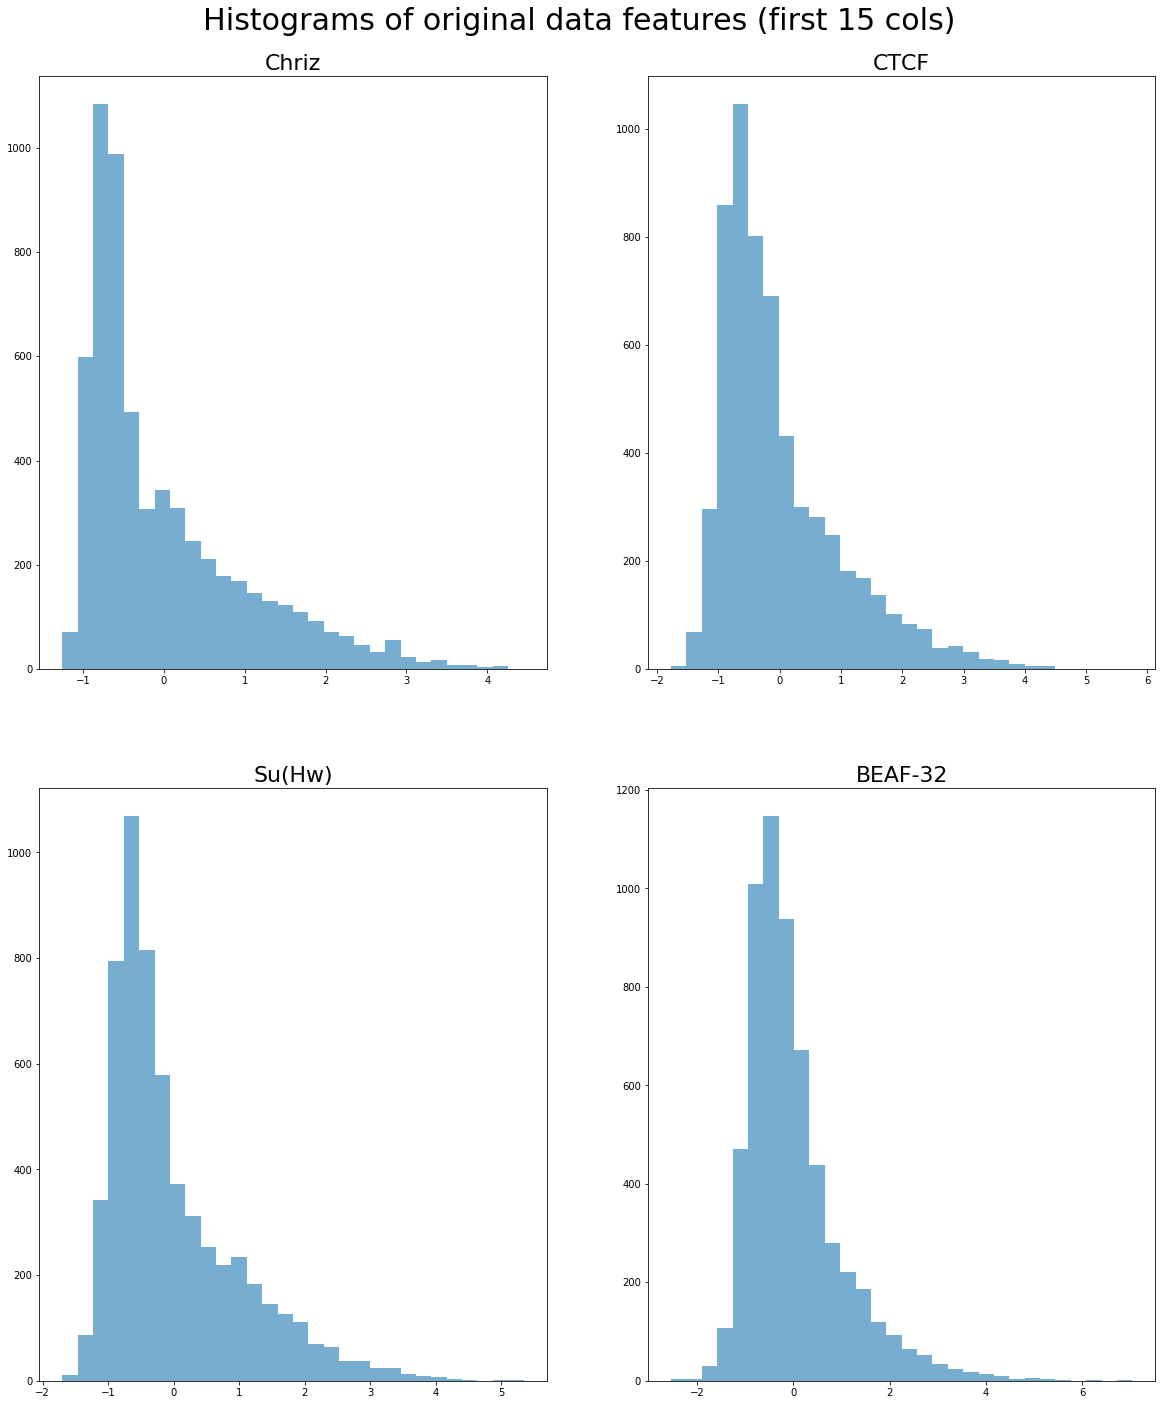

In [24]:
ncols = 2
nrows = 2
plotData(pd.DataFrame(data_scaled), ncols, nrows, bins=30, method = 'hist', is_sharex=False, plt_title='Histograms of original data features (first 15 cols)')

# target - gamma

# Explore target

In [25]:
target = gamma_S2.copy()
target.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   2.85
2  chr2L        40000   2.85
3  chr2L        60000   0.83
4  chr2L        80000   0.83

In [26]:
# np.unique(target.gamma)

Text(0.5, 1.0, 'gamma values for all bins')

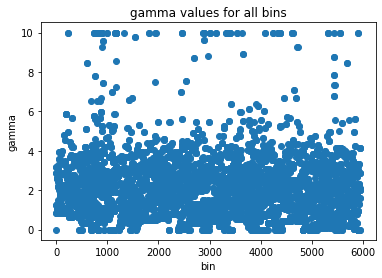

In [27]:
plt.scatter(np.arange(len(target.gamma)), target.gamma) # target
plt.xlabel('bin')
plt.ylabel('gamma')
plt.title('gamma values for all bins')

Text(0.5, 1.0, 'Distribution of gamma values for all bins')

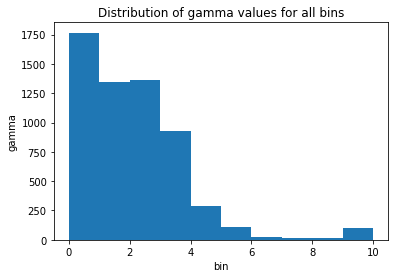

In [28]:
plt.hist(target.gamma)
plt.xlabel('bin')
plt.ylabel('gamma')
plt.title('Distribution of gamma values for all bins')

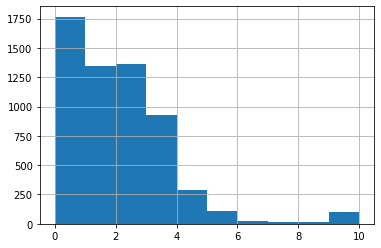

In [29]:
target.gamma.hist()

Log scale

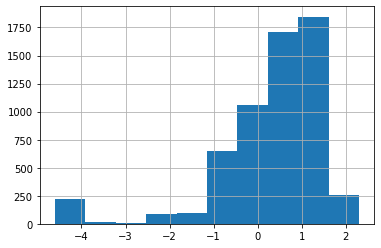

In [30]:
(np.log(0.01+target.gamma)).hist()

# Clean Data  from empty chromosomes

In [31]:
data_scaled_clean, target_clean, empty_chr_names, num_empty_bins = data_scaled, target, [], []
# cleanDataTarget(data_scaled, target)

data_scaled_clean.shape, target_clean.shape

((5950, 18), (5950, 3))

In [32]:
data_scaled_clean.head()

Chriz      CTCF    Su(Hw)   BEAF-32     CP190       GAF   H3K4me1  \
0 -0.055265  0.176236 -0.382725  0.615836 -0.321686 -1.150007 -0.030299   
1 -0.886483  0.977829  0.256232  0.974934 -0.321686  0.102129 -0.202139   
2 -0.560061  0.439357 -0.379988  0.787310 -0.298974 -0.585482 -0.113895   
3  0.467538  1.270631  0.129706  1.617598  0.937750  2.494165  0.998864   
4  0.576448  0.315444 -1.137679 -0.577721 -0.316388 -0.846799  0.872964   

    H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  H3K27me3  \
0  0.355814  0.088574  1.892256  3.332206  0.289616  0.276073 -0.273049   
1  0.218869  0.379795  1.729625  3.917137 -0.210702 -0.560819 -0.243520   
2  0.264750  0.306388  1.273195  3.151659 -0.350593 -0.129901 -0.282002   
3  1.347437  0.963690  0.101269  0.777372  1.076657  0.442158 -0.814469   
4 -0.048643 -0.480513  0.217265 -0.584462 -0.706711  0.049905 -0.588185   

   H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0 -0.315416  0.072578 -0.490435           0.515569  
1 -1.057711 -0.026025 -1.155219          -0.116656  
2 -0.794650 -0.137399 -0.769729          -0.017138  
3  0.561191  0.673200  1.206137           1.381558  
4  1.452362  0.665316  0.074116           0.501726

In [33]:
target_clean.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   2.85
2  chr2L        40000   2.85
3  chr2L        60000   0.83
4  chr2L        80000   0.83

Target distribution

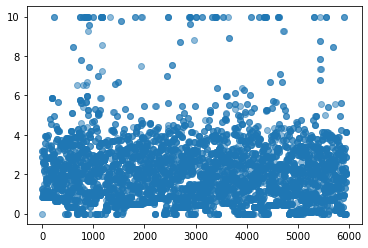

In [34]:
plt.scatter(np.arange(len(target_clean)),  target_clean.gamma, alpha=0.5)

(array([1766., 1347., 1362.,  927.,  291.,  106.,   27.,   14.,   12.,
          98.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

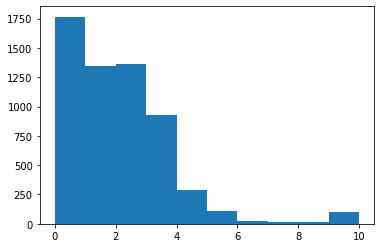

In [35]:
plt.hist(target_clean.gamma)

Log scale

(array([ 222.,    0.,   11.,    5.,   44.,  127.,  679., 1516., 2793.,
         553.]),
 array([-6.90775528, -5.98671124, -5.06566721, -4.14462317, -3.22357913,
        -2.3025351 , -1.38149106, -0.46044702,  0.46059701,  1.38164105,
         2.30268509]),
 <a list of 10 Patch objects>)

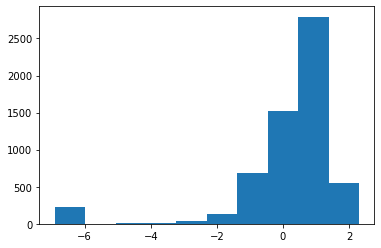

In [36]:
plt.hist(np.log(0.001 + target_clean.gamma))

In [37]:
target.shape, target.head()

((5950, 3),     chrN  start_coord  gamma
 0  chr2L            0   0.00
 1  chr2L        20000   2.85
 2  chr2L        40000   2.85
 3  chr2L        60000   0.83
 4  chr2L        80000   0.83)

# data_scaled_clean, target_clean - prossesed data

# Train Test Split

In [38]:
data = data_scaled_clean 
target = target_clean['gamma']

In [39]:
X, y = data_scaled_clean, target_clean['gamma']
X.shape, y.shape

((5950, 18), (5950,))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=16)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((4165, 18), (1785, 18), (4165,), (1785,))

# Linear Regression

In [41]:
%time

# Create linear regression object
lin_reg = linear_model.LinearRegression() 

# Train the model using the training sets
lin_reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg.predict(X_test)

model = lin_reg

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


 TEST PREDICTION Error
weighted_mse_test: 0.9629176651594556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0242856637141509 


 CONSTANT pred Error:
weighted_mse_test_const:  1.529260633960329
test sizes =  1785 1785 1785


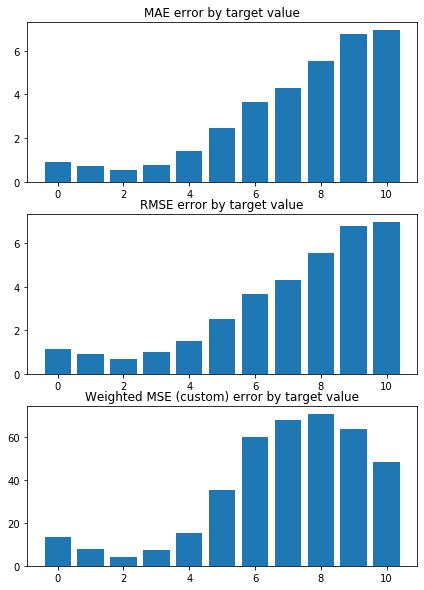

In [42]:
# Make predictions using the testing set
y_pred_train = lin_reg.predict(X_train)

weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  
                                                                          X_test,
                                                                          y_train.values, 
                                                                          y_test.values, 
                                                                          model)

In [43]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_[:20])

Coefficients: 
 [-1.04360740e-01 -9.22926469e-02  1.27557700e-01 -1.40925576e-01
  4.61164462e-03 -2.99810184e-01 -3.20775905e-01  4.38122616e-02
 -1.72138362e-01  1.85194497e-01 -3.52728354e-02  3.54009335e-04
  5.91437403e-02 -1.31049082e-01 -3.41858517e-01 -6.22596545e-01
  4.29594035e-01  8.41075589e-02]


In [44]:
coef = lin_reg.coef_

(array([1., 0., 2., 1., 4., 4., 3., 2., 0., 1.]),
 array([-0.62259655, -0.51737749, -0.41215843, -0.30693937, -0.20172031,
        -0.09650126,  0.0087178 ,  0.11393686,  0.21915592,  0.32437498,
         0.42959404]),
 <a list of 10 Patch objects>)

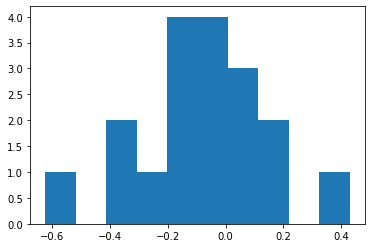

In [45]:
plt.hist(lin_reg.coef_)

Посмотрим на распределения остатков и на нормальное распределение.

(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   2.,   5.,   5.,
         12.,  10.,  15.,  23.,  32.,  39.,  55.,  61.,  82.,  81., 127.,
        146., 158., 161., 218., 239., 247., 228., 218., 262., 272., 209.,
        177., 166., 138., 136., 108.,  79.,  76.,  52.,  40.,  41.,  26.,
         18.,  10.,  11.,   5.,   4.,   3.]),
 array([-4.37739492, -4.22817485, -4.07895479, -3.92973472, -3.78051466,
        -3.63129459, -3.48207452, -3.33285446, -3.18363439, -3.03441432,
        -2.88519426, -2.73597419, -2.58675412, -2.43753406, -2.28831399,
        -2.13909392, -1.98987386, -1.84065379, -1.69143373, -1.54221366,
        -1.39299359, -1.24377353, -1.09455346, -0.94533339, -0.79611333,
        -0.64689326, -0.49767319, -0.34845313, -0.19923306, -0.05001299,
         0.09920707,  0.24842714,  0.39764721,  0.54686727,  0.69608734,
         0.8453074 ,  0.99452747,  1.14374754,  1.2929676 ,  1.44218767,
         1.59140774,  1.7406278 ,  1.88984787,  2.03906794,  2.188288  ,
 

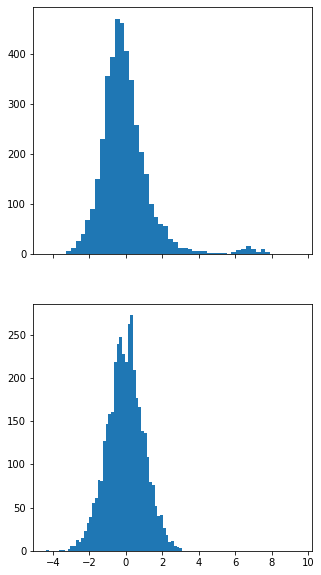

In [46]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train).values, bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

Следовательно ошибка на train имеет нормальное распределение -> модель обучается описывать данные

Значения, на которых модель возвращает наибольшую ошибку:

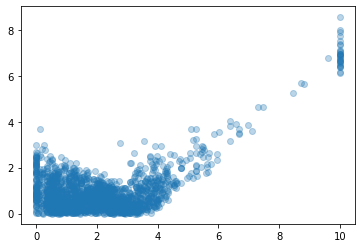

In [47]:
plt.scatter(y_test,  np.abs(y_test - y_pred) , alpha=0.3)

# Remove outlires
Посмотрим на результаты удаления объектов, для которых значение целевой переменной больше 9.

In [48]:
target_clean.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   2.85
2  chr2L        40000   2.85
3  chr2L        60000   0.83
4  chr2L        80000   0.83

In [49]:
data_scaled_clean[target < 9].values

target[target < 9].values

array([0.  , 2.85, 2.85, ..., 2.03, 0.  , 0.  ])

KFold(n_splits=5, random_state=3, shuffle=True)
train_index= [   1    2    3 ... 5848 5849 5851]
 TEST PREDICTION Error
weighted_mse_test: 0.9114520095230851 


 TRAIN PREDICTION Error
weighted_mse_train: 0.8658344747874094 


 CONSTANT pred Error:
weighted_mse_test_const:  1.451074897361999
test sizes =  1171 1171 1171


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


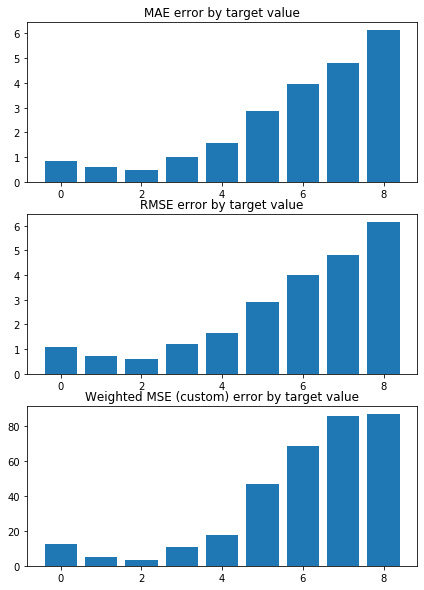

train_index= [   0    1    2 ... 5849 5850 5851]
 TEST PREDICTION Error
weighted_mse_test: 0.8774088703502018 


 TRAIN PREDICTION Error
weighted_mse_train: 0.8761689490129385 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3540046096107365
test sizes =  1171 1171 1171


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


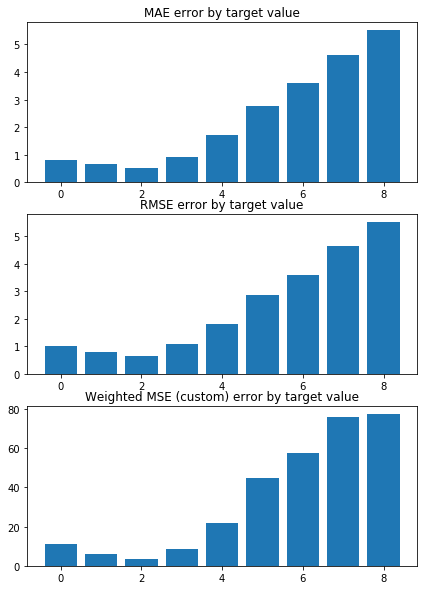

train_index= [   0    1    2 ... 5849 5850 5851]
 TEST PREDICTION Error
weighted_mse_test: 0.9186672234179837 


 TRAIN PREDICTION Error
weighted_mse_train: 0.8684096574284095 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4065885595837528
test sizes =  1170 1170 1170


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


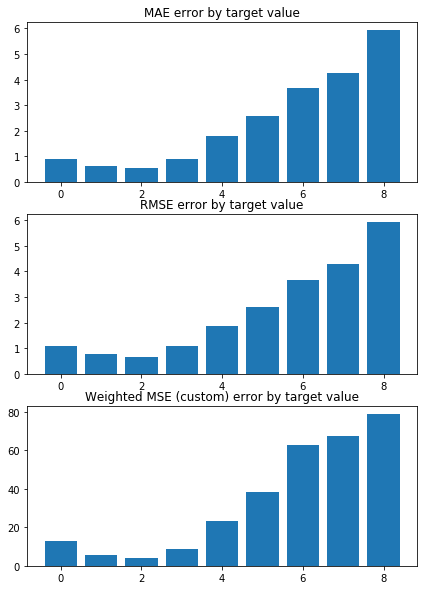

train_index= [   0    3    4 ... 5847 5848 5850]
 TEST PREDICTION Error
weighted_mse_test: 0.8056623369136461 


 TRAIN PREDICTION Error
weighted_mse_train: 0.8997293795620677 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3523979792411716
test sizes =  1170 1170 1170


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


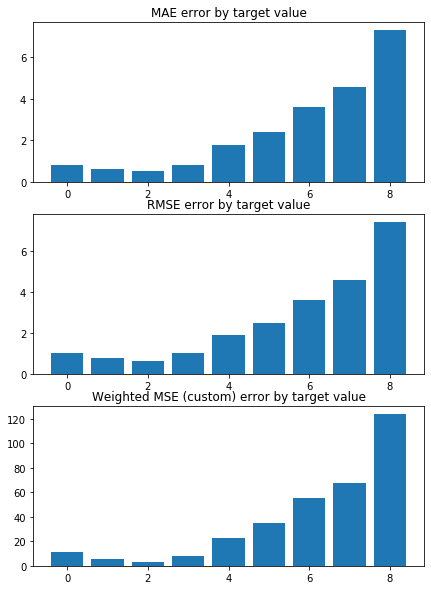

train_index= [   0    1    2 ... 5849 5850 5851]
 TEST PREDICTION Error
weighted_mse_test: 0.8972188020606254 


 TRAIN PREDICTION Error
weighted_mse_train: 0.8728736550209995 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4243478556596576
test sizes =  1170 1170 1170


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


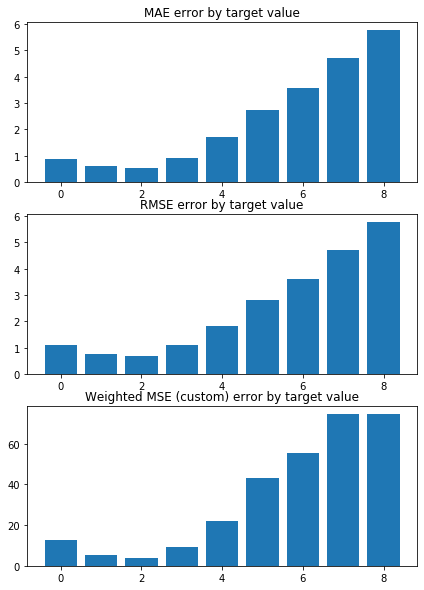

Weighted Mean squared error on Train: 0.88 
 MSE mean train: 1.2583378899392303 

Mean squared error on Test: 0.88 
 MSE mean test:  1.2660811648035823 

Root of MSE on Test: 0.94 
 1.125202721647785 

Variance score on Test: 0.04 
 r2_test: 0.35521035330564477 

wMSE_train 0.88
wMSE_test 0.88
MSE_train 1.26
MSE_test 1.27
MAE_train 0.84
MAE_test 0.85
r2_test 0.36
   H3K36me3   H4K16ac       GAF   H3K4me1  H3K36me1    Su(Hw)     Chriz  \
0 -0.418998  0.311411 -0.273084 -0.266720 -0.251299  0.167090 -0.164214   
1 -0.450094  0.290177 -0.255474 -0.246969 -0.263815  0.140231 -0.235313   
2 -0.469608  0.310111 -0.256332 -0.194319 -0.244805  0.146921 -0.206734   
3 -0.433144  0.277312 -0.275290 -0.251623 -0.254324  0.140481 -0.208965   
4 -0.453218  0.274410 -0.265332 -0.219846 -0.284223  0.143240 -0.202300   

    H3K9me2   H3K9me3   H3K4me3   H3K4me2   BEAF-32      CTCF  H3K27me3  \
0  0.140607 -0.110124 -0.093693  0.083285 -0.080784 -0.038686 -0.037678   
1  0.138507 -0.105781 -0.008138  

In [50]:
X, y = data_scaled_clean[target < 9].values, target[target < 9].values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression() 
model_name = 'LR+L1_no_outliers'


lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=5, random_state=3, shuffle=True)


In [51]:
results_pd 

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.882082       0.040723         0.876603   

   wMSE_train_std comments                  params  MSE_test_mean  \
0          0.0121        -  test_params = testtest       1.266081   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.083519        1.258338       0.020777   

                                             r2_test n_splits  \
0  [0.3472149517480847, 0.34455933626229596, 0.34...        5   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9207946942169912 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0052947139709658 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5729131802711864
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


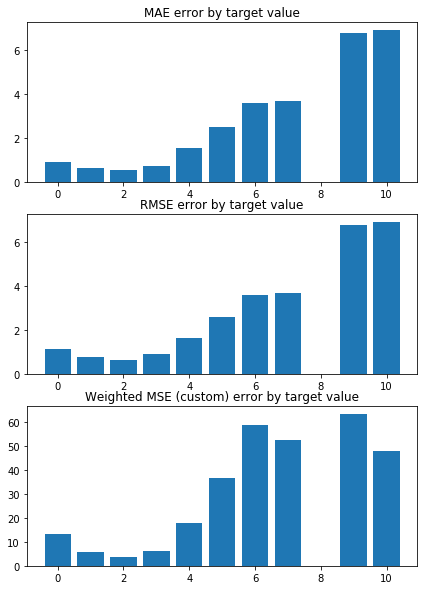

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9636326385605609 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0099787415727306 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


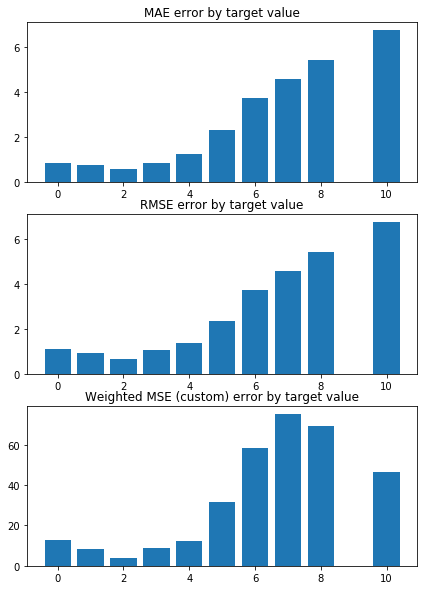

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9899108643765019 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0028070877586606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


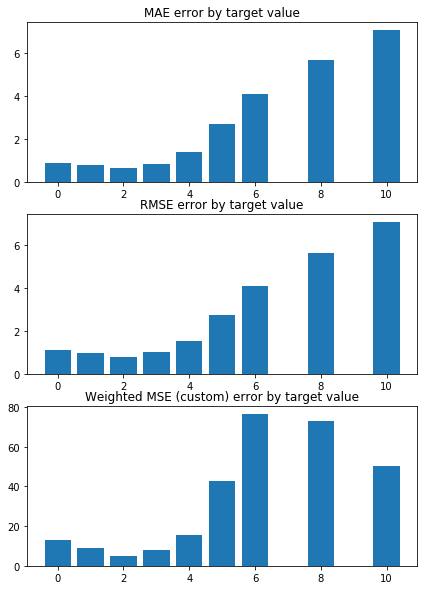

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0598734779663286 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9903170991439469 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


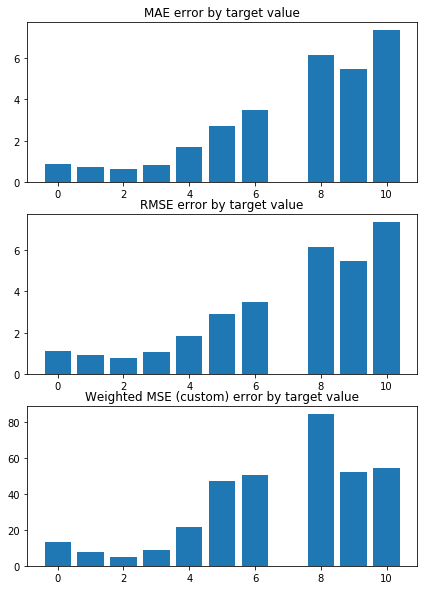

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9824384756272402 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0024322848366243 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


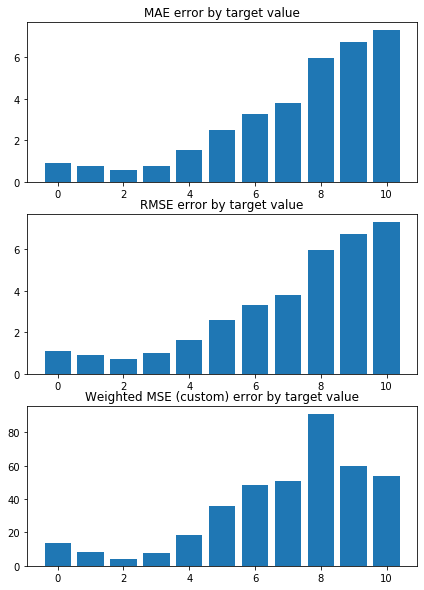

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.074025435929587 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9922696897590534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


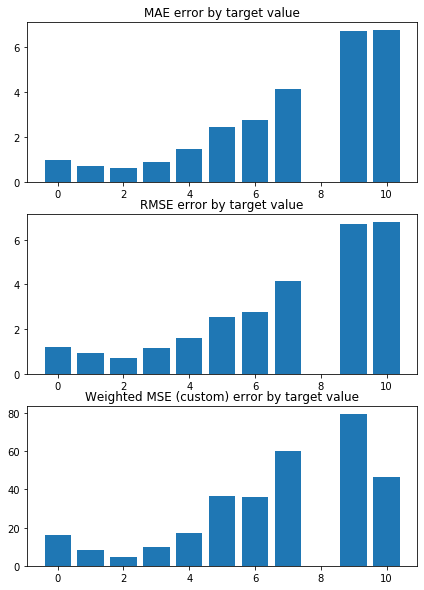

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.979877132949369 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0031022329965757 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


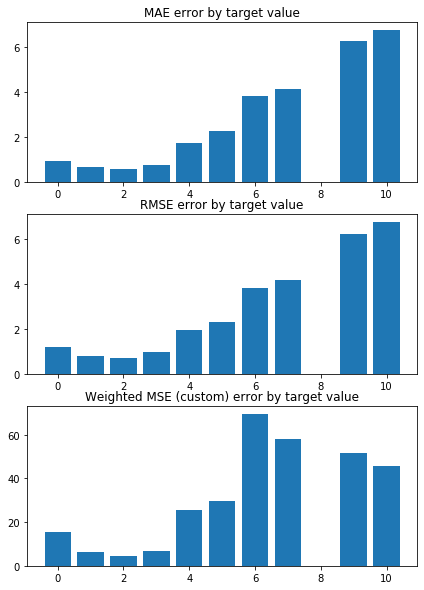

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.065803028248132 


 TRAIN PREDICTION Error
weighted_mse_train: 0.994112850950795 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


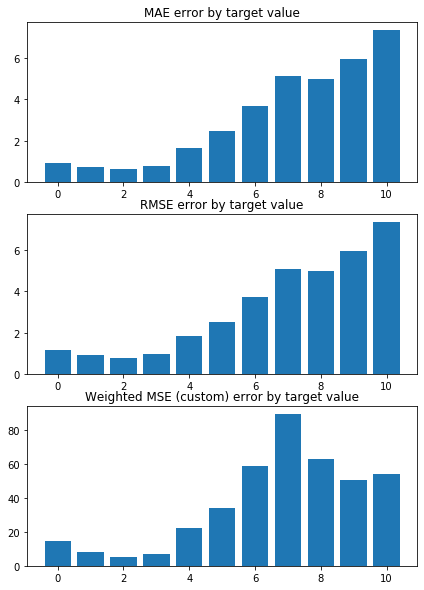

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0846201555666768 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9875771971304794 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


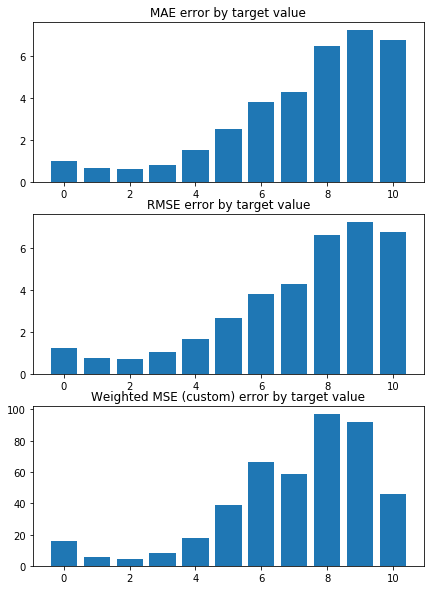

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9338448457395163 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0081880474286722 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


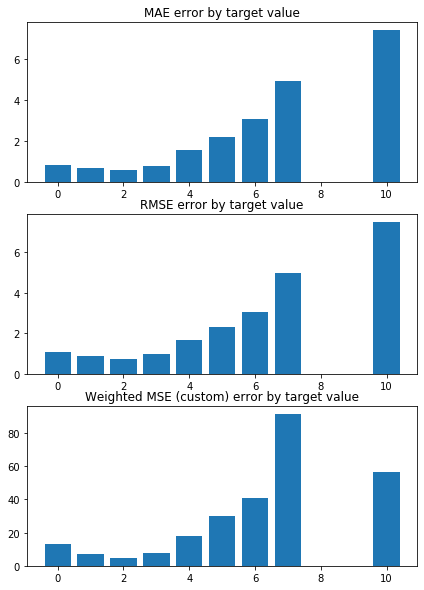

Weighted Mean squared error on Train: 1.00 
 MSE mean train: 2.076784477052019 

Mean squared error on Test: 1.01 
 MSE mean test:  2.0900530792800955 

Root of MSE on Test: 1.00 
 1.4457015872164267 

Variance score on Test: 0.06 
 r2_test: 0.294871896774198 

wMSE_train 1.0
wMSE_test 1.01
MSE_train 2.08
MSE_test 2.09
MAE_train 0.97
MAE_test 0.93
r2_test 0.29
   H3K36me3   H4K16ac   H3K4me1       GAF  H3K36me1    Su(Hw)   H3K4me3  \
0 -0.577725  0.383409 -0.359466 -0.290118 -0.286989  0.168162 -0.164325   
1 -0.616361  0.419153 -0.336181 -0.275444 -0.314071  0.151599 -0.146317   
2 -0.597374  0.407324 -0.344197 -0.311805 -0.323021  0.160319 -0.197146   
3 -0.594079  0.389974 -0.376728 -0.274175 -0.282688  0.161526 -0.129869   
4 -0.612782  0.394975 -0.323170 -0.292868 -0.313231  0.168017 -0.127444   
5 -0.580190  0.362782 -0.338988 -0.290572 -0.292281  0.184178 -0.127902   
6 -0.589758  0.401186 -0.357072 -0.285514 -0.280753  0.178384 -0.190846   
7 -0.567009  0.402720 -0.371730 -0.29

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.882082       0.040723         0.876603   
1                 LR        1.005482       0.057482         0.999608   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.012100        -  test_params = testtest       1.266081   
1        0.007477        -  test_params = testtest       2.090053   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.083519        1.258338       0.020777   
1      0.273496        2.076784       0.030222   

                                             r2_test n_splits  \
0  [0.3472149517480847, 0.34455933626229596, 0.34...        5   
1  [0.34664723078072357, 0.3388569208172696, 0.26...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...

In [52]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression() 

model_name = 'LR'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)
results_pd

In [53]:
results_pd

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.882082       0.040723         0.876603   
1                 LR        1.005482       0.057482         0.999608   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.012100        -  test_params = testtest       1.266081   
1        0.007477        -  test_params = testtest       2.090053   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.083519        1.258338       0.020777   
1      0.273496        2.076784       0.030222   

                                             r2_test n_splits  \
0  [0.3472149517480847, 0.34455933626229596, 0.34...        5   
1  [0.34664723078072357, 0.3388569208172696, 0.26...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...

In [54]:
coefs_argsort, coefs

(array([[15, 16,  6,  5, 14,  2,  8,  9, 13,  0,  3,  1, 17,  7, 10, 12,
         11,  4],
        [15, 16,  6, 14,  5,  9,  2,  8,  3, 13,  0,  1, 17, 12, 10,  7,
          4, 11],
        [15, 16,  6, 14,  5,  8,  9,  2, 13,  3,  0,  7,  1, 17, 10, 12,
         11,  4],
        [15, 16,  6, 14,  5,  9,  2, 13,  8,  0,  3,  1, 10, 17,  7, 12,
         11,  4],
        [15, 16,  6, 14,  5,  9,  2,  3, 13,  0,  8, 17,  1, 10,  7, 12,
         11,  4],
        [15, 16,  6, 14,  5,  2,  9, 13,  8,  0,  3,  1, 17,  7, 12, 10,
          4, 11],
        [15, 16,  6,  5, 14,  8,  2,  9,  3, 13,  1,  0,  7, 17, 10, 12,
          4, 11],
        [15, 16,  6, 14,  5,  8,  2,  9, 13,  0,  3, 17,  1,  7, 10, 12,
          4, 11],
        [15, 16,  6, 14,  5,  8,  9,  2, 13,  0,  3, 17,  1,  7, 10, 12,
          4, 11],
        [15, 16,  6,  5, 14,  8,  2,  9, 13,  1,  3,  0, 17,  7, 12, 10,
         11,  4]]), array([[-1.26047343e-01, -1.06315424e-01,  1.68161757e-01,
         -1.11427846e-01, -5.

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(array([  1.,   0.,   0.,   1.,   0.,   2.,   1.,   4.,   6.,   5.,   9.,
         22.,  21.,  30.,  36.,  45.,  66.,  82.,  83., 107., 117., 174.,
        181., 186., 212., 200., 215., 237., 250., 218., 228., 186., 168.,
        175., 160., 125., 111.,  72.,  70.,  56.,  40.,  29.,  16.,  14.,
         17.,   8.,  10.,   2.,   1.,   1.]),
 array([-3.99946634, -3.85435909, -3.70925184, -3.56414459, -3.41903734,
        -3.27393009, -3.12882284, -2.98371559, -2.83860834, -2.69350109,
        -2.54839383, -2.40328658, -2.25817933, -2.11307208, -1.96796483,
        -1.82285758, -1.67775033, -1.53264308, -1.38753583, -1.24242858,
        -1.09732133, -0.95221408, -0.80710683, -0.66199958, -0.51689232,
        -0.37178507, -0.22667782, -0.08157057,  0.06353668,  0.20864393,
         0.35375118,  0.49885843,  0.64396568,  0.78907293,  0.93418018,
         1.07928743,  1.22439468,  1.36950193,  1.51460918,  1.65971644,
         1.80482369,  1.94993094,  2.09503819,  2.24014544,  2.38525269,
 

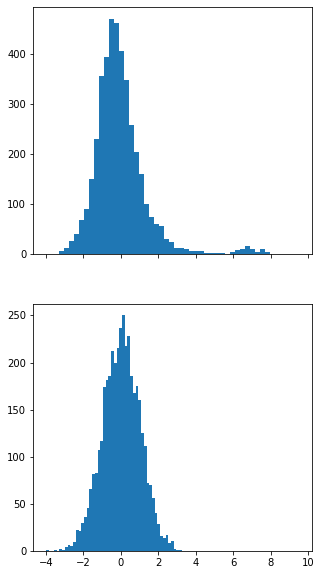

In [55]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train), bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

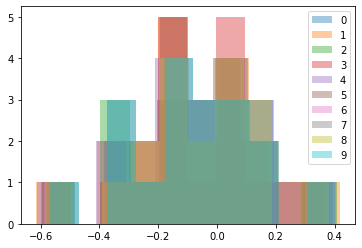

In [56]:
for i, coef_i in enumerate(coefs):
    plt.hist(coef_i, label=str(i), alpha=0.4, bins=10)
plt.legend()

(array([1., 0., 2., 1., 5., 2., 3., 3., 0., 1.]),
 array([-0.57772547, -0.48161199, -0.38549852, -0.28938504, -0.19327157,
        -0.09715809, -0.00104461,  0.09506886,  0.19118234,  0.28729582,
         0.38340929]),
 <a list of 10 Patch objects>)

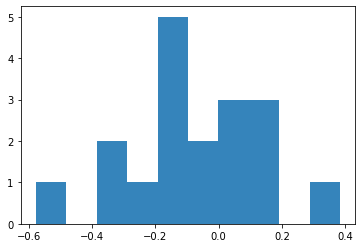

In [57]:
plt.hist(coefs[0], label=str(i), alpha=0.9, bins=10)

### Отсортированные номера выделенных признаков обычной линейной модели

In [58]:
su_drsc.columns

Index(['chrN', 'start_coord', 'Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190',
       'GAF', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac',
       'H3K27me1', 'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac',
       'RNA-polymerase-II'],
      dtype='object')

In [59]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['H3K36me3', 'H4K16ac', 'H3K4me1', 'GAF', 'H3K36me1', 'Su(Hw)',
       'H3K4me3', 'H3K9me2', 'H3K27me3', 'Chriz', 'BEAF-32', 'CTCF',
       'RNA-polymerase-II', 'H3K4me2', 'H3K9me3', 'H3K27me1', 'H3K27ac',
       'CP190'],
      dtype='object')

In [60]:
coefs_argsort

array([[15, 16,  6,  5, 14,  2,  8,  9, 13,  0,  3,  1, 17,  7, 10, 12,
        11,  4],
       [15, 16,  6, 14,  5,  9,  2,  8,  3, 13,  0,  1, 17, 12, 10,  7,
         4, 11],
       [15, 16,  6, 14,  5,  8,  9,  2, 13,  3,  0,  7,  1, 17, 10, 12,
        11,  4],
       [15, 16,  6, 14,  5,  9,  2, 13,  8,  0,  3,  1, 10, 17,  7, 12,
        11,  4],
       [15, 16,  6, 14,  5,  9,  2,  3, 13,  0,  8, 17,  1, 10,  7, 12,
        11,  4],
       [15, 16,  6, 14,  5,  2,  9, 13,  8,  0,  3,  1, 17,  7, 12, 10,
         4, 11],
       [15, 16,  6,  5, 14,  8,  2,  9,  3, 13,  1,  0,  7, 17, 10, 12,
         4, 11],
       [15, 16,  6, 14,  5,  8,  2,  9, 13,  0,  3, 17,  1,  7, 10, 12,
         4, 11],
       [15, 16,  6, 14,  5,  8,  9,  2, 13,  0,  3, 17,  1,  7, 10, 12,
         4, 11],
       [15, 16,  6,  5, 14,  8,  2,  9, 13,  1,  3,  0, 17,  7, 12, 10,
        11,  4]])

In [61]:
pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

H3K36me3  H4K16ac  H3K4me1  GAF  H3K36me1  Su(Hw)  H3K4me3  H3K9me2  \
0        15       16        6    5        14       2        8        9   
1        15       16        6   14         5       9        2        8   
2        15       16        6   14         5       8        9        2   
3        15       16        6   14         5       9        2       13   
4        15       16        6   14         5       9        2        3   
5        15       16        6   14         5       2        9       13   
6        15       16        6    5        14       8        2        9   
7        15       16        6   14         5       8        2        9   
8        15       16        6   14         5       8        9        2   
9        15       16        6    5        14       8        2        9   

   H3K27me3  Chriz  BEAF-32  CTCF  RNA-polymerase-II  H3K4me2  H3K9me3  \
0        13      0        3     1                 17        7       10   
1         3     13        0     1                 17       12       10   
2        13      3        0     7                  1       17       10   
3         8      0        3     1                 10       17        7   
4        13      0        8    17                  1       10        7   
5         8      0        3     1                 17        7       12   
6         3     13        1     0                  7       17       10   
7        13      0        3    17                  1        7       10   
8        13      0        3    17                  1        7       10   
9        13      1        3     0                 17        7       12   

   H3K27me1  H3K27ac  CP190  
0        12       11      4  
1         7        4     11  
2        12       11      4  
3        12       11      4  
4        12       11      4  
5        10        4     11  
6        12        4     11  
7        12        4     11  
8        12        4     11  
9        10       11      4

# !! одинаковая приоритизация 

In [62]:
def getConfIdxFrequencies(coefs_argsort, row_lim, min_lim = 5, max_lim = 5):
    ''' 
    Get Frequencies of feature indexes in the sorted array of indexes bu the coefficient of the feature in different itterstions.
    The smallest and the biggest elements are valueable - as they give the biggest impact.
    min_lim, max_lim - limitations of the number of smallest and biggest coefficients to consider for the frequency.
    '''
    merged_coefs = np.concatenate(np.hstack([coefs_argsort[:row_lim,:min_lim], coefs_argsort[:row_lim,-max_lim:]]))

    merged_coefs = list(merged_coefs)

    featur_freq_dict =  dict((i, merged_coefs.count(i)) for i in merged_coefs)
    for key, value in  sorted(featur_freq_dict.items(), key=lambda item: (-item[1], item[0])):
        print("{}: {}".format(key, value))
        
    return featur_freq_dict

In [63]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort, row_lim=len(coefs_argsort), min_lim = 3, max_lim = 3)

4: 10
6: 10
11: 10
15: 10
16: 10
12: 7
10: 2
7: 1


## Explore fold with big error

train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    2    3 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5946 5948 5949]
train_index= [   1    4    5 ... 5945 5947 5949]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5946 5947 5948]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5947 5948 5949]


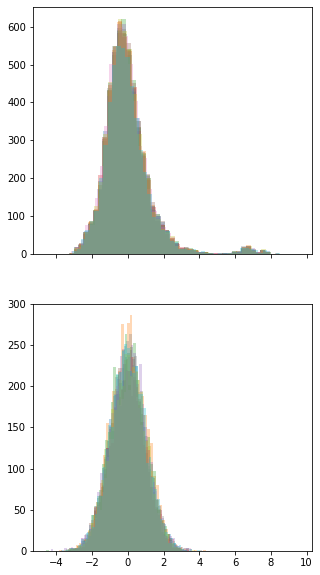

In [64]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

     # Train the model using the training sets
    model.fit(X_train, y_train)

    # Make predictions using the train set
    y_pred_train = model.predict(X_train)

    # Make predictions using the testing set
    y_pred = model.predict(X_test)

    axes[0].hist(y_train - y_pred_train, bins=50, alpha=0.3)
    axes[1].hist(np.random.randn(4000), bins=50, alpha=0.3)

# ================================================================

# Linear Regression with L1 regularization -  LASSO

$$ (1 / (2  n\_{samples}))  ||y - Xw||^2_2 + \alpha * ||w||_1 $$


In [65]:
X, y = data_scaled_clean, target_clean.gamma
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=10)

In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso()

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

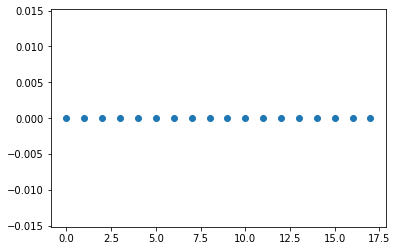

In [67]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [68]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

Index([], dtype='object')

In [69]:
lin_reg_l1.coef_

array([-0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,
        0., -0., -0., -0., -0.])

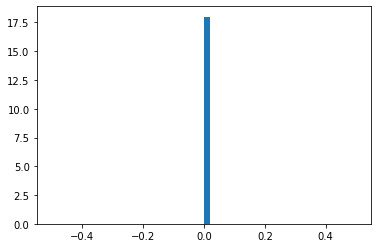

In [70]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

In [71]:
# f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
# axes[0].hist((y_train - y_pred_train), bins=50)
# axes[1].hist(np.random.randn(4000), bins=50)

### Cross validation
without outliers

In [72]:
# X, y = data_scaled_clean[target < 9].values, target[target < 9].values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# # Create linear regression with L2 regularization object
# model_l1 = linear_model.Lasso(0.2)

# model_name = 'LR+L1_t<.9'

# lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
#                 weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const, \
#                 results_pd = train_test_KFold(X, y, 
#                                               model, model_name, results_pd,
#                                               n_splits=5, random_state=3, shuffle=True)
# results_pd

In [73]:
# np.mean(weighted_mse_test_all)

In [74]:
# for coef_i in coefs_l1:
#     plt.hist(coef_i, alpha=0.5)
# plt.hist(coefs_l1[0], alpha=0.5)

In [75]:
# np.sort(coefs_l1)

In [76]:
# lin_reg_l1.predict(X_test)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L 1 

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5729131802711864 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5233751150317654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5729131802711864
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


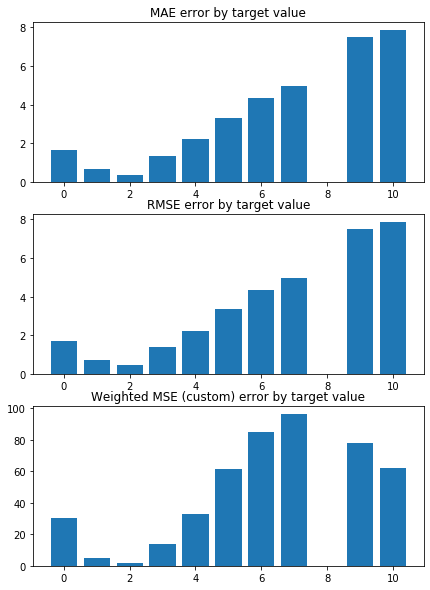

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


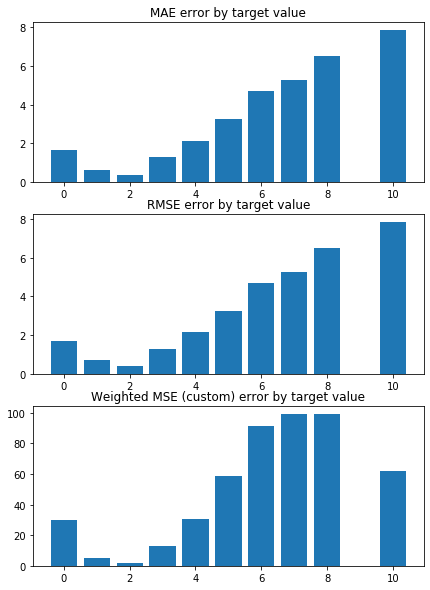

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


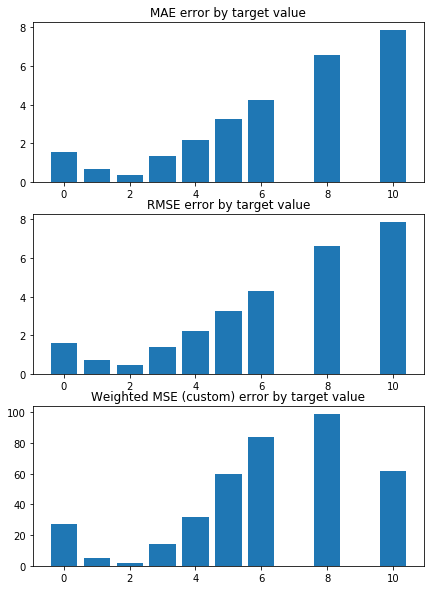

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


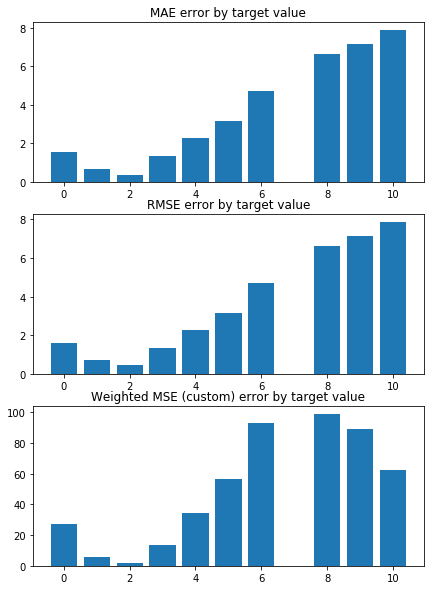

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


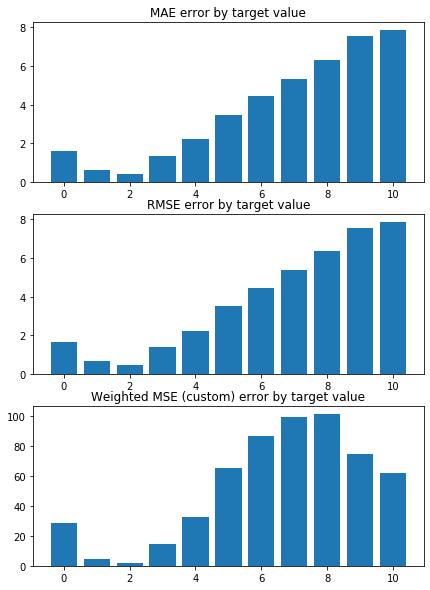

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


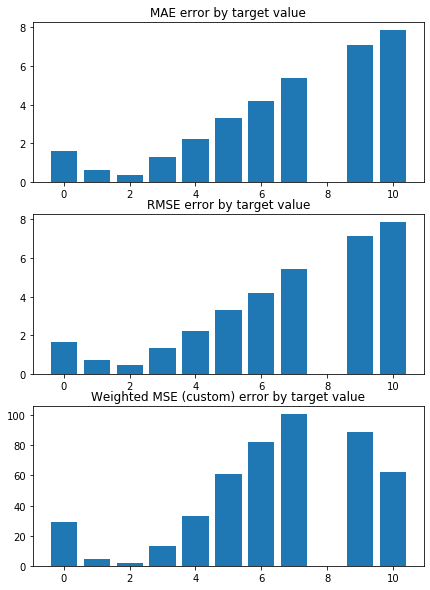

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


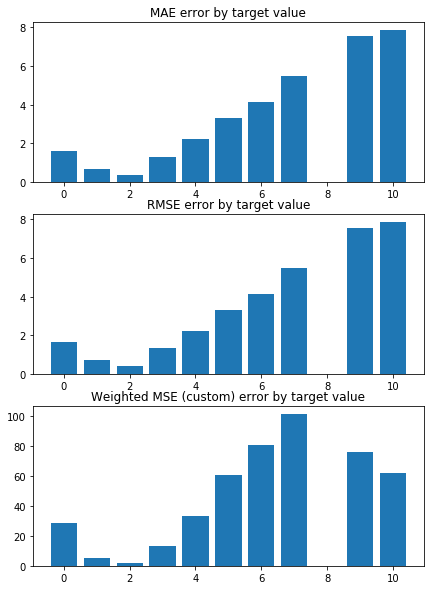

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


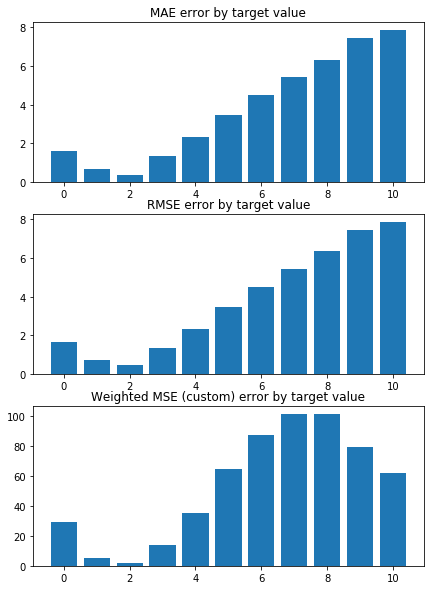

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


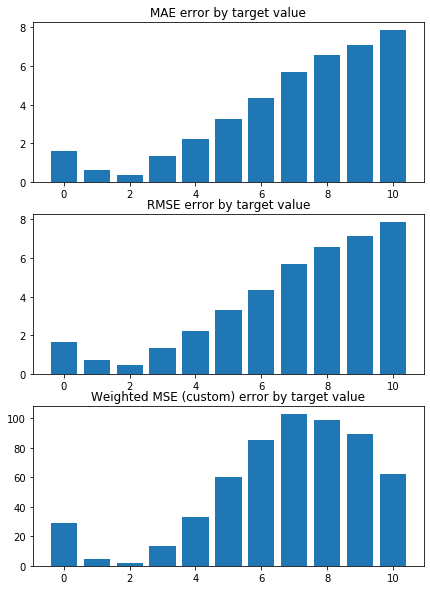

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


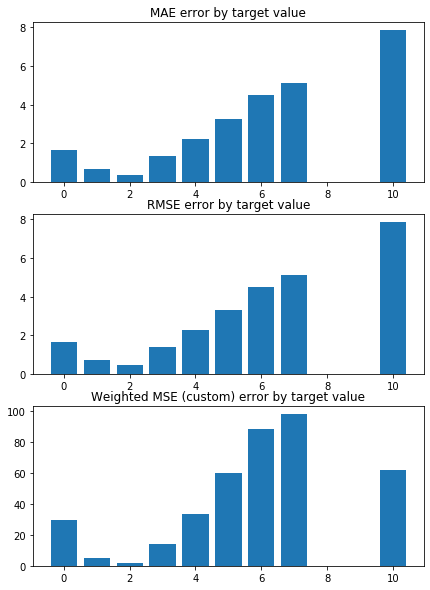

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.882082       0.040723         0.876603   
1                 LR        1.005482       0.057482         0.999608   
2              LR+L1        1.529790       0.059013         1.529494   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.012100        -  test_params = testtest       1.266081   
1        0.007477        -  test_params = testtest       2.090053   
2        0.006710        -  test_params = testtest       2.957657   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.083519        1.258338       0.020777   
1      0.273496        2.076784       0.030222   
2      0.250348        2.957027       0.027812   

                                             r2_test n_splits  \
0  [0.3472149517480847, 0.34455933626229596, 0.34...        5   
1  [0.34664723078072357, 0.3388569208172696, 0.26...       10   
2  [-0.0001539722018664147, -0.004334572980854823...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...

In [77]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.Lasso()

model_name = 'LR+L1'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)
results_pd

# Fined parametrs for lasso L1

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9207946942169193 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0052947139708956 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5729131802711864
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5580.177460787563, tolerance: 1.5753001672530345
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

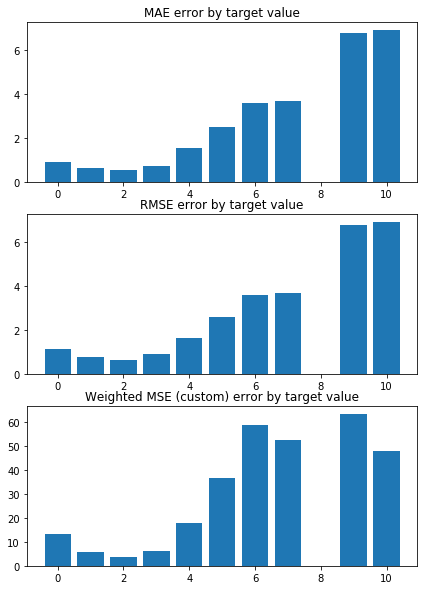

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9636326385609956 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0099787415726738 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5642.099775947289, tolerance: 1.5951549408328658
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

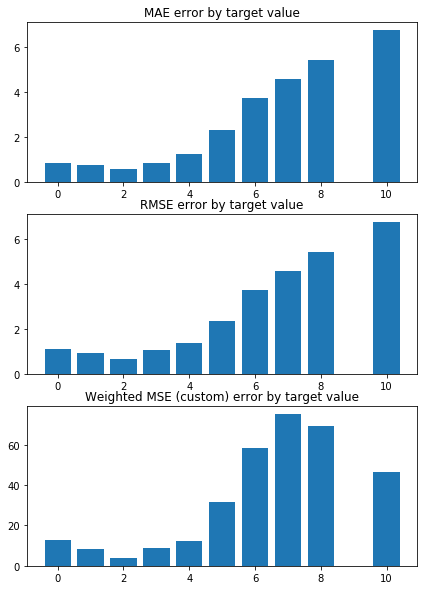

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.989910864376035 


 TRAIN PREDICTION Error
weighted_mse_train: 1.002807087758519 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5532.50200380008, tolerance: 1.5821769354883282
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

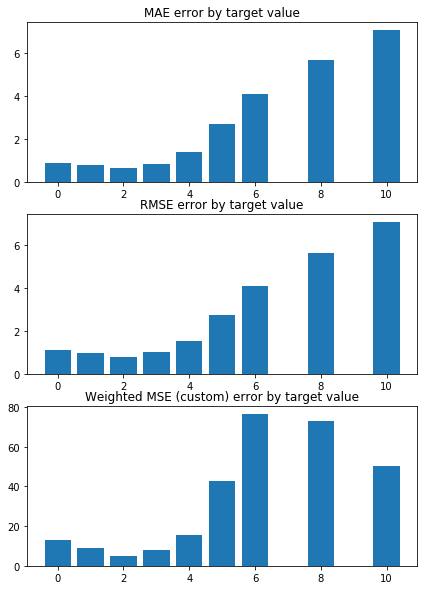

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0598734779663155 


 TRAIN PREDICTION Error
weighted_mse_train: 0.990317099143811 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5397.309586260339, tolerance: 1.5581200225471517
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

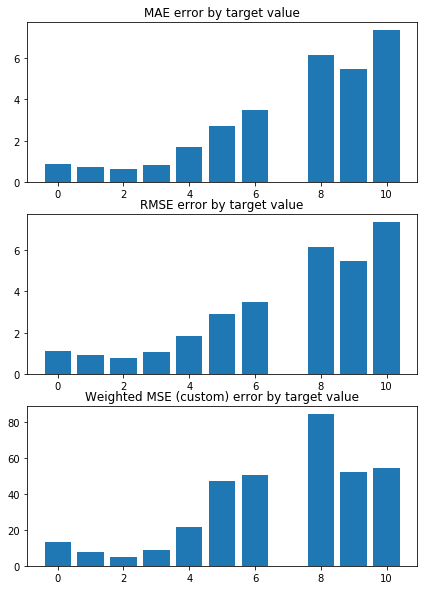

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9824384756274219 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0024322848365612 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5667.20763820735, tolerance: 1.6044926244369746
  positive)


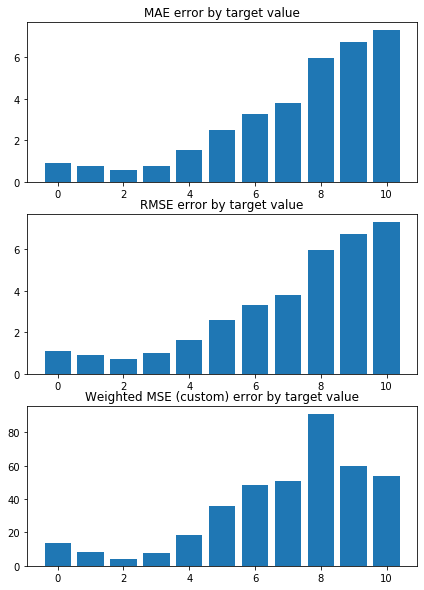

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0740254359296069 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9922696897589997 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5458.75007140212, tolerance: 1.5618709890457518
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

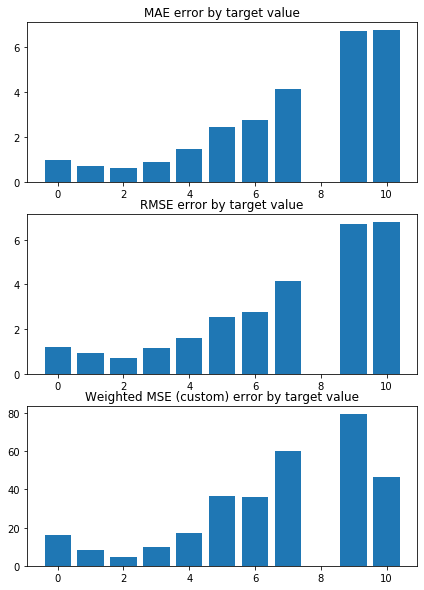

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9798771329490155 


 TRAIN PREDICTION Error
weighted_mse_train: 1.003102232996511 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5641.873242432553, tolerance: 1.6006251832941174
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

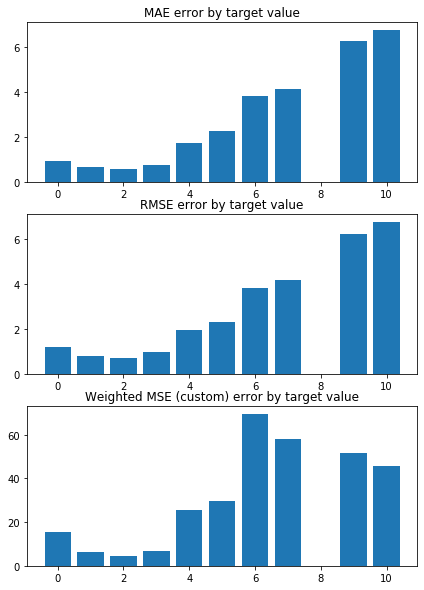

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.0658030282478732 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9941128509507394 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5593.180610592562, tolerance: 1.591772067394958
  positive)


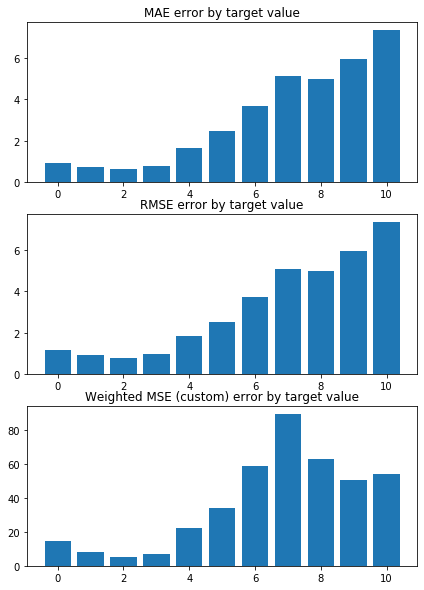

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0846201555666581 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9875771971303583 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522.002913154479, tolerance: 1.5756948114957992
  positive)


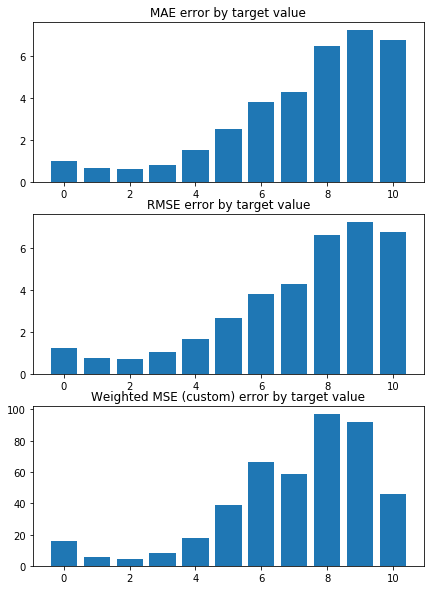

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9338448457390943 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0081880474285914 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5570.801070483486, tolerance: 1.5896707153314662
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

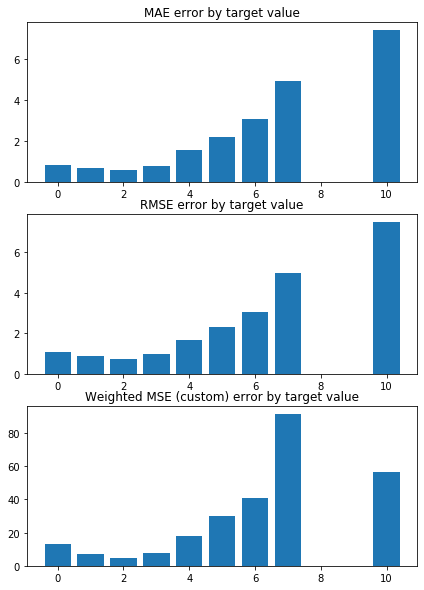

Weighted Mean squared error on Train: 1.00 
 MSE mean train: 2.076784477052019 

Mean squared error on Test: 1.01 
 MSE mean test:  2.0900530792800787 

Root of MSE on Test: 1.00 
 1.445701587216421 

Variance score on Test: 0.06 
 r2_test: 0.29487189677420245 

wMSE_train 1.0
wMSE_test 1.01
MSE_train 2.08
MSE_test 2.09
MAE_train 0.97
MAE_test 0.93
r2_test 0.29
   H3K36me3   H4K16ac   H3K4me1       GAF  H3K36me1    Su(Hw)   H3K4me3  \
0 -0.577725  0.383409 -0.359466 -0.290118 -0.286989  0.168162 -0.164325   
1 -0.616361  0.419153 -0.336181 -0.275444 -0.314071  0.151599 -0.146317   
2 -0.597374  0.407324 -0.344197 -0.311805 -0.323021  0.160319 -0.197146   
3 -0.594079  0.389974 -0.376728 -0.274175 -0.282688  0.161526 -0.129869   
4 -0.612782  0.394975 -0.323170 -0.292868 -0.313231  0.168017 -0.127444   
5 -0.580190  0.362782 -0.338988 -0.290572 -0.292281  0.184178 -0.127902   
6 -0.589758  0.401186 -0.357072 -0.285514 -0.280753  0.178384 -0.190846   
7 -0.567009  0.402720 -0.371730 -0.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


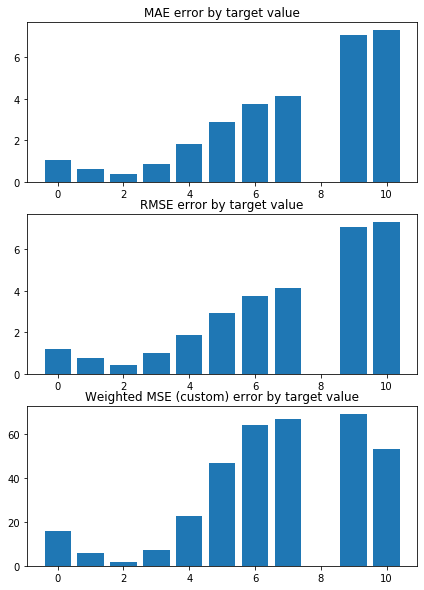

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9935001919466534 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0515745894171775 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


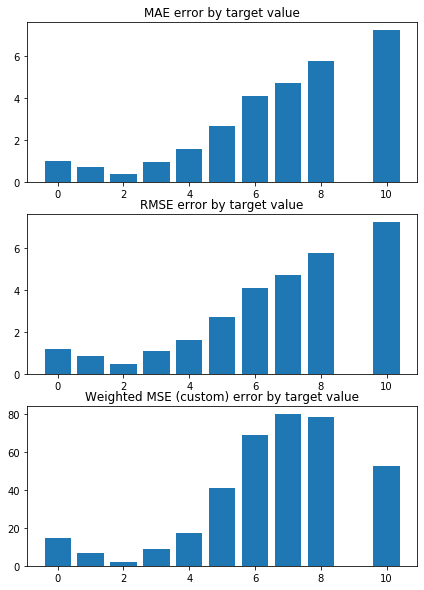

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.980940070835858 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0417681848630542 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


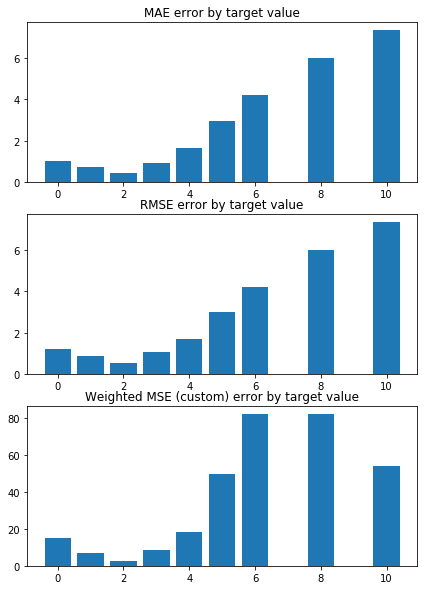

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0828687012326546 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0305134361001704 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


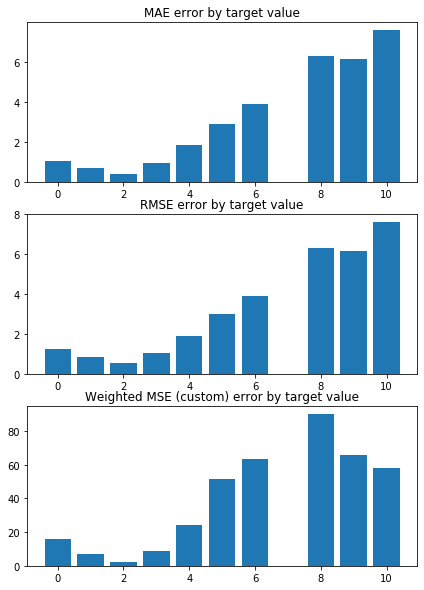

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0329019659936711 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0406686442003947 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


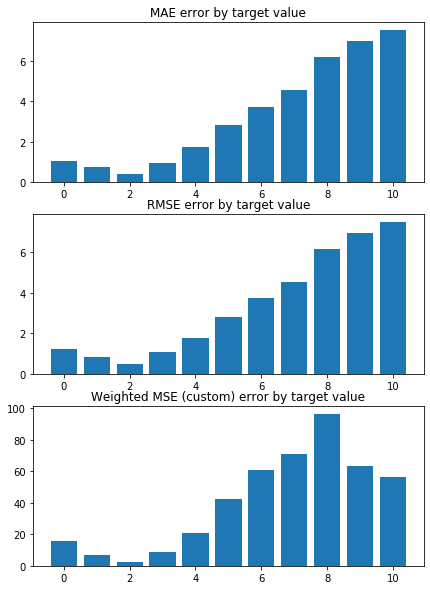

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0840870512808882 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0346174005574384 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


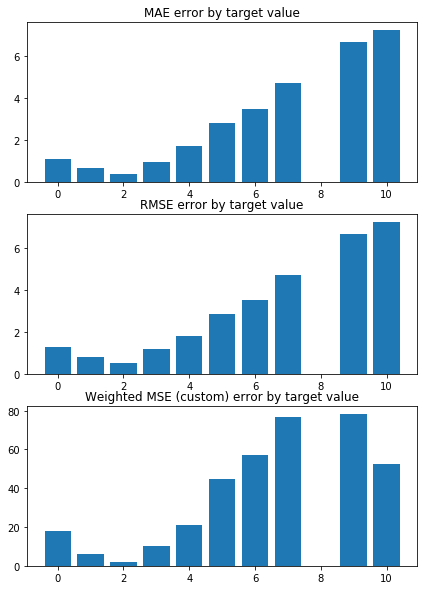

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0185158828873673 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0437306390734131 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


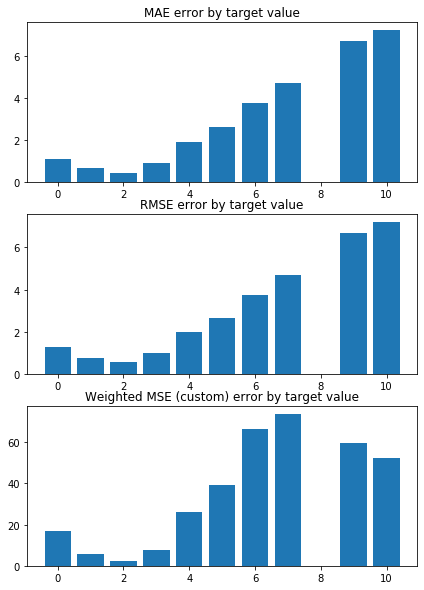

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1150508228728686 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0319821971942589 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


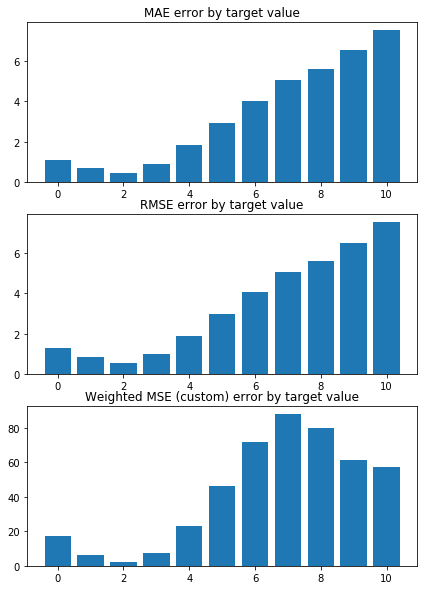

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1487508717068227 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0261687385116758 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


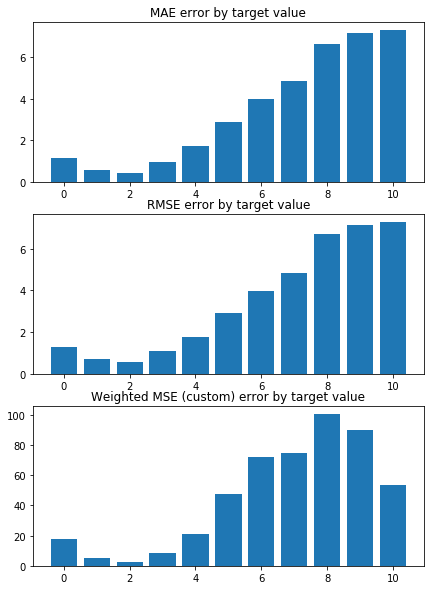

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9500278664083303 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0464561293785304 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


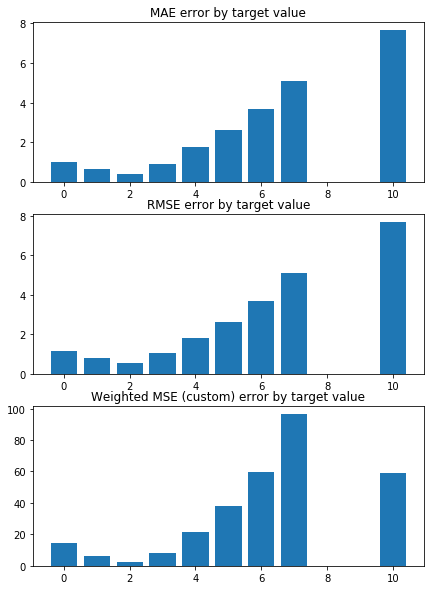

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.222527498822653 

Mean squared error on Test: 1.04 
 MSE mean test:  2.227074987703675 

Root of MSE on Test: 1.02 
 1.492338764390872 

Variance score on Test: 0.06 
 r2_test: 0.24863487729102599 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.22
MSE_test 2.23
MAE_train 1.01
MAE_test 0.97
r2_test 0.25
    H3K4me1  H3K36me3     Chriz      CTCF       GAF   H3K4me2  H3K36me1  \
0 -0.339689 -0.194040 -0.106285 -0.084132 -0.024967 -0.016885      -0.0   
1 -0.332580 -0.189499 -0.063467 -0.083322 -0.023082 -0.074374      -0.0   
2 -0.333473 -0.198546 -0.073950 -0.072052 -0.051764 -0.053186      -0.0   
3 -0.352891 -0.205052 -0.076430 -0.104015 -0.013177 -0.030122      -0.0   
4 -0.351794 -0.195974 -0.104568 -0.088609 -0.021992 -0.011172      -0.0   
5 -0.344789 -0.194875 -0.108205 -0.081920 -0.012296 -0.024450      -0.0   
6 -0.342733 -0.195608 -0.075043 -0.089923 -0.017596 -0.053528      -0.0   
7 -0.349698 -0.197779 -0.098954 -0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


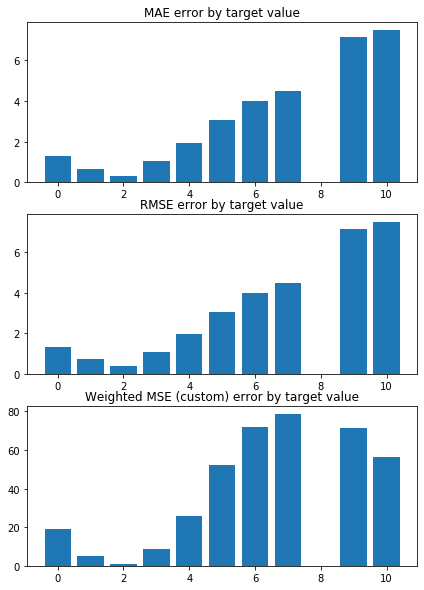

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1361983612790336 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1596605998324703 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


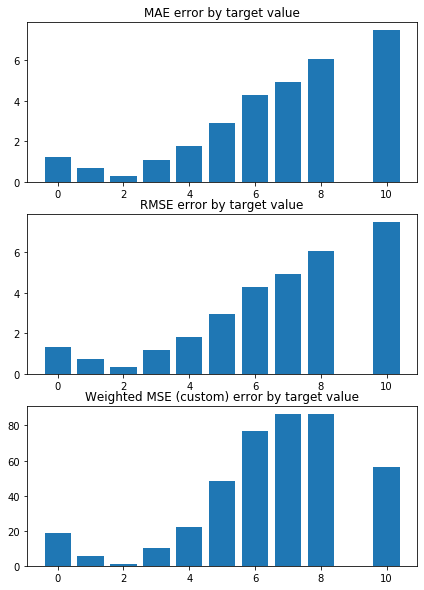

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.072598952388322 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1542208781919534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


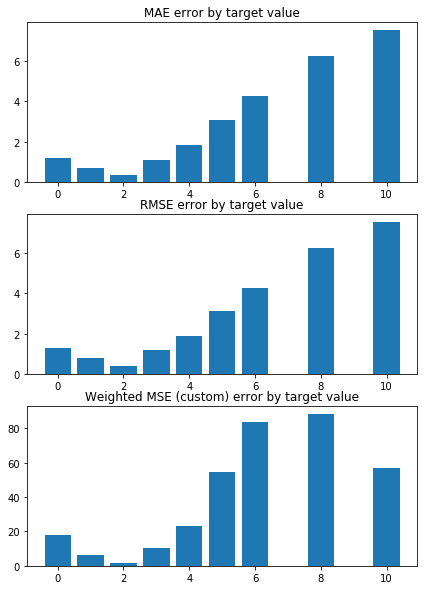

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1561755316418252 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1333684660177568 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


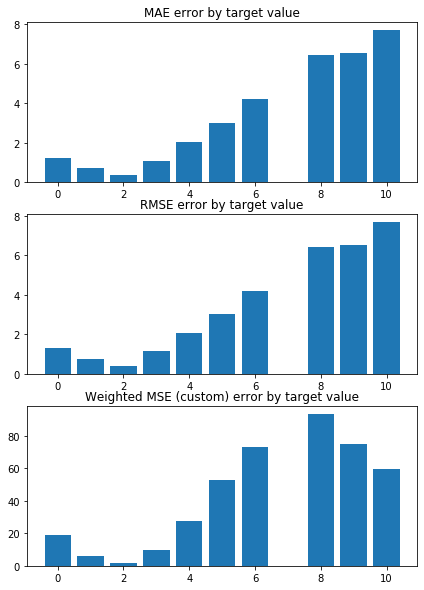

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1521698848623805 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1466061164878278 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


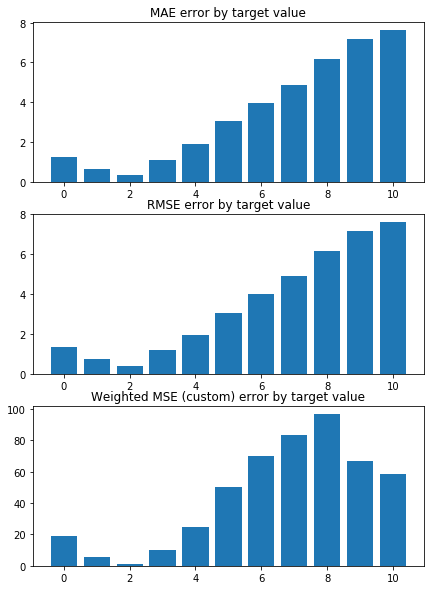

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1591455737750607 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1427909832662064 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


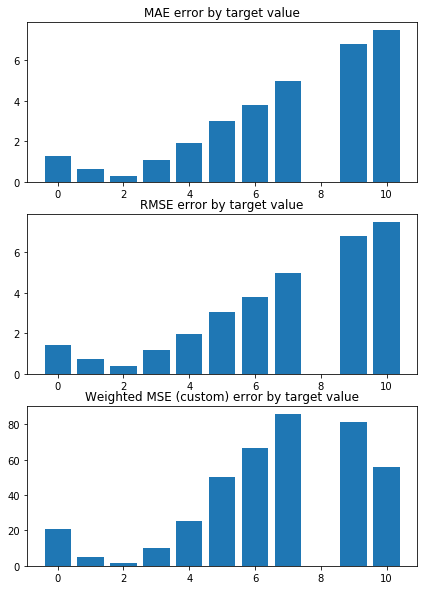

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.110165024016513 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1515073700092717 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


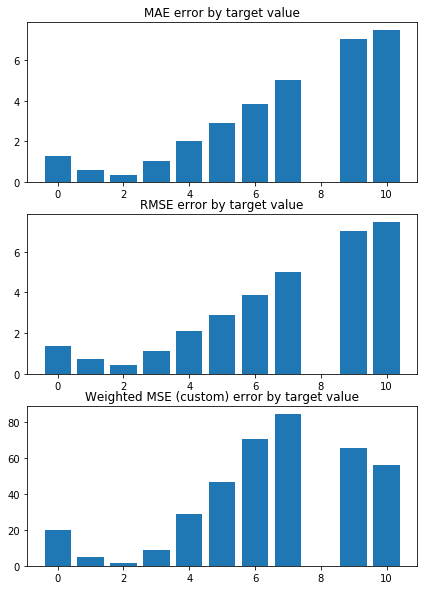

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2239945739183828 


 TRAIN PREDICTION Error
weighted_mse_train: 1.138099493335371 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


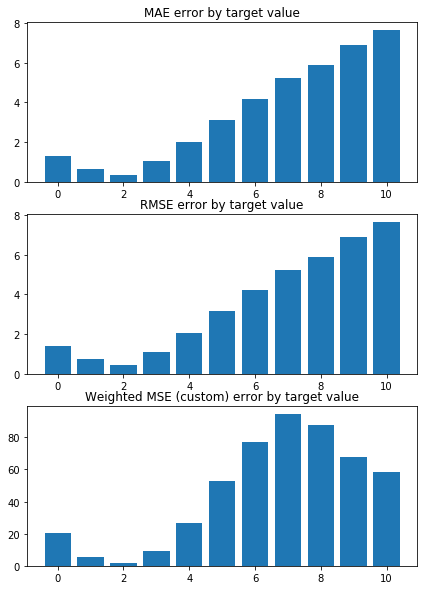

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2657523356420939 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1319120385947314 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


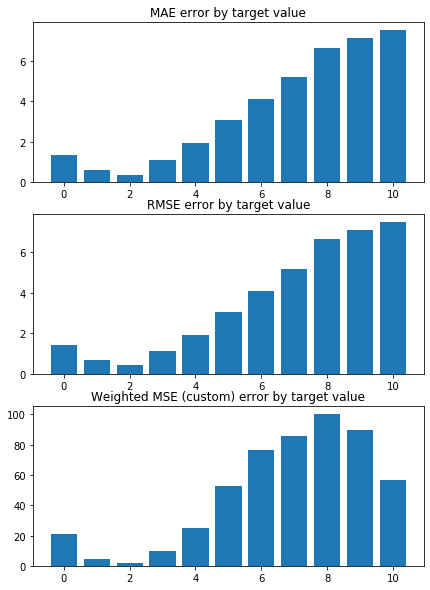

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.068812960030394 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1530821959244362 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


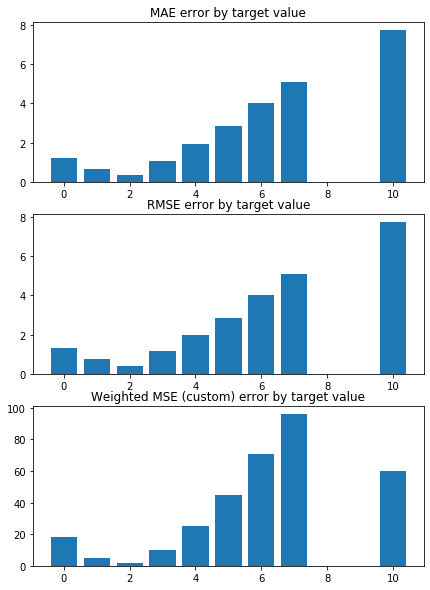

Weighted Mean squared error on Train: 1.15 
 MSE mean train: 2.4077287125026703 

Mean squared error on Test: 1.15 
 MSE mean test:  2.410720462302491 

Root of MSE on Test: 1.07 
 1.5526494975693939 

Variance score on Test: 0.06 
 r2_test: 0.18581202088075455 

wMSE_train 1.15
wMSE_test 1.15
MSE_train 2.41
MSE_test 2.41
MAE_train 1.08
MAE_test 1.06
r2_test 0.19
    H3K4me2   H3K4me1  H3K36me3      CTCF  RNA-polymerase-II     Chriz  CP190  \
0 -0.201623 -0.128855 -0.066197 -0.029647          -0.015793 -0.011066   -0.0   
1 -0.253458 -0.123316 -0.052215 -0.007814          -0.015372 -0.000000   -0.0   
2 -0.221651 -0.121337 -0.057404 -0.020914          -0.040725 -0.000000   -0.0   
3 -0.201668 -0.142779 -0.070159 -0.043462          -0.019377 -0.000000   -0.0   
4 -0.197389 -0.133157 -0.065613 -0.043367          -0.022127 -0.001002   -0.0   
5 -0.201347 -0.121375 -0.065848 -0.029778          -0.046274 -0.000000   -0.0   
6 -0.220886 -0.135869 -0.056634 -0.027379          -0.024804 -0.000

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


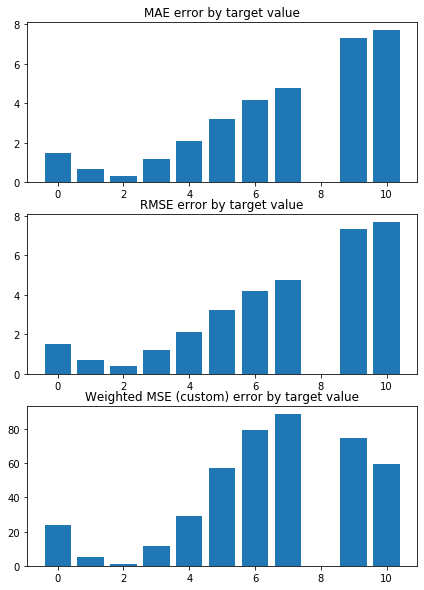

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3160390773345267 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3170368660915694 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


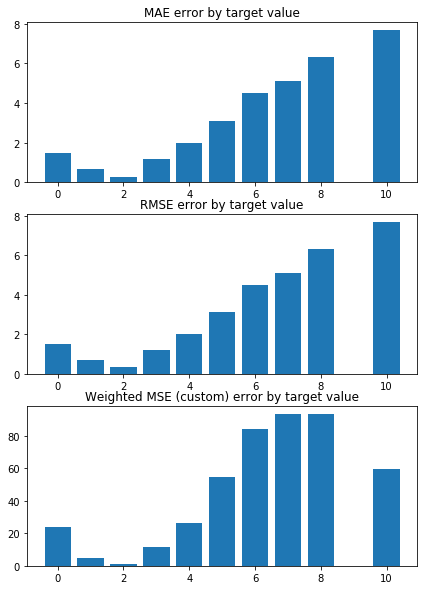

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2281315143488292 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3158610260560353 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


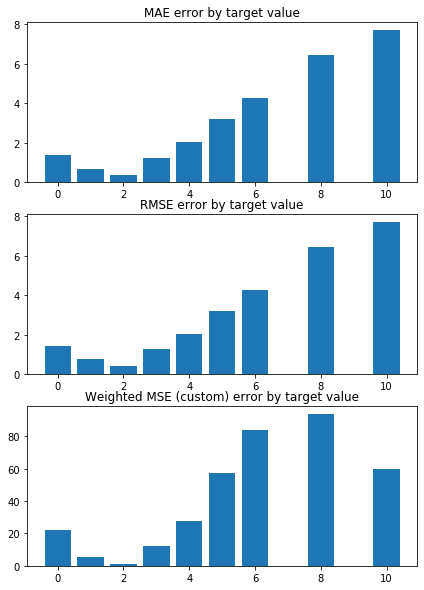

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.287493484047188 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2974362915281317 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


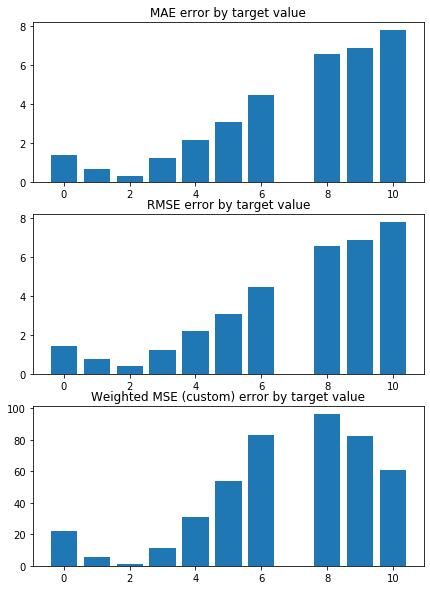

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3331546728968233 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3092919985528289 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


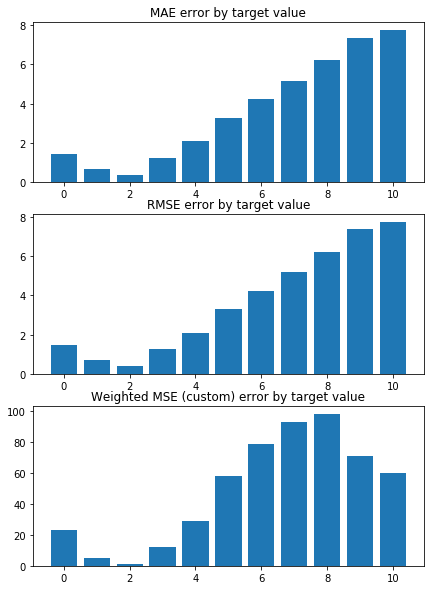

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2873194173732796 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3073399240356862 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


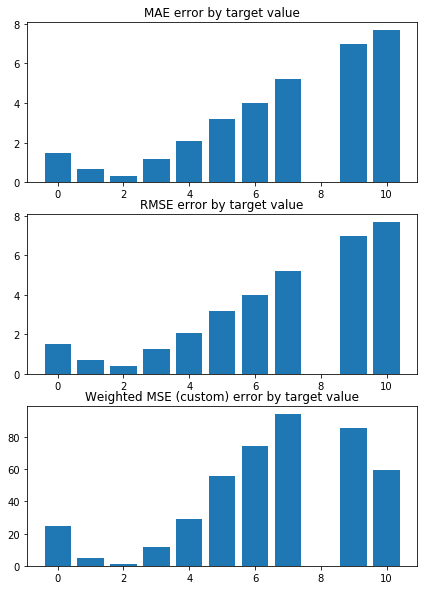

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2536660215661166 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3147598316352032 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


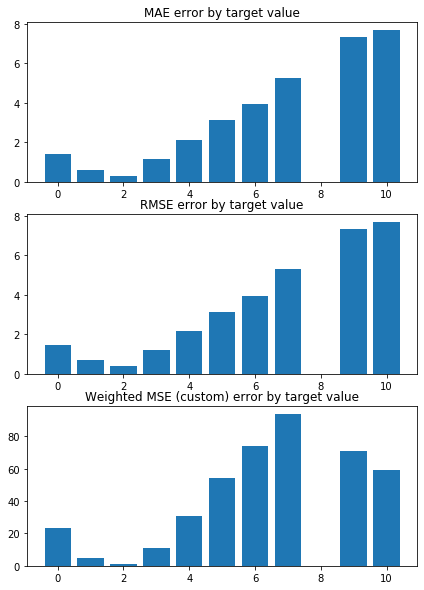

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3929667129026557 


 TRAIN PREDICTION Error
weighted_mse_train: 1.302209843115349 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


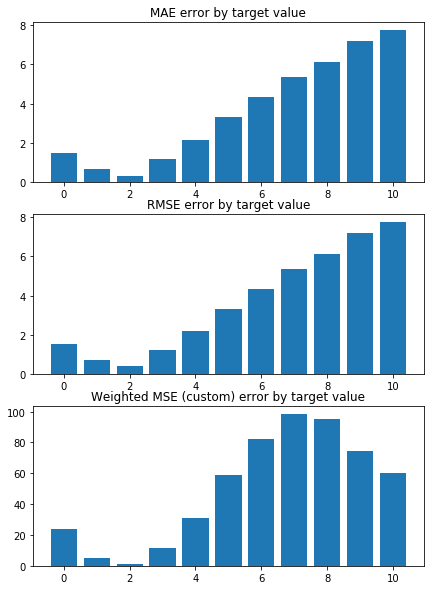

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4096904253898452 


 TRAIN PREDICTION Error
weighted_mse_train: 1.28644595787229 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


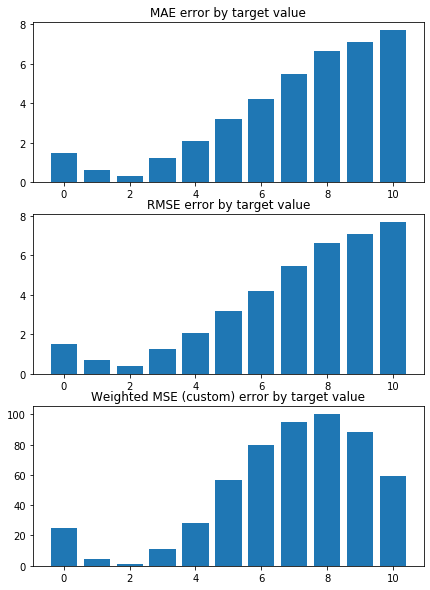

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2496568305330387 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3142764801557587 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


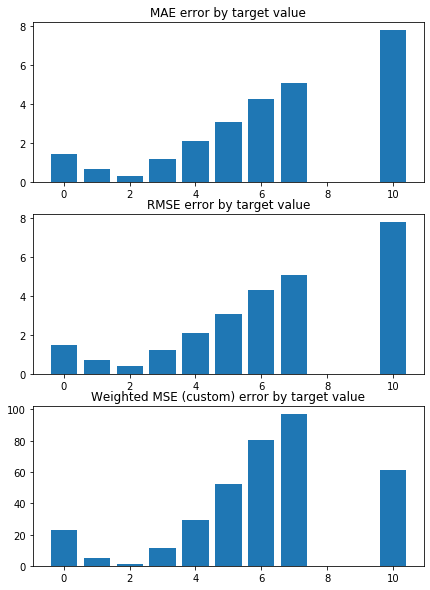

Weighted Mean squared error on Train: 1.31 
 MSE mean train: 2.651660901346319 

Mean squared error on Test: 1.31 
 MSE mean test:  2.6529001330837305 

Root of MSE on Test: 1.14 
 1.628772584826909 

Variance score on Test: 0.06 
 r2_test: 0.10305076553161738 

wMSE_train 1.31
wMSE_test 1.31
MSE_train 2.65
MSE_test 2.65
MAE_train 1.17
MAE_test 1.15
r2_test 0.1
    H3K4me2  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.202878   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
1 -0.211449   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
2 -0.216030   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
3 -0.224406   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
4 -0.211490   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
5 -0.217716   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
6 -0.217105   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


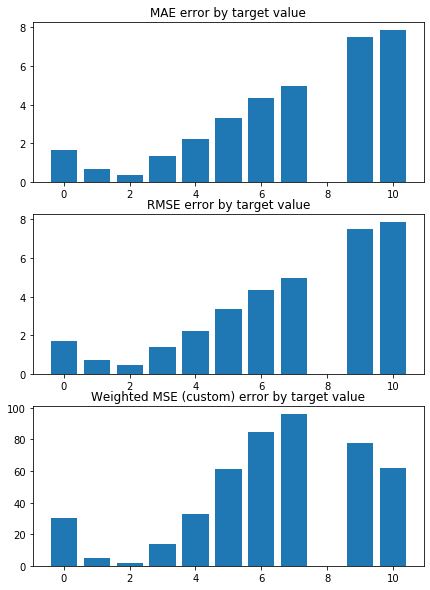

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5422317873347806 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5211177120331172 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


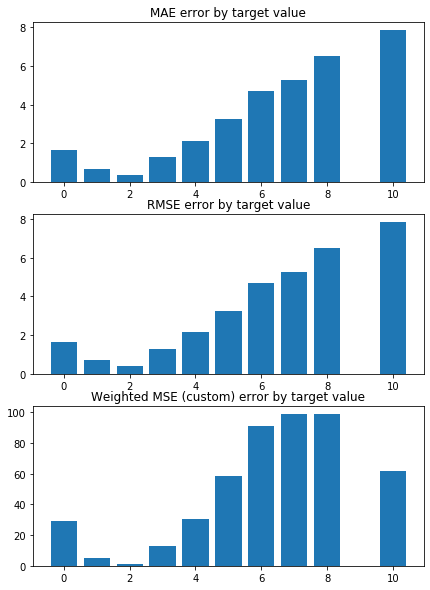

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4309392292266612 


 TRAIN PREDICTION Error
weighted_mse_train: 1.520222413001534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


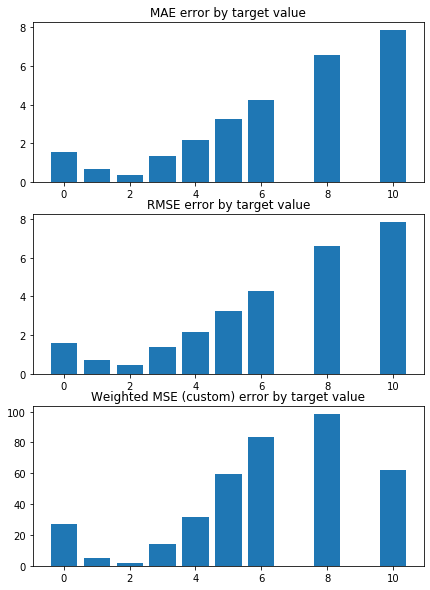

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4601077864036158 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4976821453513964 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


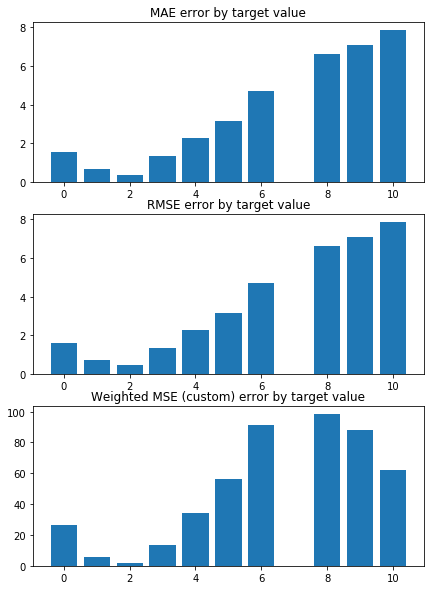

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5545984096138492 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5111649588503873 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


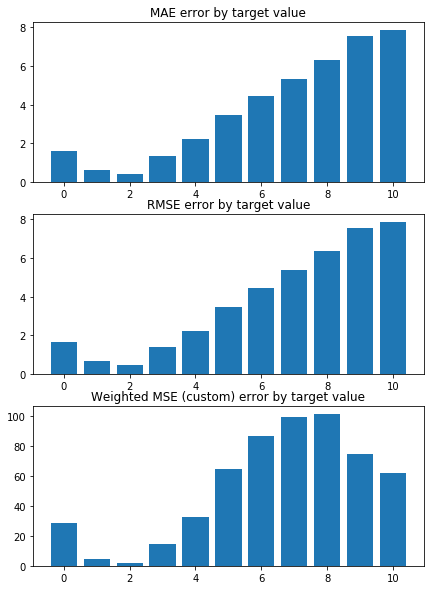

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4521363786900752 


 TRAIN PREDICTION Error
weighted_mse_train: 1.509801416788388 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


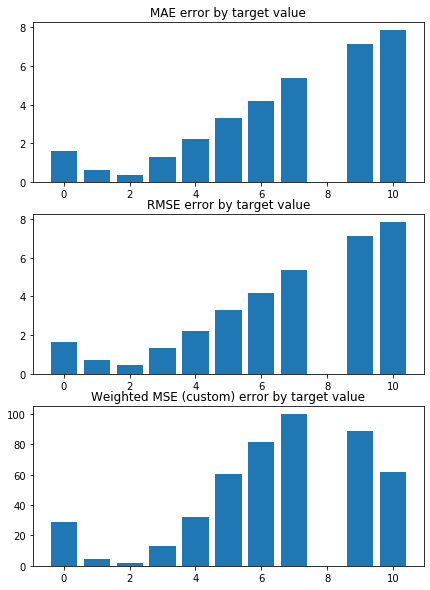

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.450308832265951 


 TRAIN PREDICTION Error
weighted_mse_train: 1.519574080699116 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


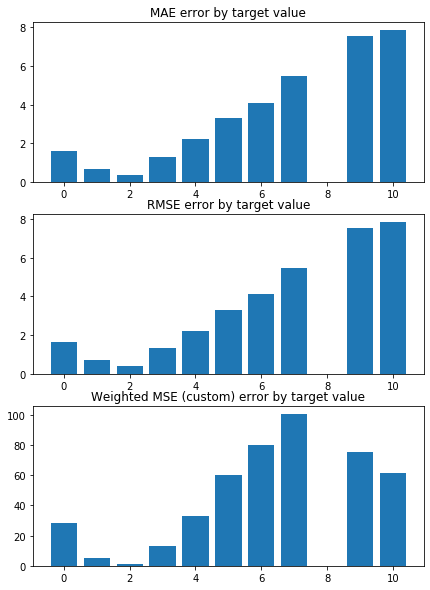

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6089792224561263 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5062382360970474 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


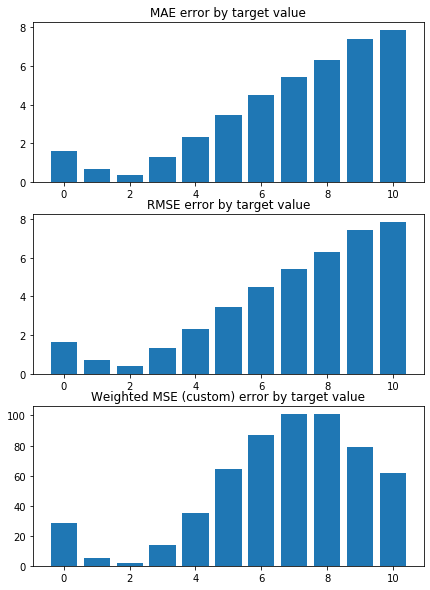

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5730747030163654 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4848776888579225 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


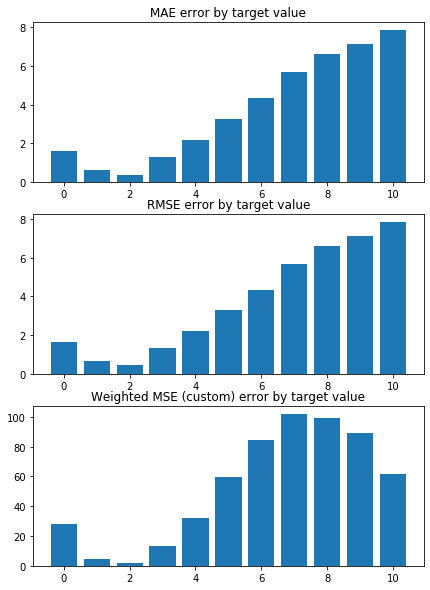

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4765403380045783 


 TRAIN PREDICTION Error
weighted_mse_train: 1.515531005220547 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


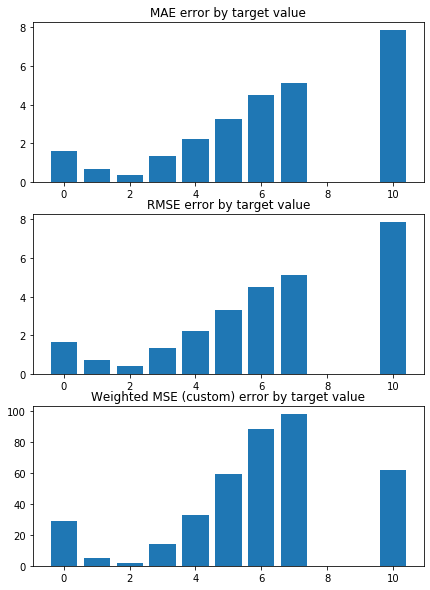

Weighted Mean squared error on Train: 1.51 
 MSE mean train: 2.9317024167899755 

Mean squared error on Test: 1.51 
 MSE mean test:  2.933357924146677 

Root of MSE on Test: 1.23 
 1.7127048561111389 

Variance score on Test: 0.06 
 r2_test: 0.007115246823823607 

wMSE_train 1.51
wMSE_test 1.51
MSE_train 2.93
MSE_test 2.93
MAE_train 1.26
MAE_test 1.25
r2_test 0.01
    H3K4me2  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.001999   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
1 -0.010144   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
2 -0.014530   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
3 -0.025744   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
4 -0.011302   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
5 -0.019889   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
6 -0.016637   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


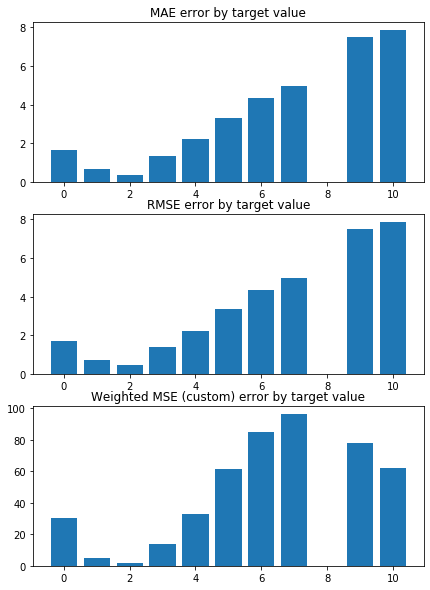

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


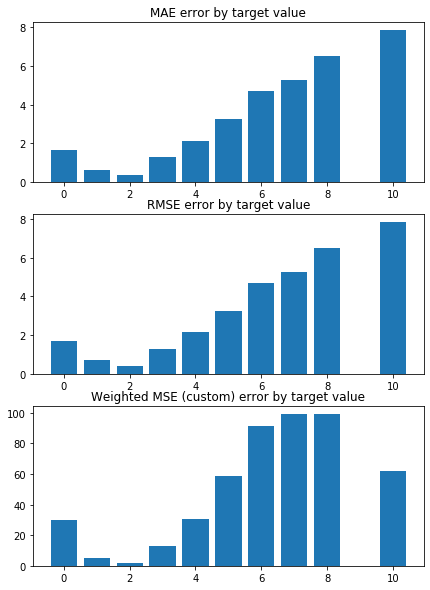

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


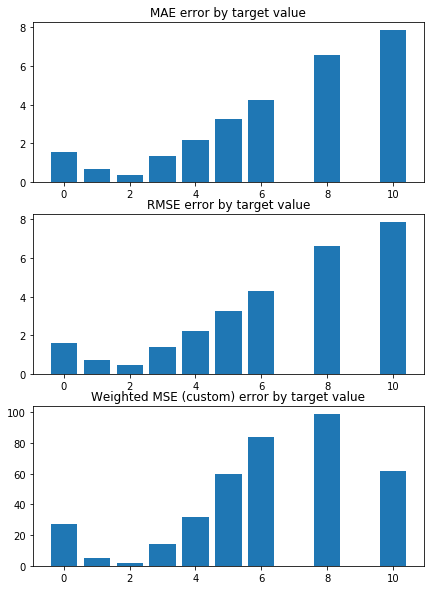

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


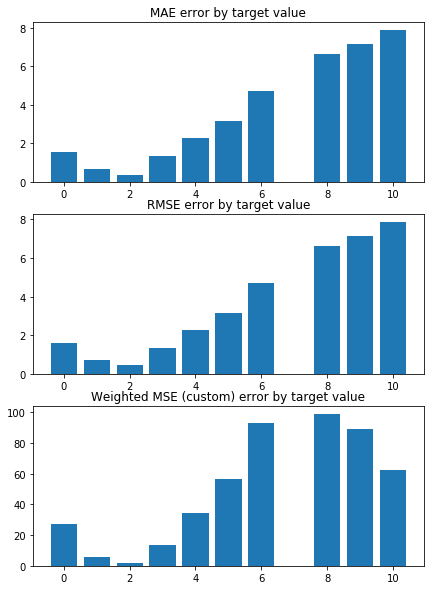

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


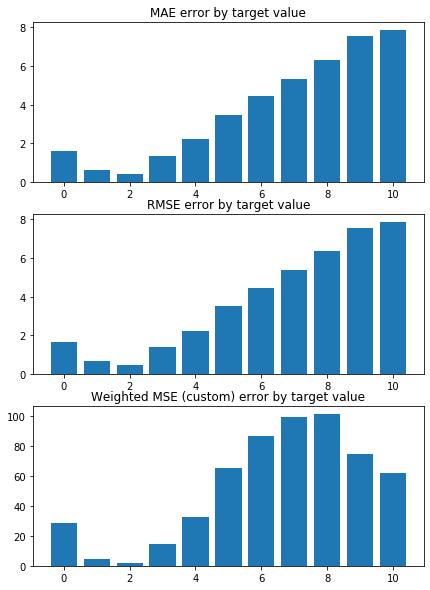

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


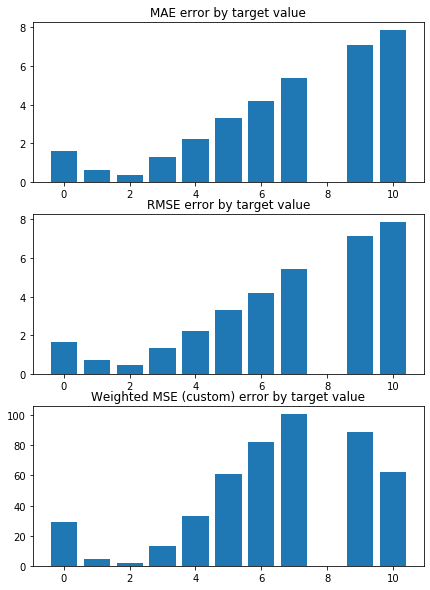

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


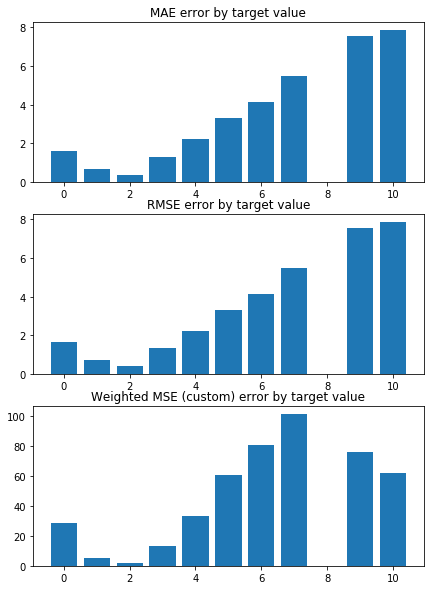

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


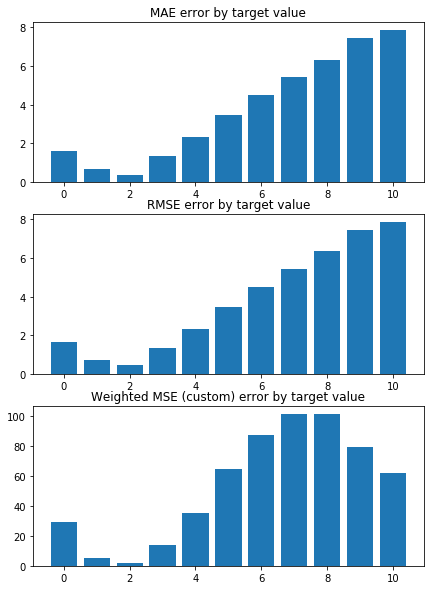

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


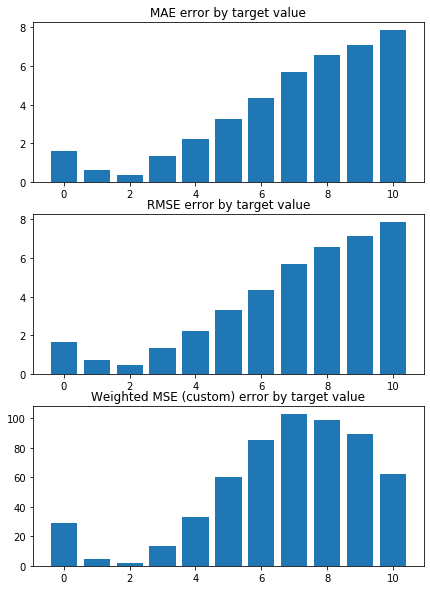

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


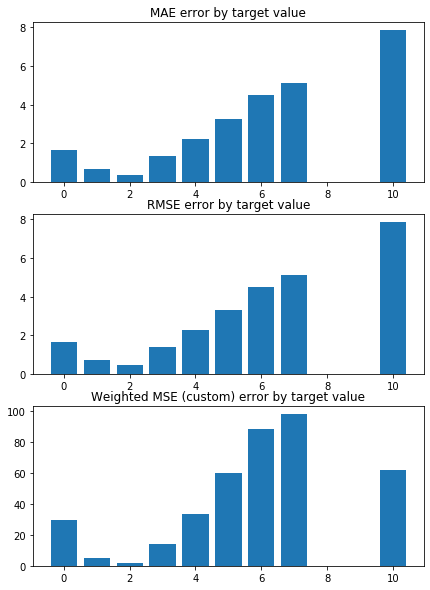

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


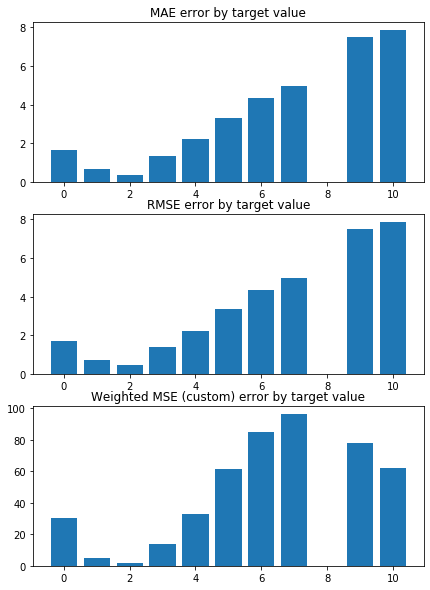

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


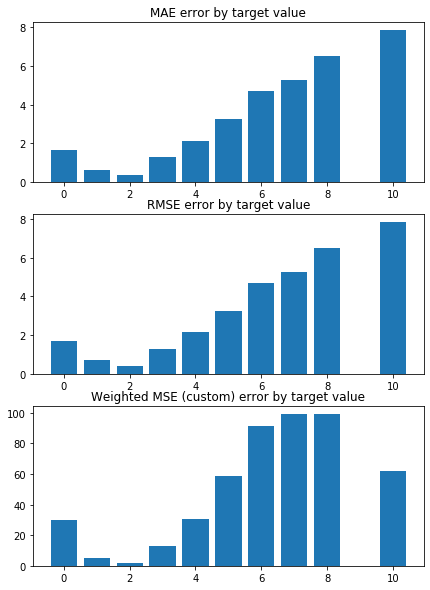

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


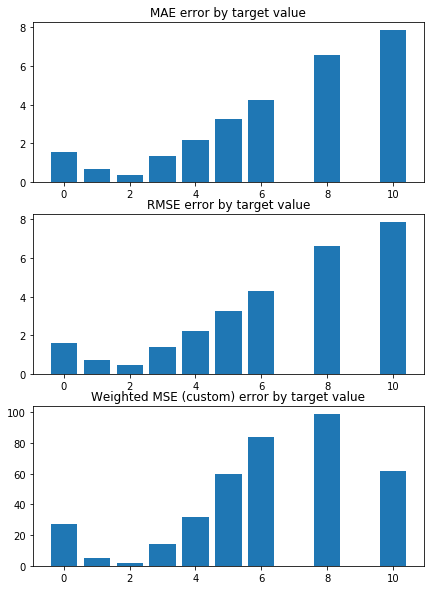

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


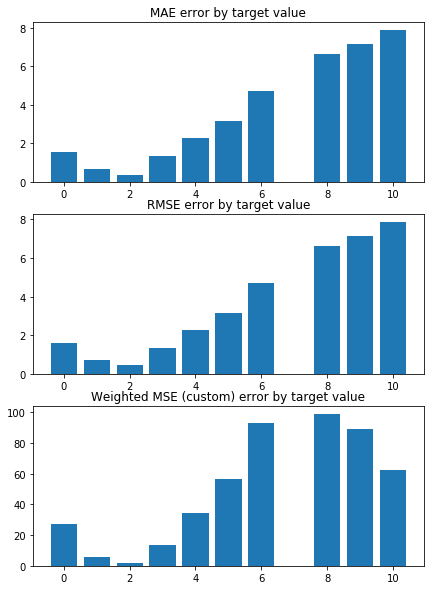

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


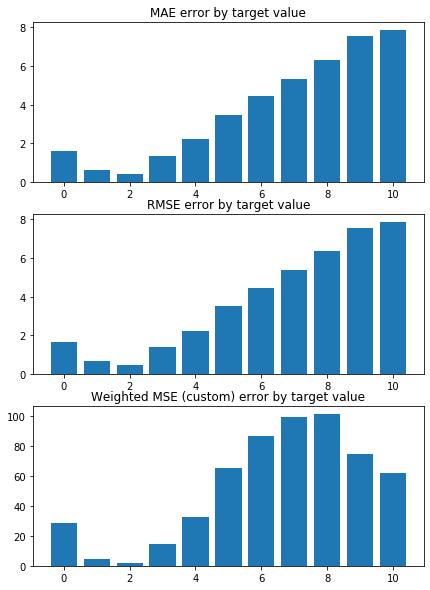

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


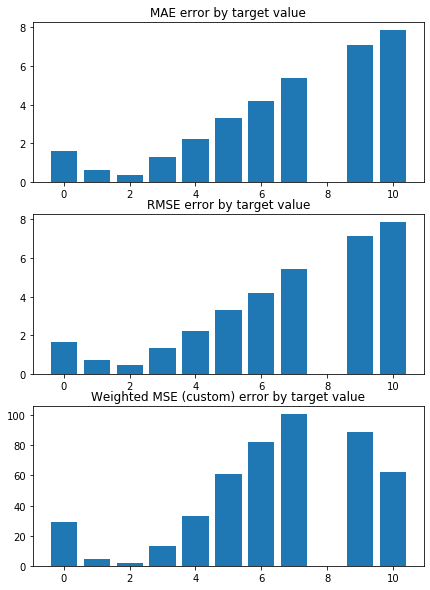

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


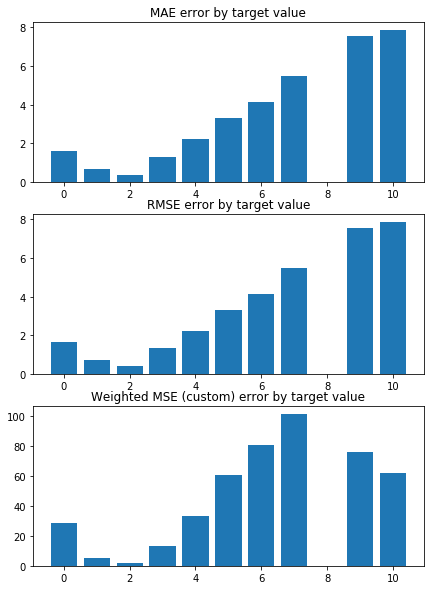

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


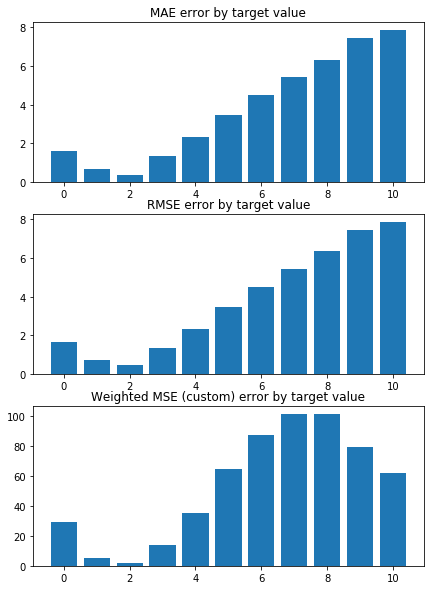

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


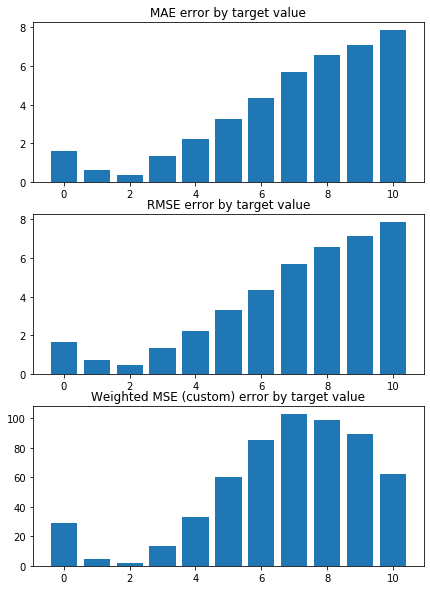

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


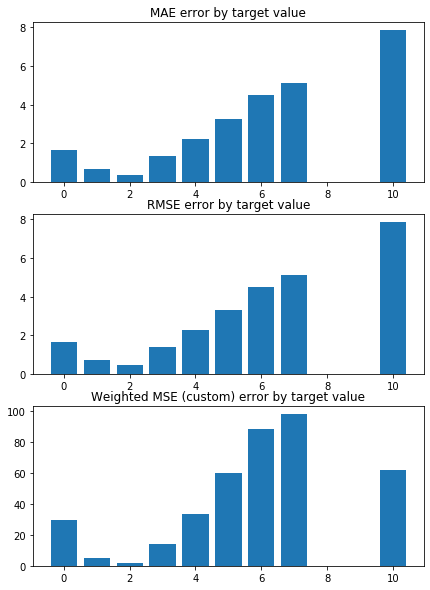

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


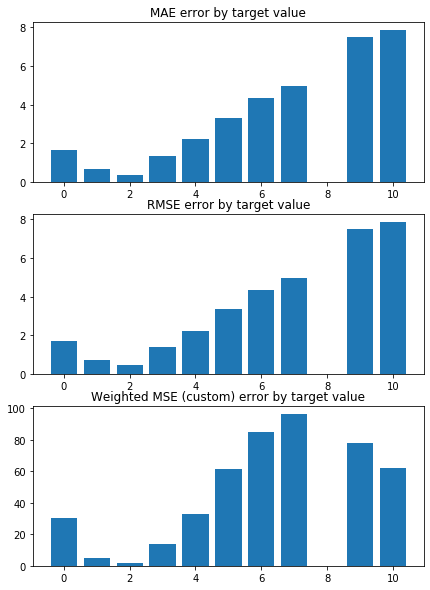

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


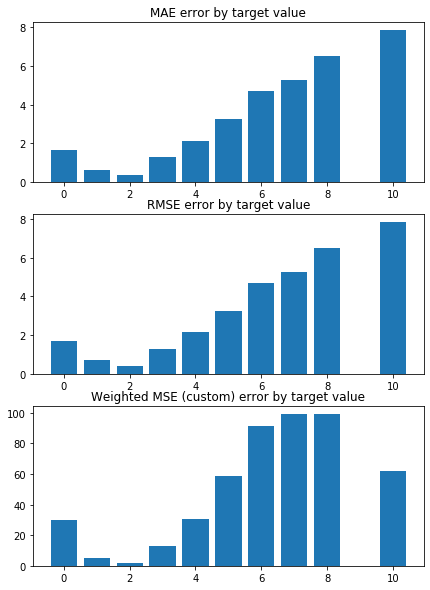

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


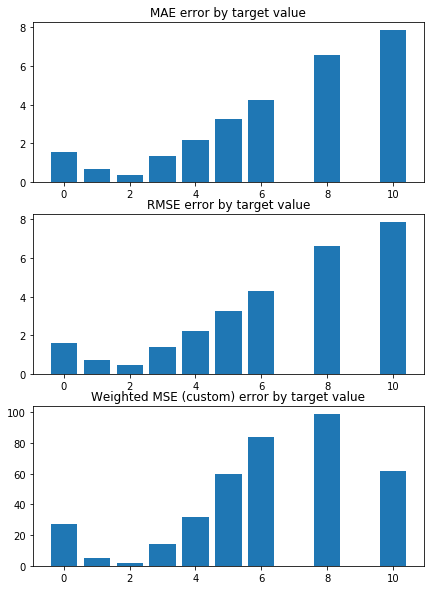

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


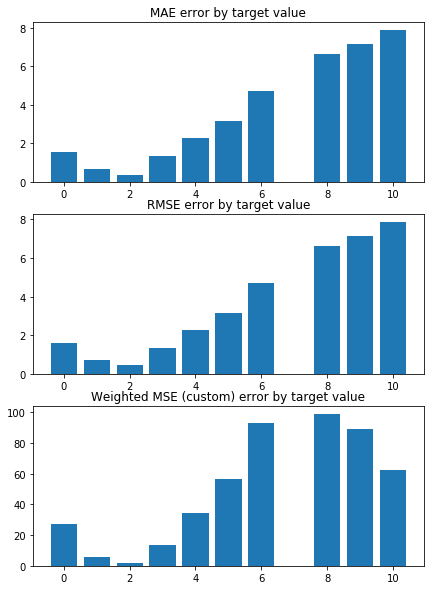

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


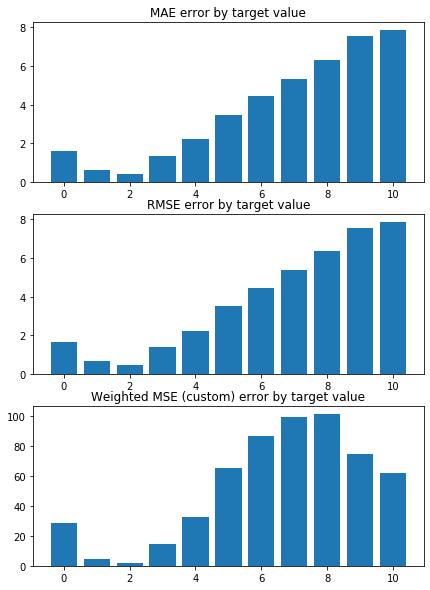

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


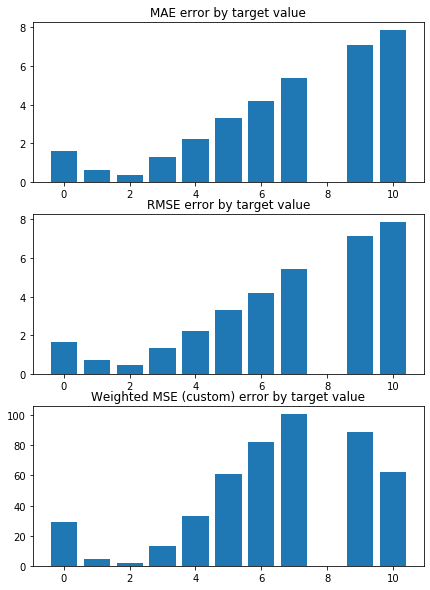

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


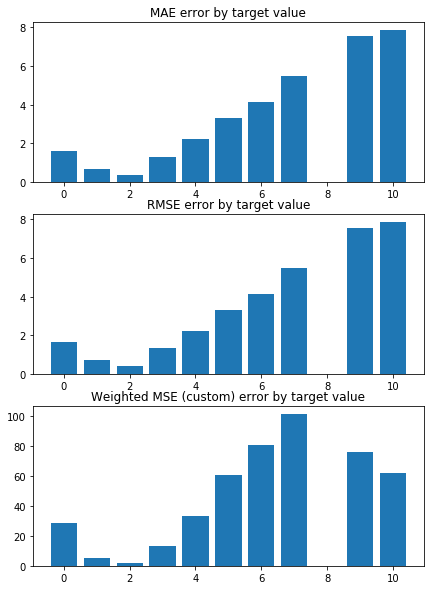

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


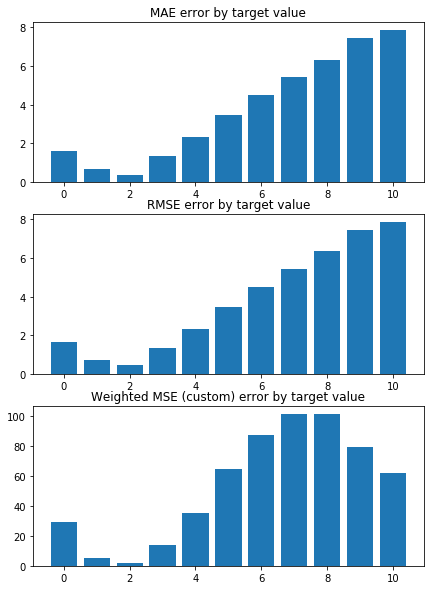

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


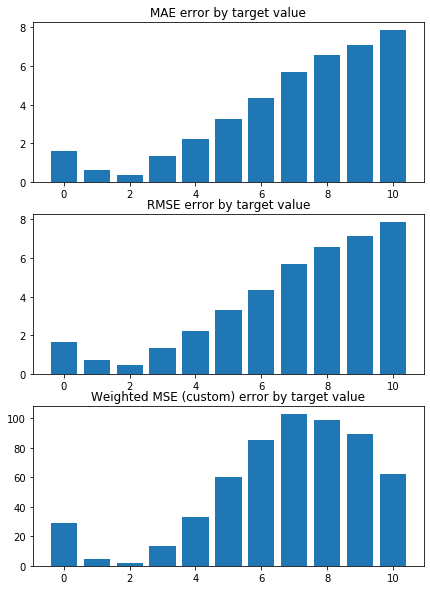

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


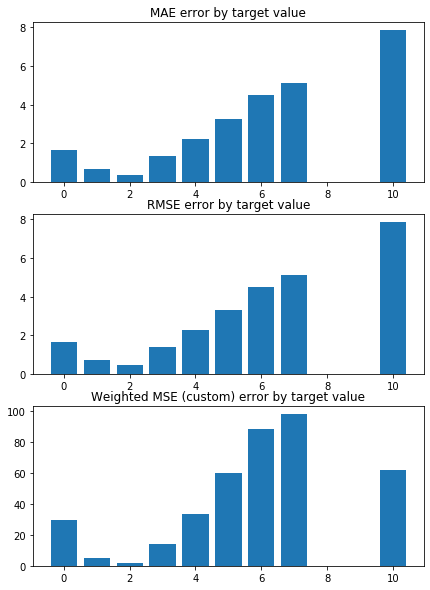

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


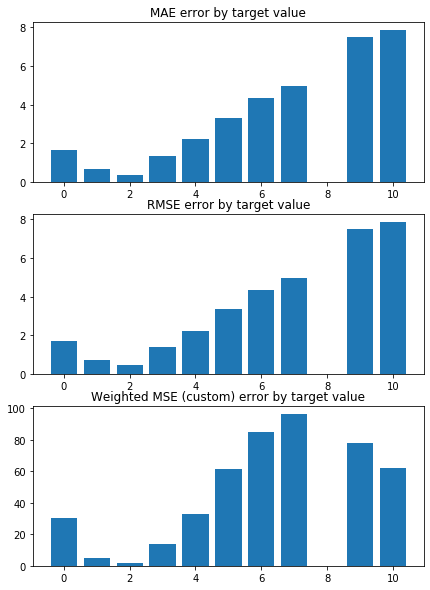

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


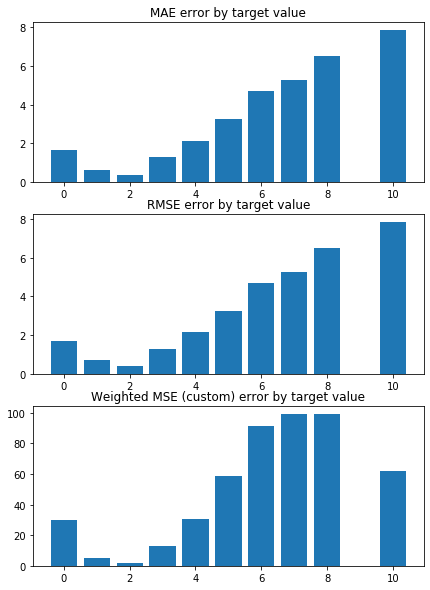

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


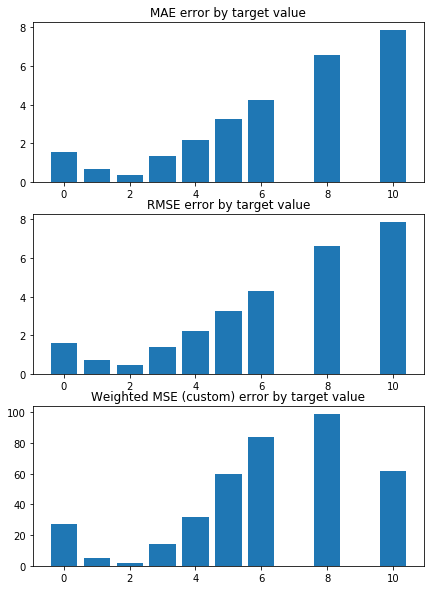

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


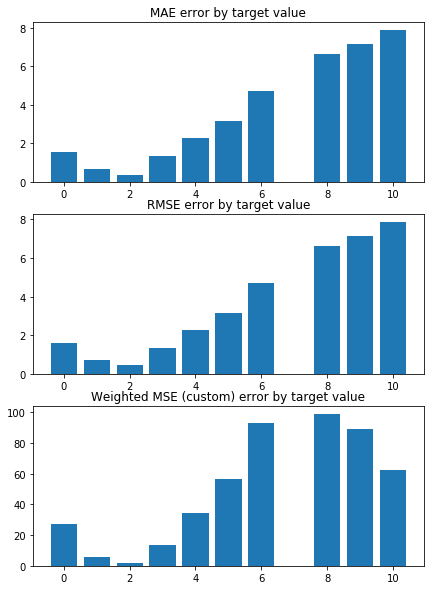

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


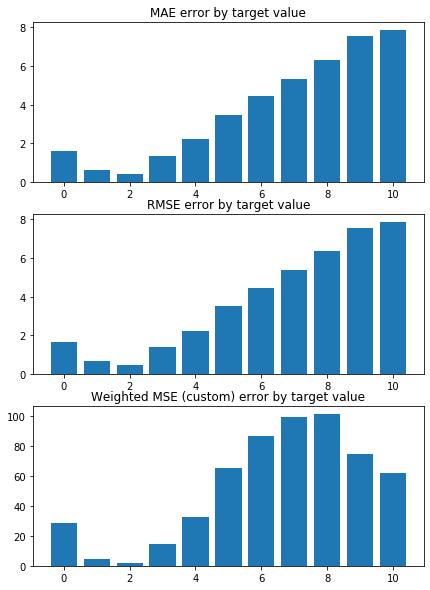

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


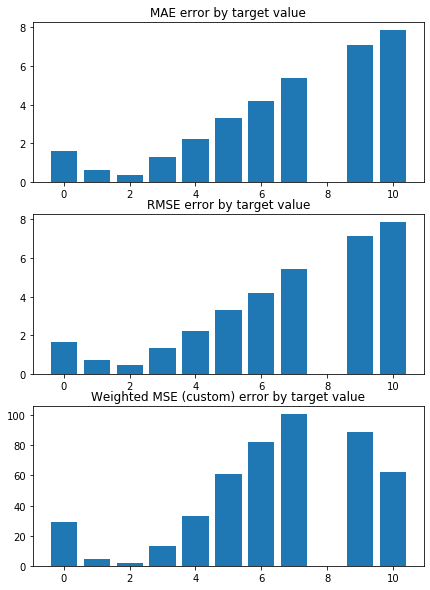

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


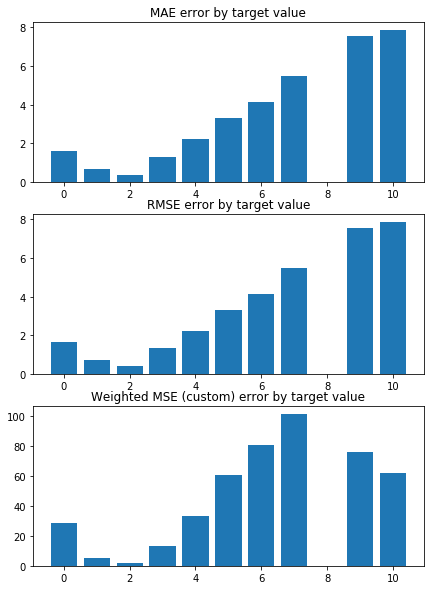

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


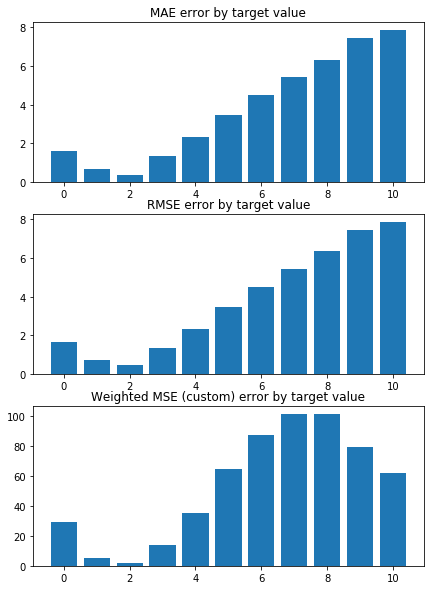

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


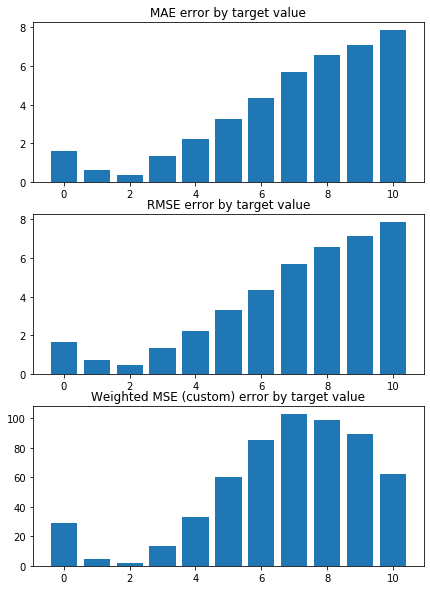

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


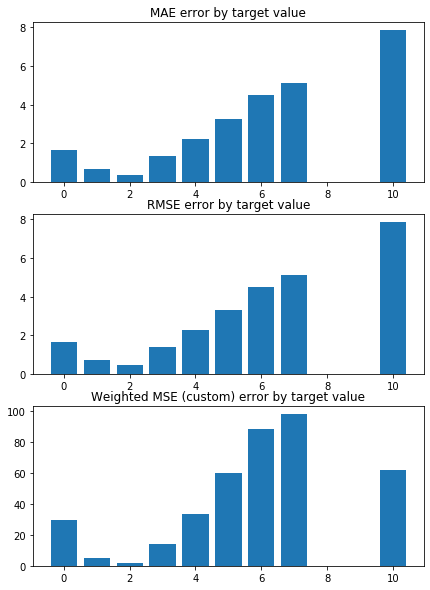

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


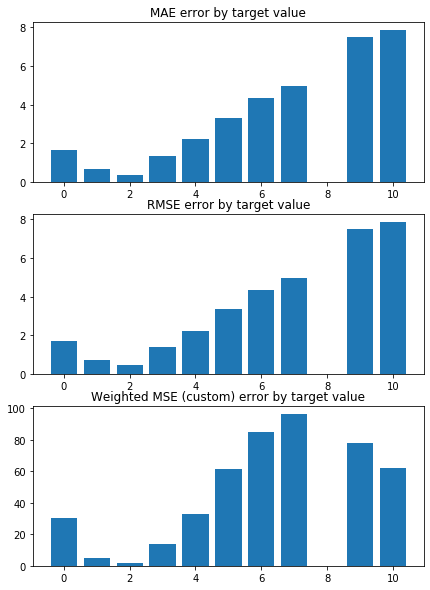

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


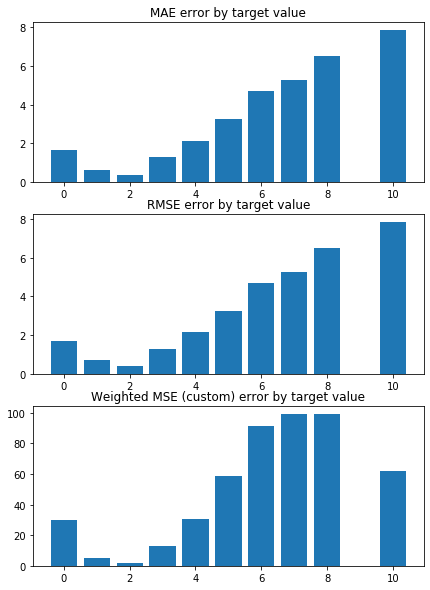

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


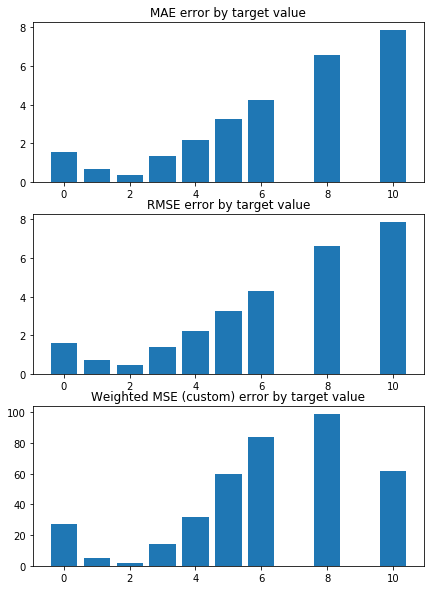

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


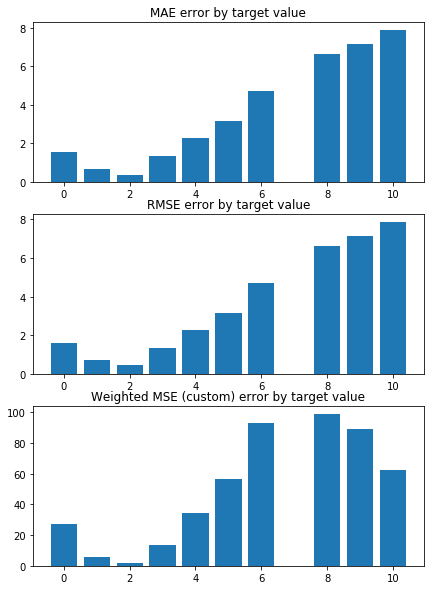

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


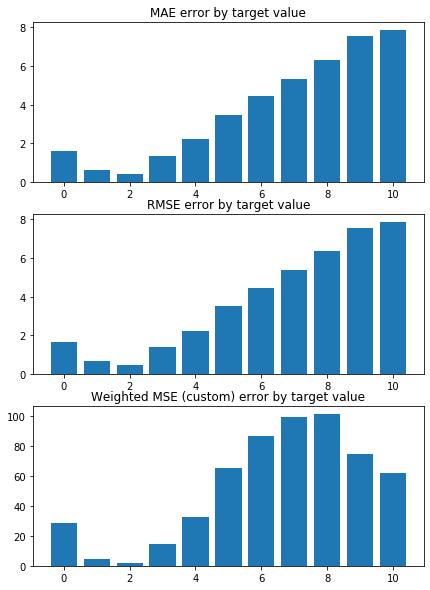

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


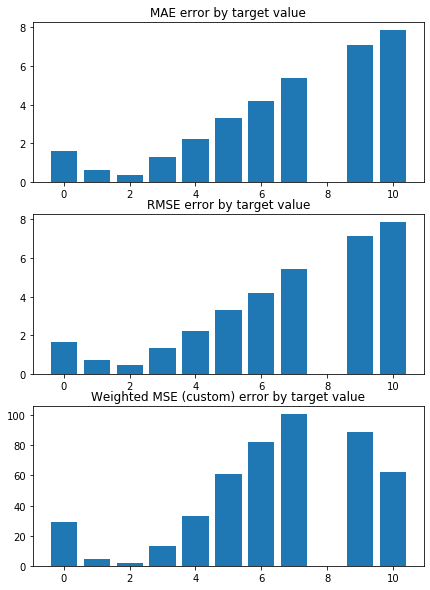

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


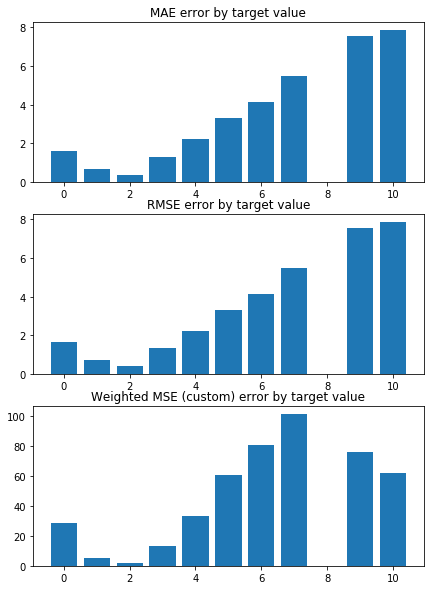

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


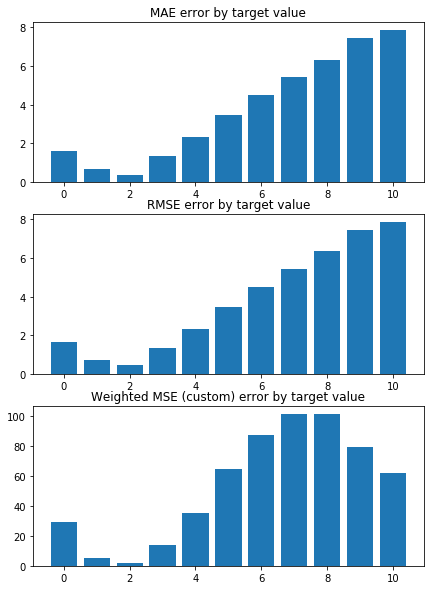

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


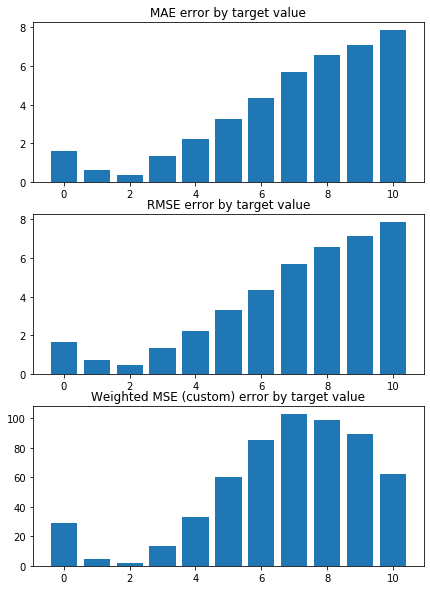

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


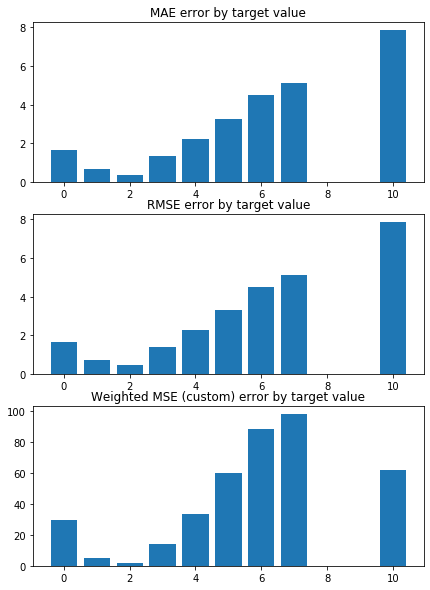

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

In [78]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 2, 0.2)
# Create linear regression object

model_name = 'LR+L1_grid'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

for alpha in alpha_grid:
    model = linear_model.Lasso(alpha=alpha)

    

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    _ = train_test_KFold(X, y, 
                                                  model, model_name, results_pd,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)
#     results_pd
    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))


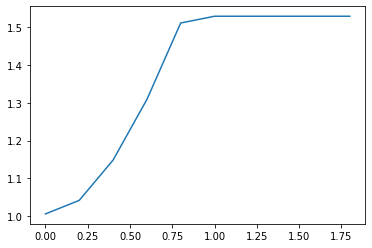

In [79]:
plt.plot(alpha_grid, wmse_test)

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9207946942169193 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5580.177460787563, tolerance: 1.5753001672530345
  positive)


weighted_mse_train: 1.0052947139708956 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5729131802711864
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


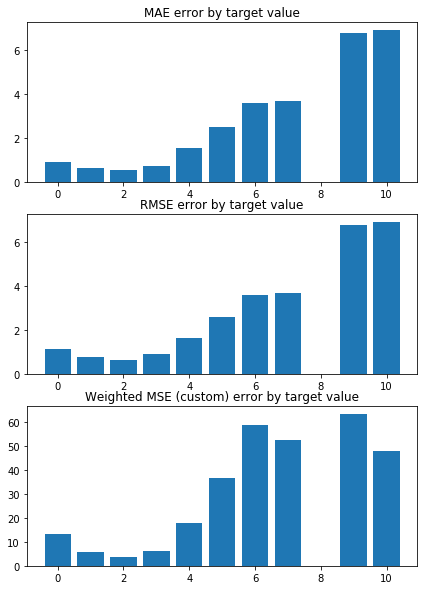

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9636326385609956 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0099787415726738 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5642.099775947289, tolerance: 1.5951549408328658
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

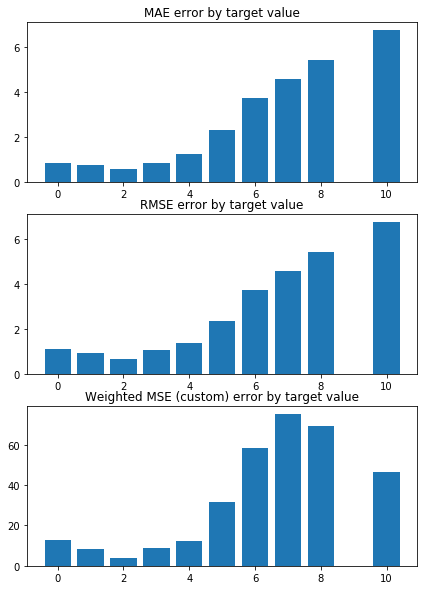

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.989910864376035 


 TRAIN PREDICTION Error
weighted_mse_train: 1.002807087758519 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5532.50200380008, tolerance: 1.5821769354883282
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

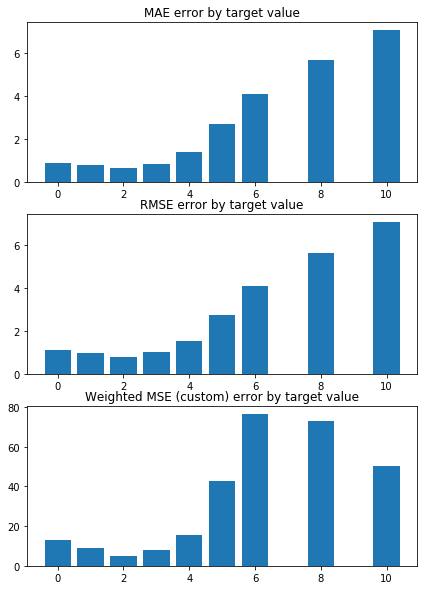

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0598734779663155 


 TRAIN PREDICTION Error
weighted_mse_train: 0.990317099143811 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5397.309586260339, tolerance: 1.5581200225471517
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

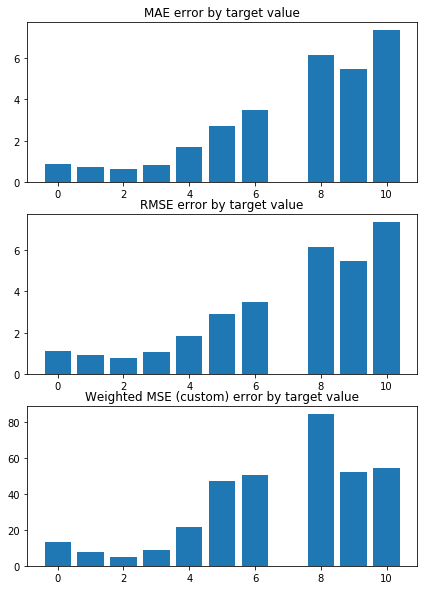

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9824384756274219 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0024322848365612 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5667.20763820735, tolerance: 1.6044926244369746
  positive)


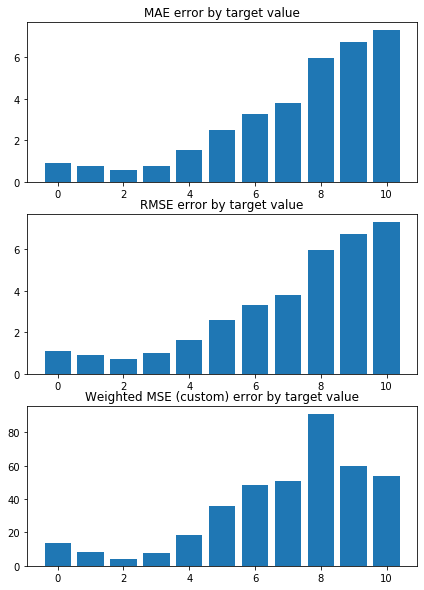

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0740254359296069 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9922696897589997 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5458.75007140212, tolerance: 1.5618709890457518
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

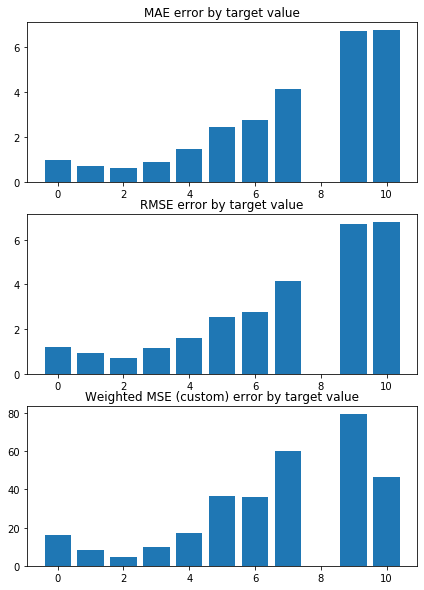

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9798771329490155 


 TRAIN PREDICTION Error
weighted_mse_train: 1.003102232996511 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5641.873242432553, tolerance: 1.6006251832941174
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

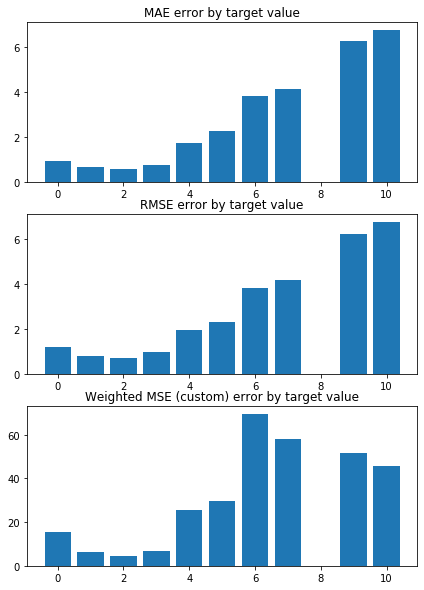

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.0658030282478732 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9941128509507394 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5593.180610592562, tolerance: 1.591772067394958
  positive)


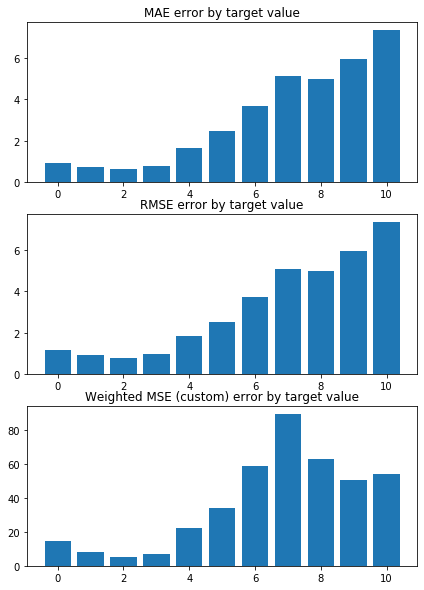

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0846201555666581 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9875771971303583 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522.002913154479, tolerance: 1.5756948114957992
  positive)


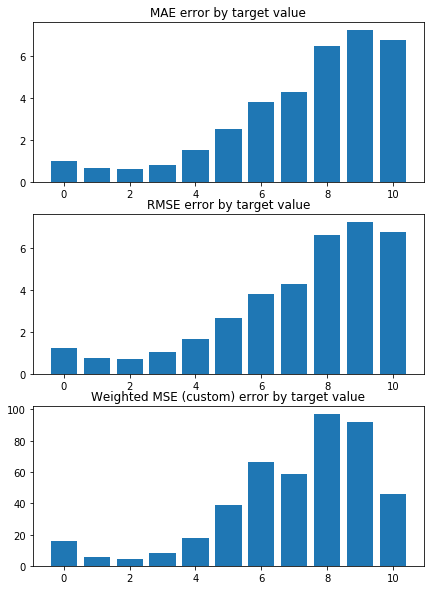

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9338448457390943 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0081880474285914 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5570.801070483486, tolerance: 1.5896707153314662
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

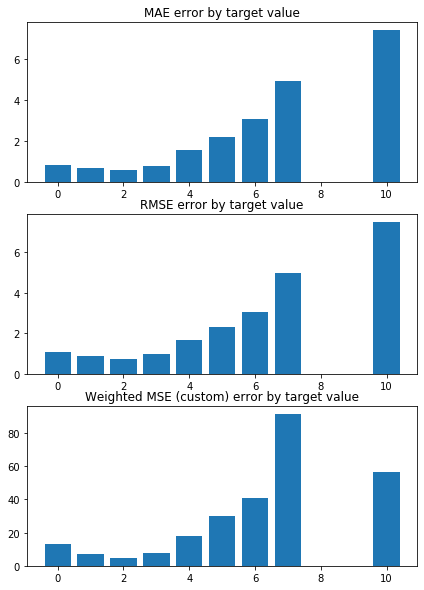

Weighted Mean squared error on Train: 1.00 
 MSE mean train: 2.076784477052019 

Mean squared error on Test: 1.01 
 MSE mean test:  2.0900530792800787 

Root of MSE on Test: 1.00 
 1.445701587216421 

Variance score on Test: 0.06 
 r2_test: 0.29487189677420245 

wMSE_train 1.0
wMSE_test 1.01
MSE_train 2.08
MSE_test 2.09
MAE_train 0.97
MAE_test 0.93
r2_test 0.29
   H3K36me3   H4K16ac   H3K4me1       GAF  H3K36me1    Su(Hw)   H3K4me3  \
0 -0.577725  0.383409 -0.359466 -0.290118 -0.286989  0.168162 -0.164325   
1 -0.616361  0.419153 -0.336181 -0.275444 -0.314071  0.151599 -0.146317   
2 -0.597374  0.407324 -0.344197 -0.311805 -0.323021  0.160319 -0.197146   
3 -0.594079  0.389974 -0.376728 -0.274175 -0.282688  0.161526 -0.129869   
4 -0.612782  0.394975 -0.323170 -0.292868 -0.313231  0.168017 -0.127444   
5 -0.580190  0.362782 -0.338988 -0.290572 -0.292281  0.184178 -0.127902   
6 -0.589758  0.401186 -0.357072 -0.285514 -0.280753  0.178384 -0.190846   
7 -0.567009  0.402720 -0.371730 -0.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


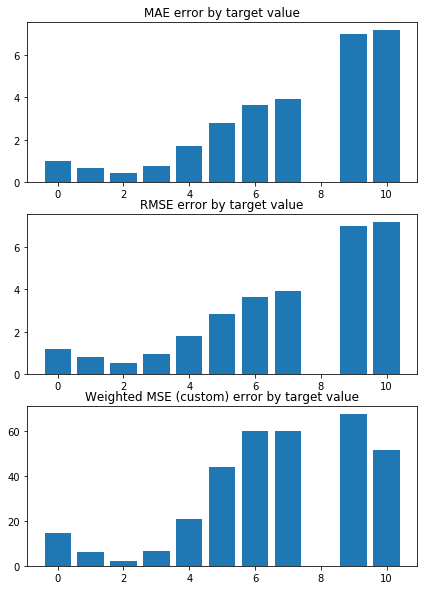

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9604930008340749 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0298745683727086 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


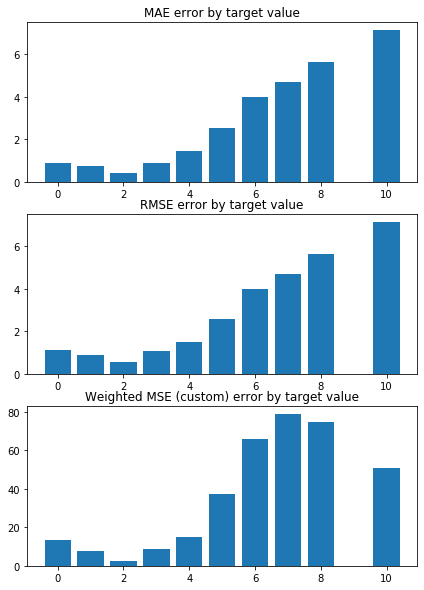

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9799820233886389 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0210689645933306 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


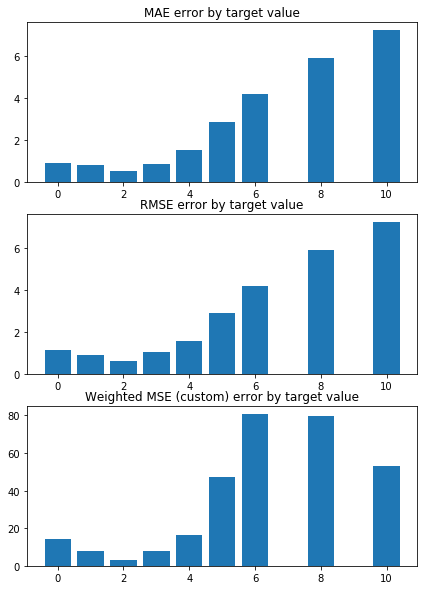

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0740474839139504 


 TRAIN PREDICTION Error
weighted_mse_train: 1.009658392468105 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


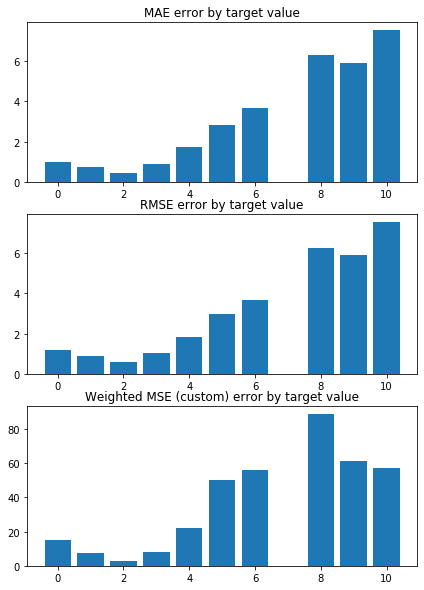

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9996149290648112 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0211050930233507 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


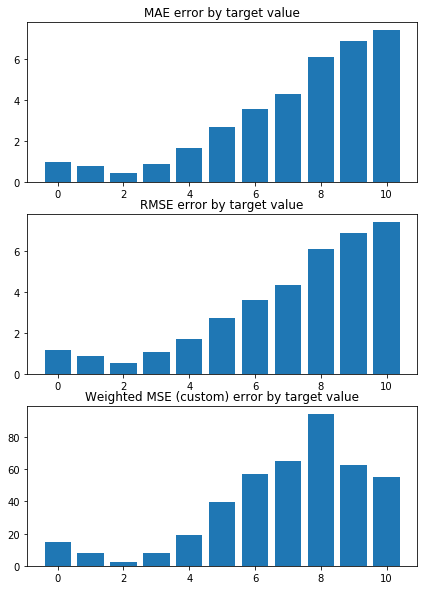

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0740740721069615 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0106491681447196 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


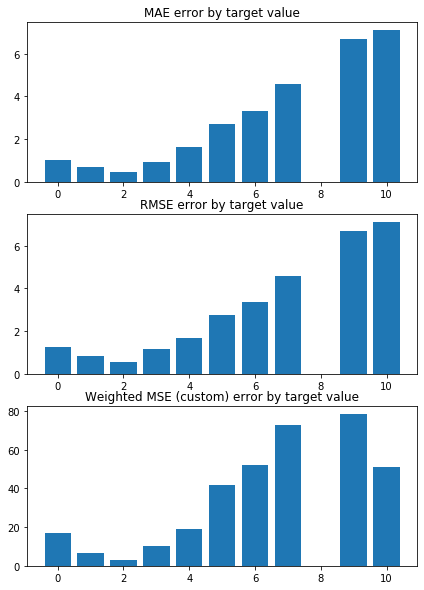

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0024026341244614 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0201558690158385 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


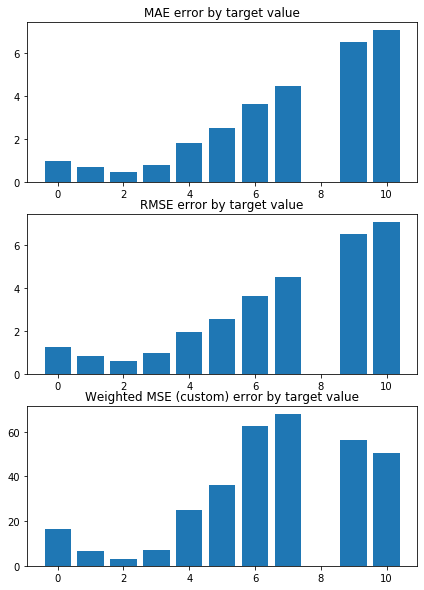

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.0888996907245196 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0096704075485865 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


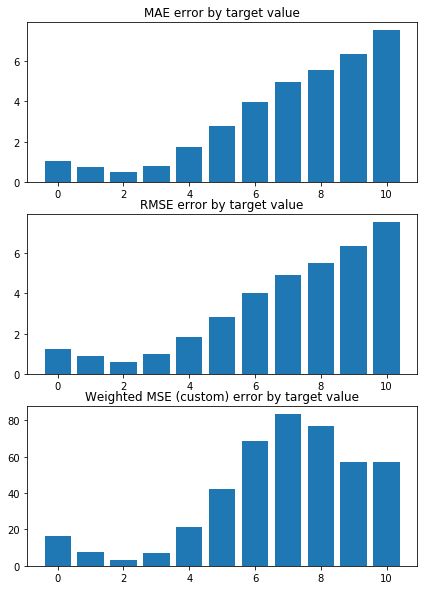

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1204286202468279 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0046943194113234 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


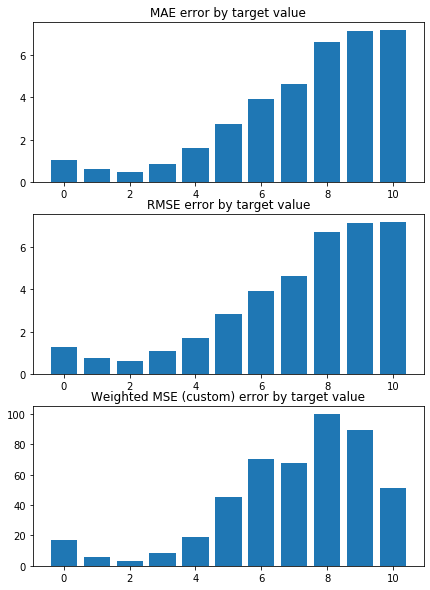

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9216979399688069 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0245252894879202 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


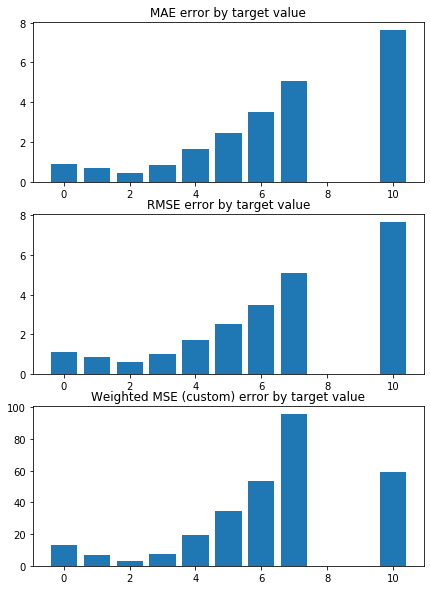

Weighted Mean squared error on Train: 1.02 
 MSE mean train: 2.1680208099612237 

Mean squared error on Test: 1.02 
 MSE mean test:  2.1724563832382824 

Root of MSE on Test: 1.01 
 1.473925501251092 

Variance score on Test: 0.06 
 r2_test: 0.26728091513133423 

wMSE_train 1.02
wMSE_test 1.02
MSE_train 2.17
MSE_test 2.17
MAE_train 0.98
MAE_test 0.94
r2_test 0.27
    H3K4me1  H3K36me3     Chriz       GAF      CTCF    Su(Hw)  H3K36me1  \
0 -0.395114 -0.256500 -0.102675 -0.093506 -0.090768  0.005222      -0.0   
1 -0.418879 -0.259169 -0.082969 -0.086935 -0.098880  0.000000      -0.0   
2 -0.414282 -0.266115 -0.090573 -0.115641 -0.079657  0.000000      -0.0   
3 -0.417338 -0.269892 -0.079086 -0.080879 -0.108620  0.003624      -0.0   
4 -0.406934 -0.257776 -0.102227 -0.089113 -0.090294  0.001444      -0.0   
5 -0.404516 -0.258463 -0.106891 -0.088229 -0.086271  0.015769      -0.0   
6 -0.414631 -0.265092 -0.081708 -0.089638 -0.099722  0.010862      -0.0   
7 -0.406579 -0.261777 -0.096737 -0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


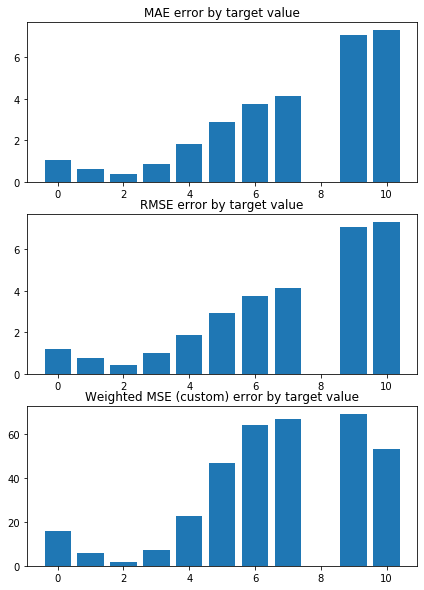

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9935001919466534 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0515745894171775 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


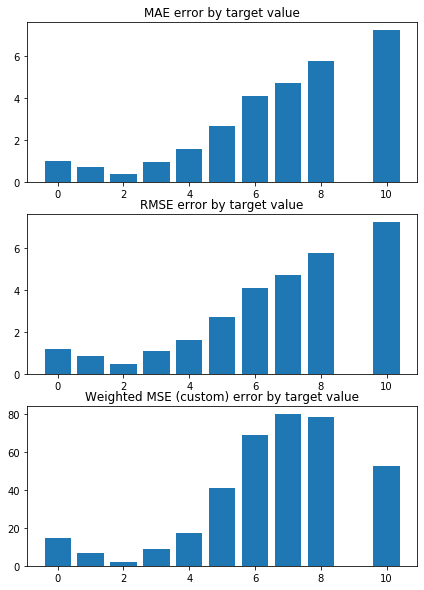

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.980940070835858 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0417681848630542 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


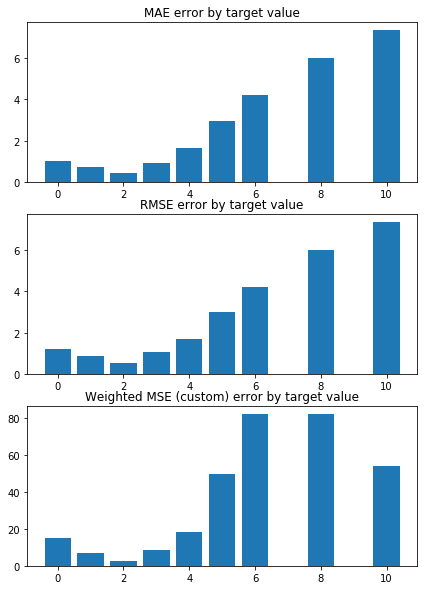

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0828687012326546 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0305134361001704 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


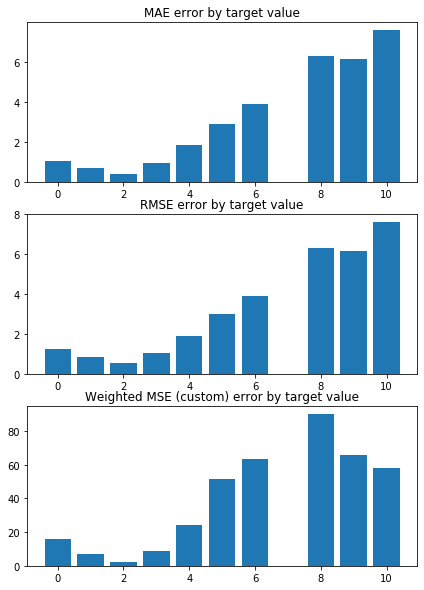

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0329019659936711 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0406686442003947 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


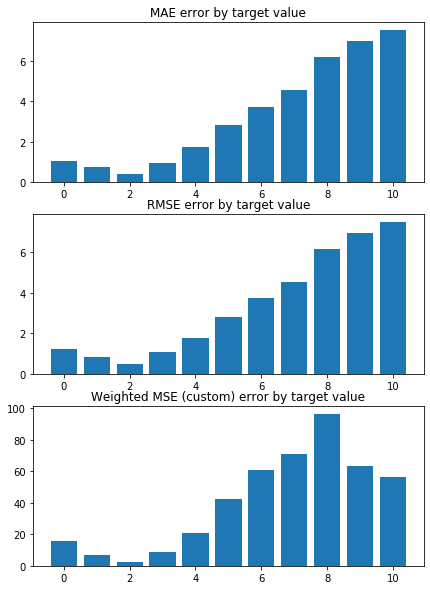

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0840870512808882 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0346174005574384 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


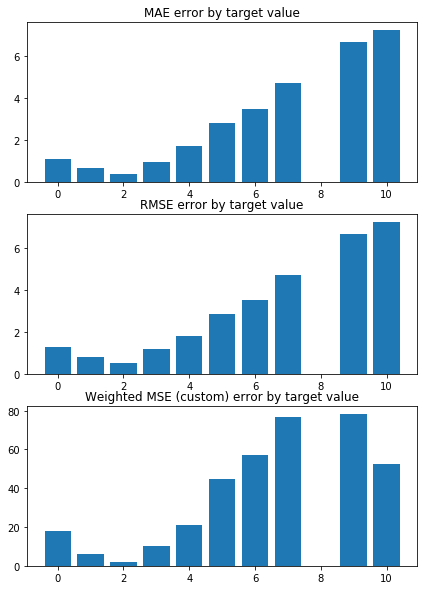

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0185158828873673 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0437306390734131 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


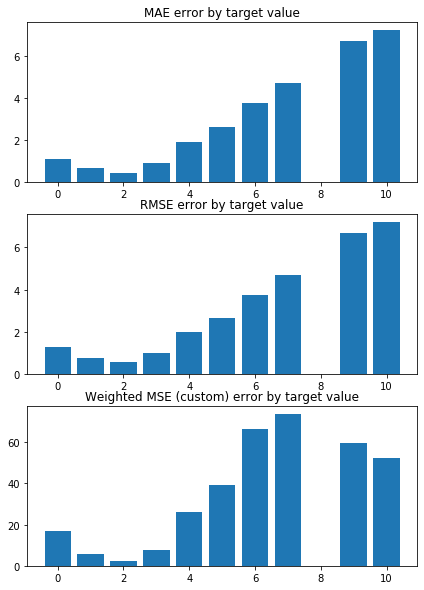

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1150508228728686 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0319821971942589 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


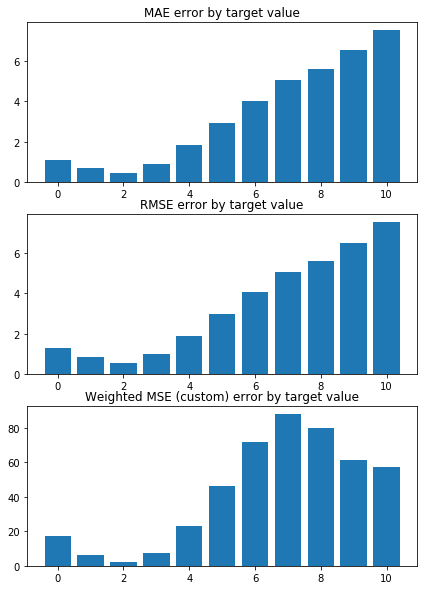

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1487508717068227 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0261687385116758 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


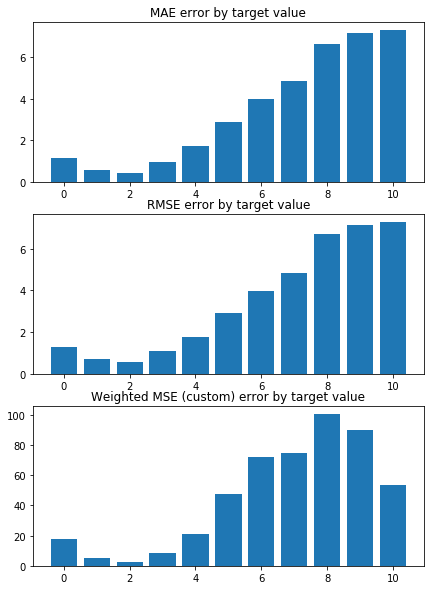

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9500278664083303 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0464561293785304 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


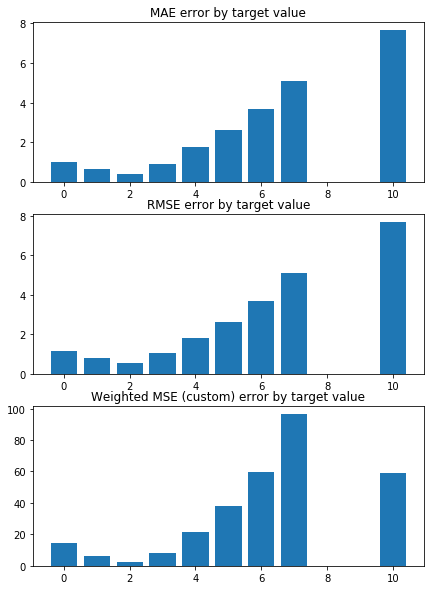

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.222527498822653 

Mean squared error on Test: 1.04 
 MSE mean test:  2.227074987703675 

Root of MSE on Test: 1.02 
 1.492338764390872 

Variance score on Test: 0.06 
 r2_test: 0.24863487729102599 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.22
MSE_test 2.23
MAE_train 1.01
MAE_test 0.97
r2_test 0.25
    H3K4me1  H3K36me3     Chriz      CTCF       GAF   H3K4me2  H3K36me1  \
0 -0.339689 -0.194040 -0.106285 -0.084132 -0.024967 -0.016885      -0.0   
1 -0.332580 -0.189499 -0.063467 -0.083322 -0.023082 -0.074374      -0.0   
2 -0.333473 -0.198546 -0.073950 -0.072052 -0.051764 -0.053186      -0.0   
3 -0.352891 -0.205052 -0.076430 -0.104015 -0.013177 -0.030122      -0.0   
4 -0.351794 -0.195974 -0.104568 -0.088609 -0.021992 -0.011172      -0.0   
5 -0.344789 -0.194875 -0.108205 -0.081920 -0.012296 -0.024450      -0.0   
6 -0.342733 -0.195608 -0.075043 -0.089923 -0.017596 -0.053528      -0.0   
7 -0.349698 -0.197779 -0.098954 -0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


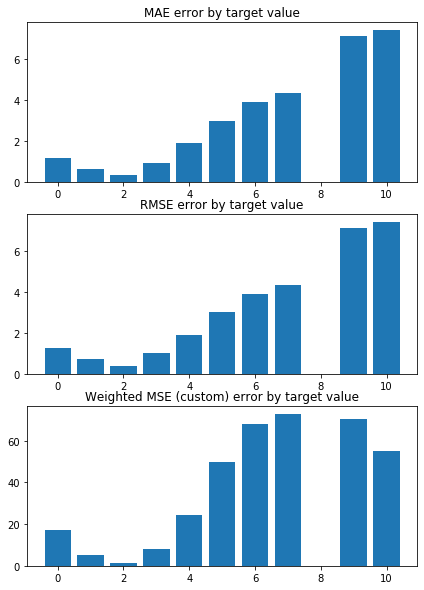

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0543269285081962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.096153337790733 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


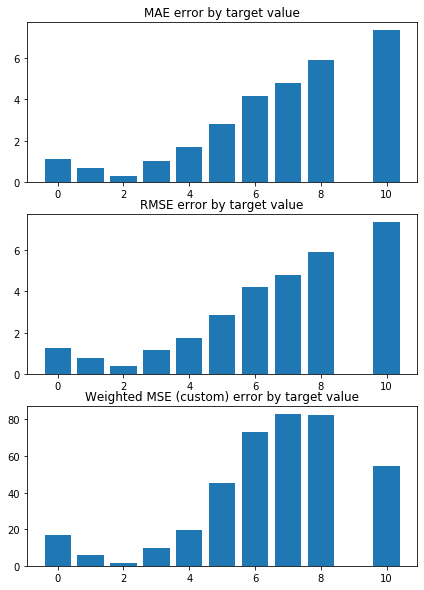

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.01323244266949 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0902128922053202 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


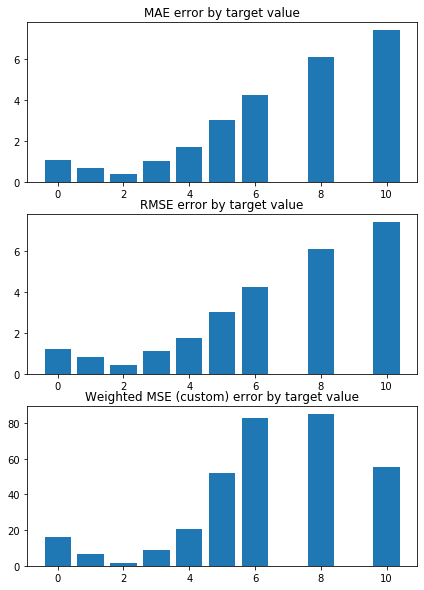

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.110826378587532 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0716187048366612 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


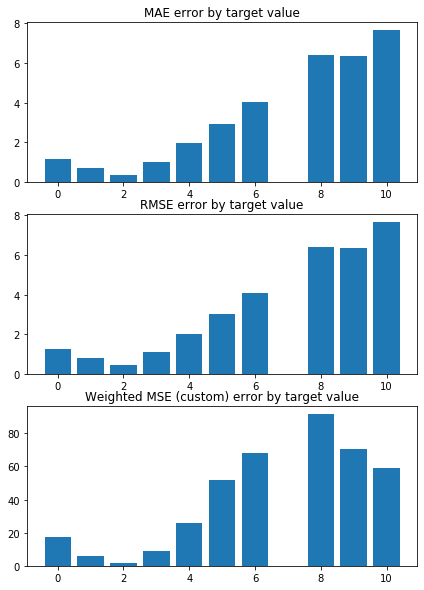

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0829666264663822 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0829254411414946 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


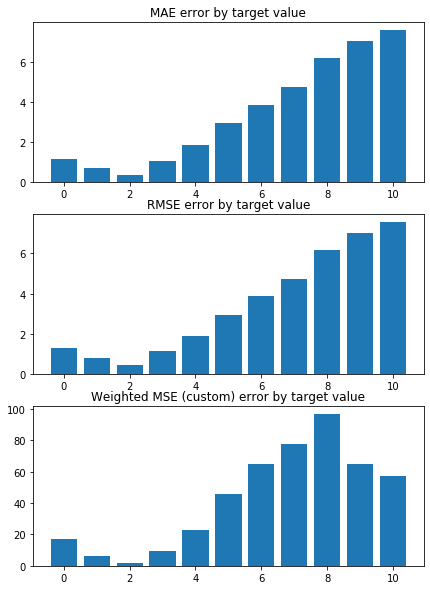

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1109743900475153 


 TRAIN PREDICTION Error
weighted_mse_train: 1.07726756500842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


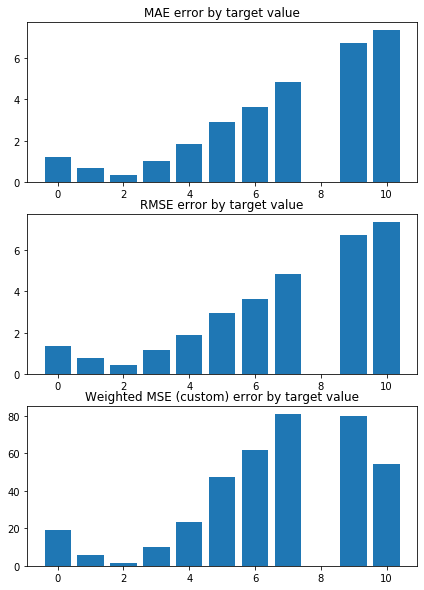

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0544567255406345 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0873692452241281 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


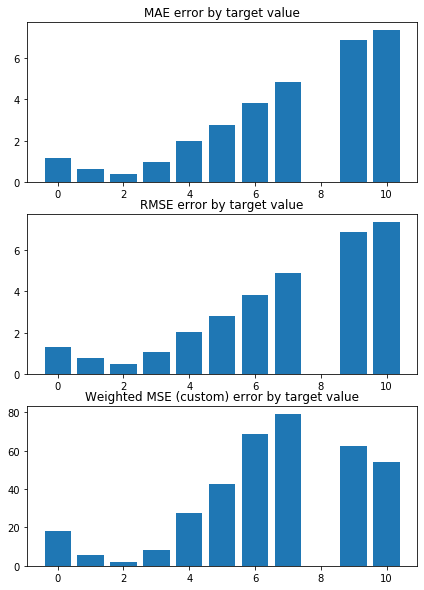

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1593813228849636 


 TRAIN PREDICTION Error
weighted_mse_train: 1.074225857417111 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


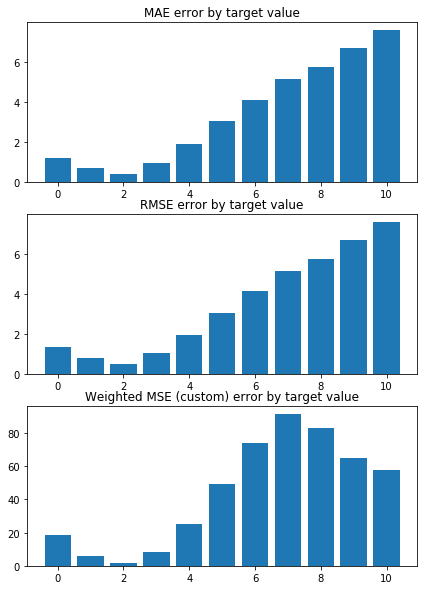

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1969621678700568 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0680639527196827 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


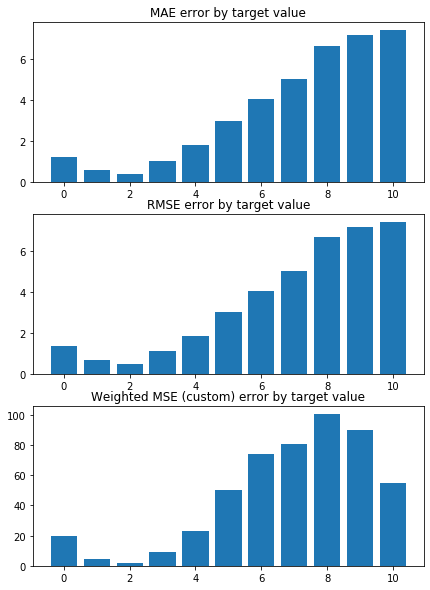

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9986672275332011 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0890332640767044 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


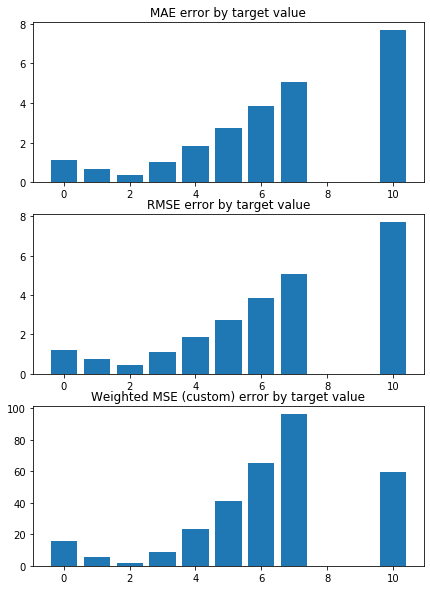

Weighted Mean squared error on Train: 1.08 
 MSE mean train: 2.302769586293462 

Mean squared error on Test: 1.08 
 MSE mean test:  2.3060550532021296 

Root of MSE on Test: 1.04 
 1.51857006858496 

Variance score on Test: 0.06 
 r2_test: 0.22160353981488418 

wMSE_train 1.08
wMSE_test 1.08
MSE_train 2.3
MSE_test 2.31
MAE_train 1.04
MAE_test 1.01
r2_test 0.22
    H3K4me1  H3K36me3   H3K4me2     Chriz      CTCF  H3K36me1  H3K27me3  \
0 -0.237633 -0.128578 -0.113073 -0.066017 -0.058577      -0.0       0.0   
1 -0.224325 -0.123701 -0.173688 -0.015935 -0.056981      -0.0       0.0   
2 -0.227767 -0.124315 -0.138287 -0.035207 -0.056505      -0.0       0.0   
3 -0.245191 -0.140406 -0.123536 -0.026242 -0.081585      -0.0       0.0   
4 -0.245152 -0.129499 -0.107593 -0.058793 -0.067452      -0.0       0.0   
5 -0.233679 -0.129152 -0.112643 -0.055454 -0.057439      -0.0       0.0   
6 -0.237199 -0.127647 -0.142696 -0.027850 -0.066237      -0.0       0.0   
7 -0.244521 -0.133991 -0.123082 -0.05

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


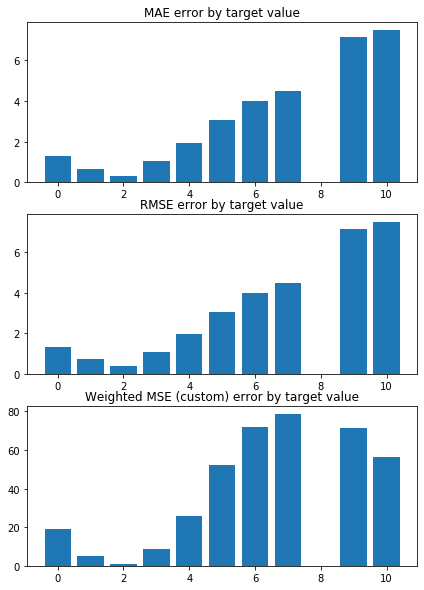

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1361983612790336 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1596605998324703 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


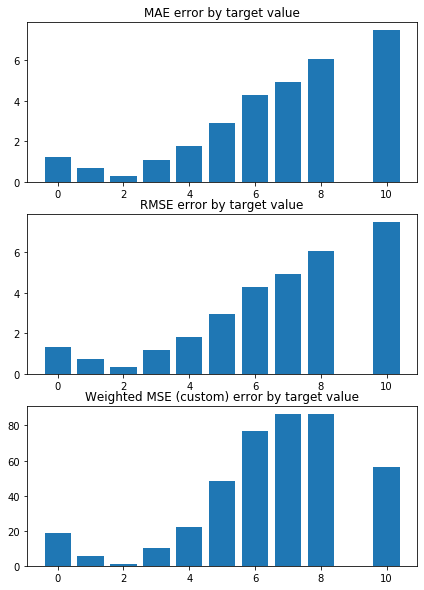

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.072598952388322 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1542208781919534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


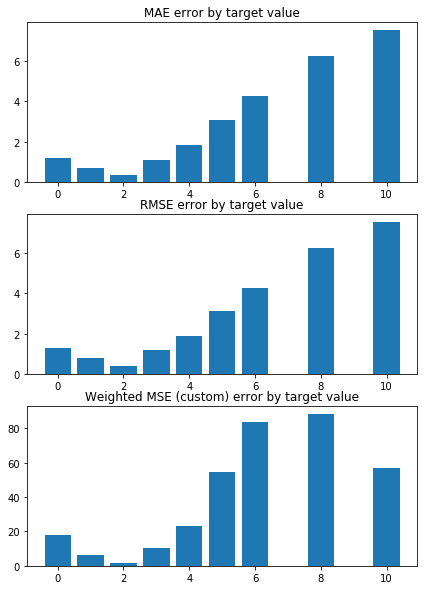

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1561755316418252 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1333684660177568 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


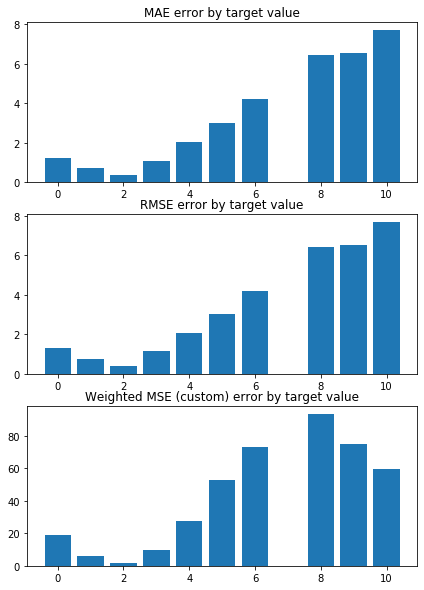

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1521698848623805 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1466061164878278 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


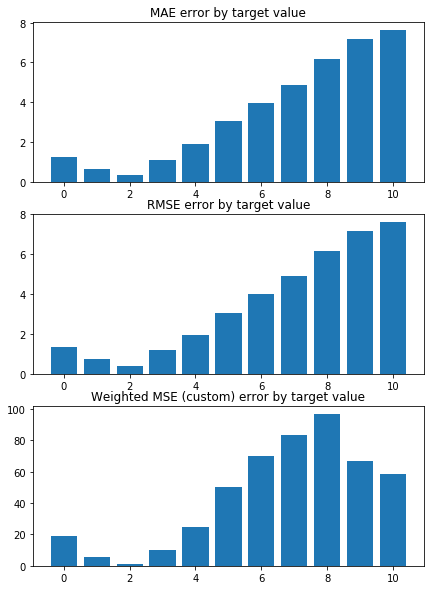

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1591455737750607 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1427909832662064 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


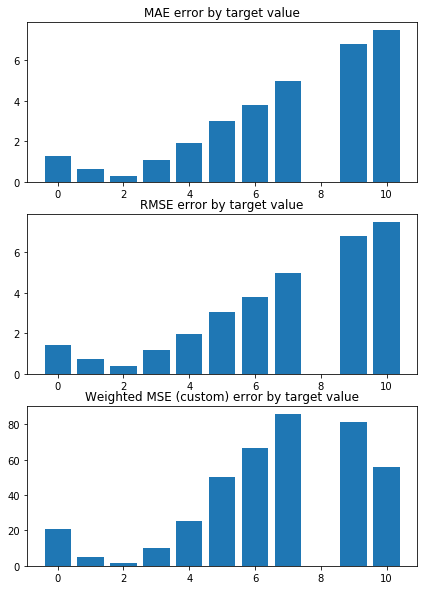

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.110165024016513 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1515073700092717 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


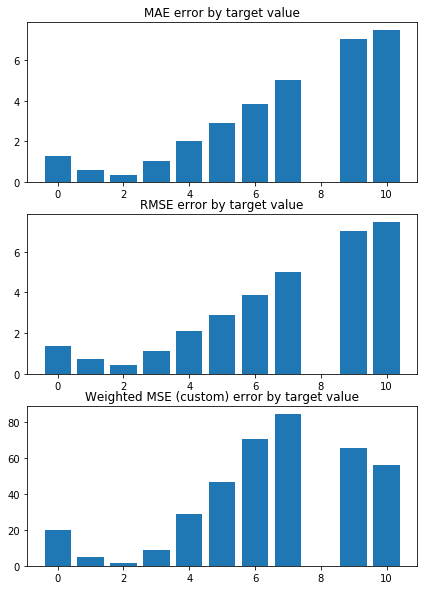

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2239945739183828 


 TRAIN PREDICTION Error
weighted_mse_train: 1.138099493335371 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


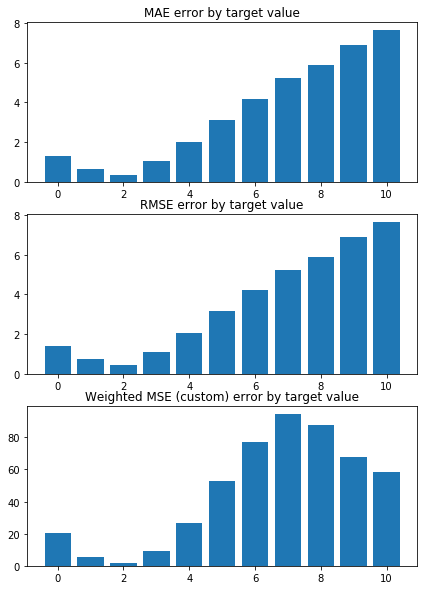

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2657523356420939 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1319120385947314 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


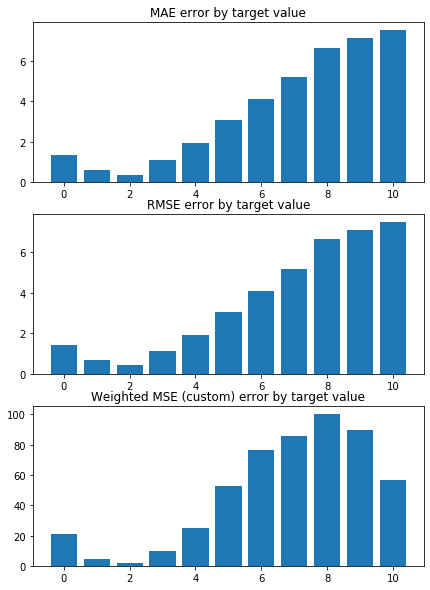

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.068812960030394 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1530821959244362 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


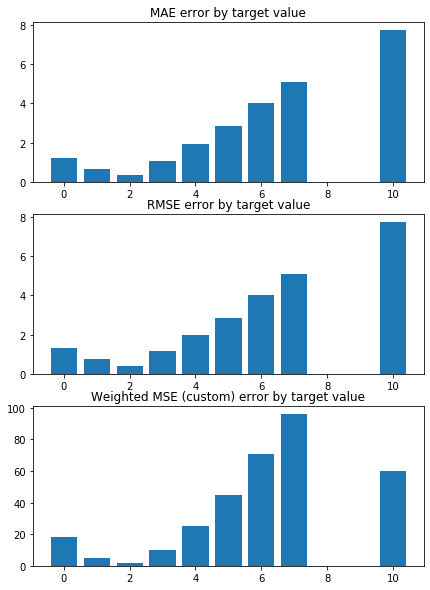

Weighted Mean squared error on Train: 1.15 
 MSE mean train: 2.4077287125026703 

Mean squared error on Test: 1.15 
 MSE mean test:  2.410720462302491 

Root of MSE on Test: 1.07 
 1.5526494975693939 

Variance score on Test: 0.06 
 r2_test: 0.18581202088075455 

wMSE_train 1.15
wMSE_test 1.15
MSE_train 2.41
MSE_test 2.41
MAE_train 1.08
MAE_test 1.06
r2_test 0.19
    H3K4me2   H3K4me1  H3K36me3      CTCF  RNA-polymerase-II     Chriz  CP190  \
0 -0.201623 -0.128855 -0.066197 -0.029647          -0.015793 -0.011066   -0.0   
1 -0.253458 -0.123316 -0.052215 -0.007814          -0.015372 -0.000000   -0.0   
2 -0.221651 -0.121337 -0.057404 -0.020914          -0.040725 -0.000000   -0.0   
3 -0.201668 -0.142779 -0.070159 -0.043462          -0.019377 -0.000000   -0.0   
4 -0.197389 -0.133157 -0.065613 -0.043367          -0.022127 -0.001002   -0.0   
5 -0.201347 -0.121375 -0.065848 -0.029778          -0.046274 -0.000000   -0.0   
6 -0.220886 -0.135869 -0.056634 -0.027379          -0.024804 -0.000

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


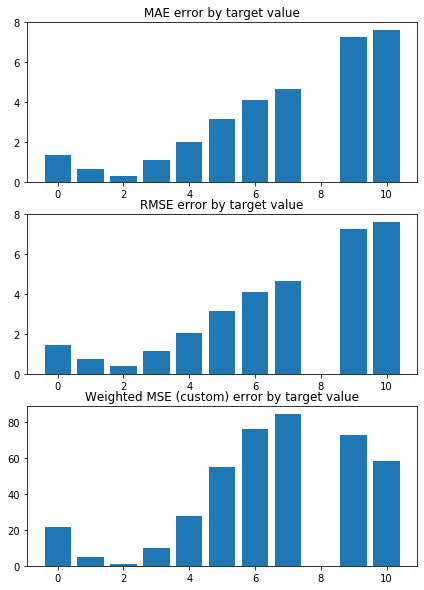

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2261289875823698 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2361843330719988 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


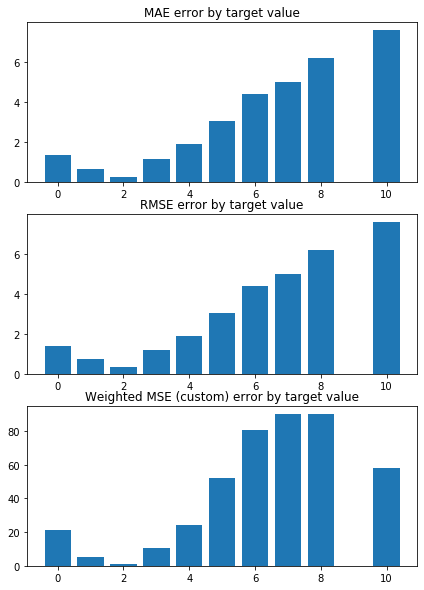

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1477510699928823 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2335312190615568 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


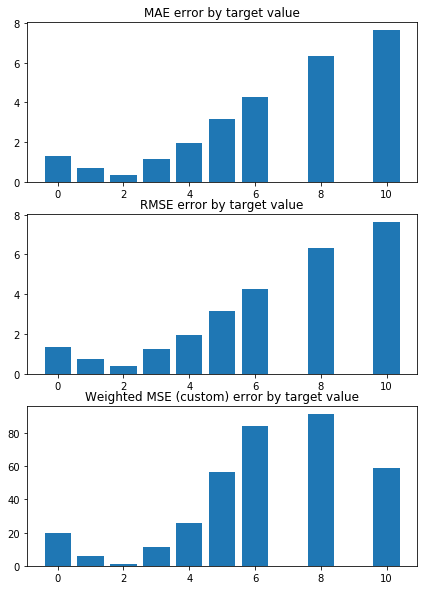

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.219714926244147 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2158133242656561 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


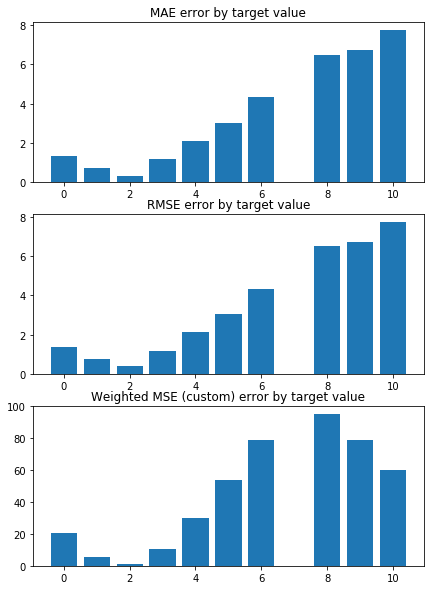

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2417781547009994 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2283211475192333 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


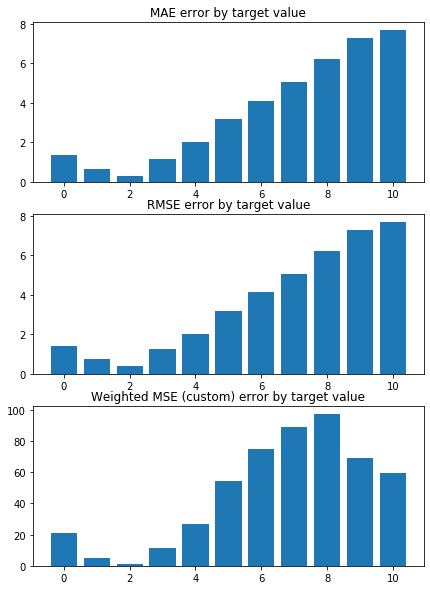

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2219628666484392 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2247170610103935 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


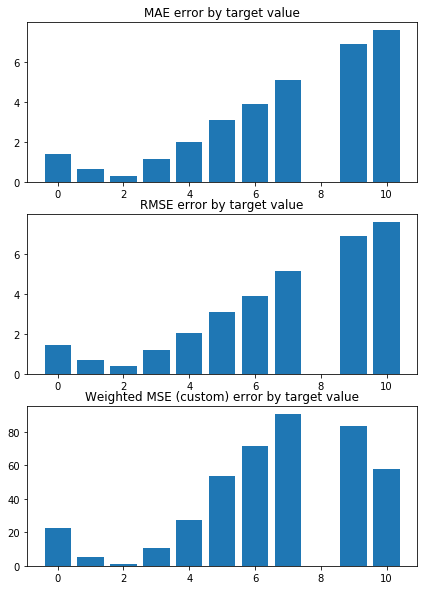

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1812200461606985 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2316135279656424 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


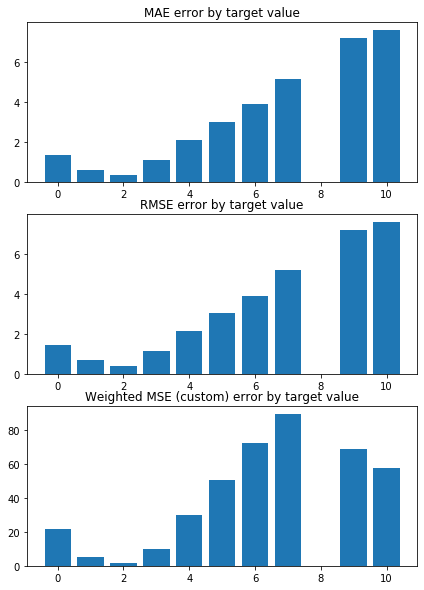

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3076429844324045 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2203781167610568 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


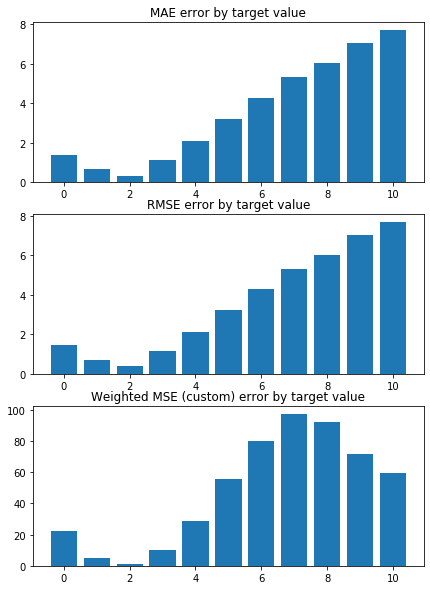

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3427893438674756 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2089636523902823 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


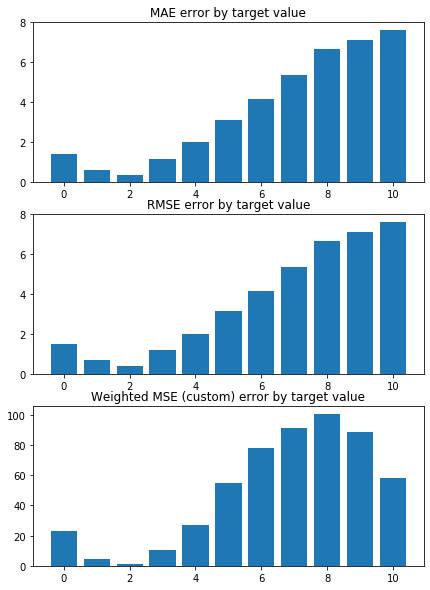

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1592842508472694 


 TRAIN PREDICTION Error
weighted_mse_train: 1.234497244605661 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


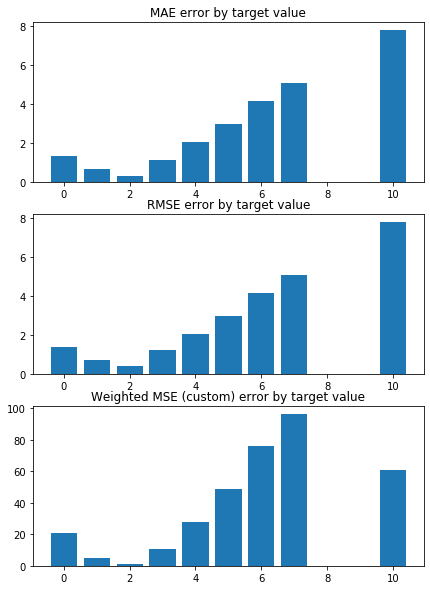

Weighted Mean squared error on Train: 1.23 
 MSE mean train: 2.531914164425518 

Mean squared error on Test: 1.23 
 MSE mean test:  2.5338307121626933 

Root of MSE on Test: 1.11 
 1.59180109064 

Variance score on Test: 0.06 
 r2_test: 0.1437551934455506 

wMSE_train 1.23
wMSE_test 1.23
MSE_train 2.53
MSE_test 2.53
MAE_train 1.13
MAE_test 1.11
r2_test 0.14
    H3K4me2   H3K4me1  RNA-polymerase-II  H3K36me3  H3K36me1  H3K27me3  \
0 -0.258401 -0.038190          -0.014910      -0.0      -0.0       0.0   
1 -0.275243 -0.045297          -0.000000      -0.0      -0.0       0.0   
2 -0.262384 -0.037411          -0.026151      -0.0      -0.0       0.0   
3 -0.264571 -0.050965          -0.019328      -0.0      -0.0       0.0   
4 -0.260672 -0.042569          -0.017609      -0.0      -0.0       0.0   
5 -0.252110 -0.032849          -0.041021      -0.0      -0.0       0.0   
6 -0.263291 -0.054557          -0.011362      -0.0      -0.0       0.0   
7 -0.265455 -0.046268          -0.013245      -0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


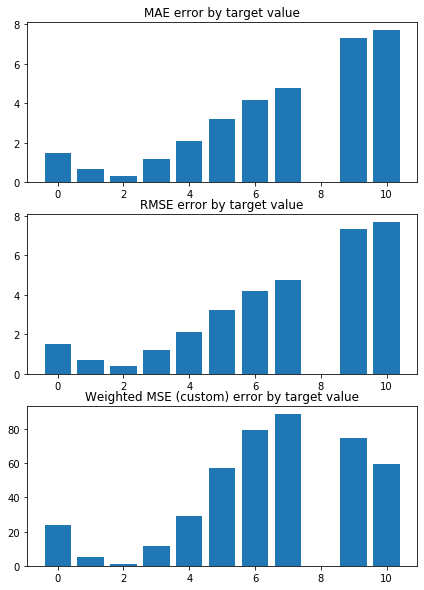

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3160390773345267 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3170368660915694 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


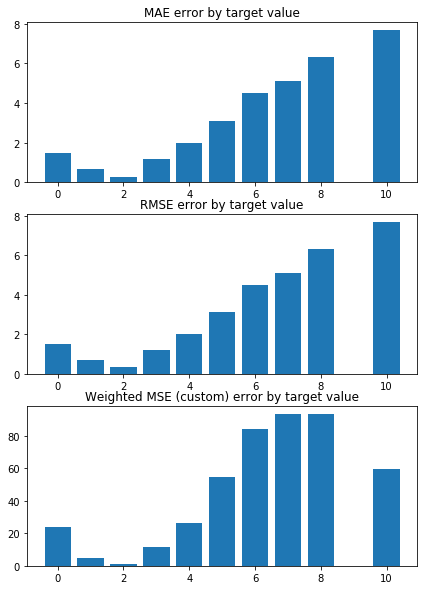

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2281315143488292 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3158610260560353 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


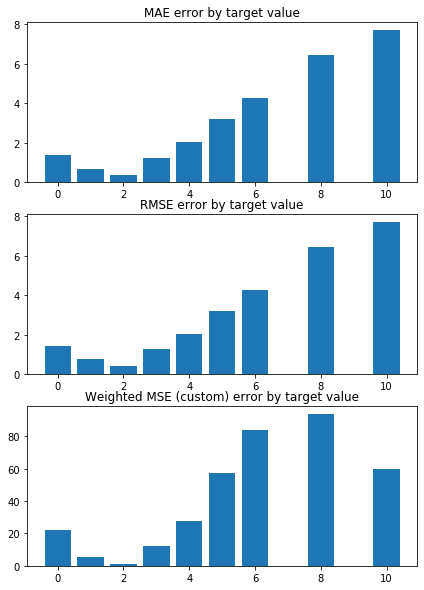

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.287493484047188 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2974362915281317 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


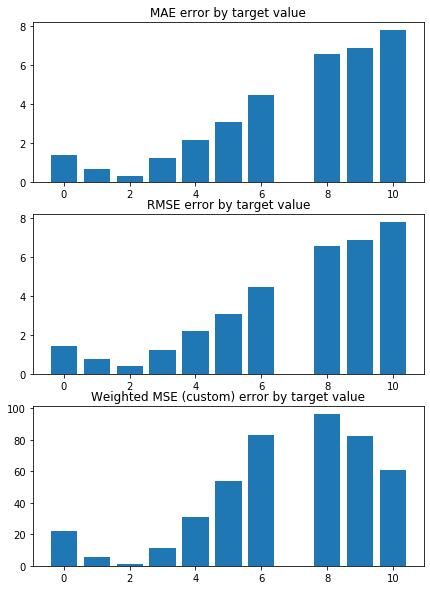

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3331546728968233 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3092919985528289 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


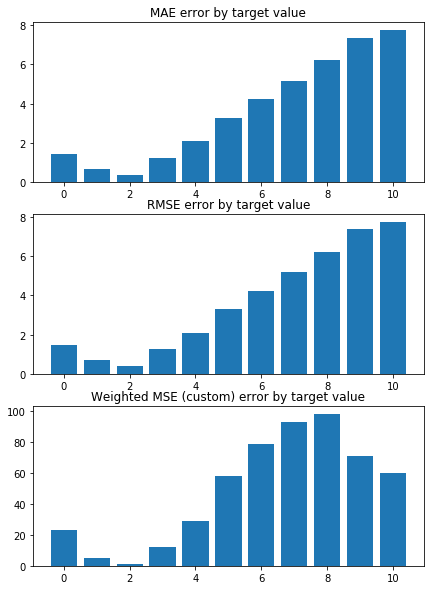

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2873194173732796 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3073399240356862 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


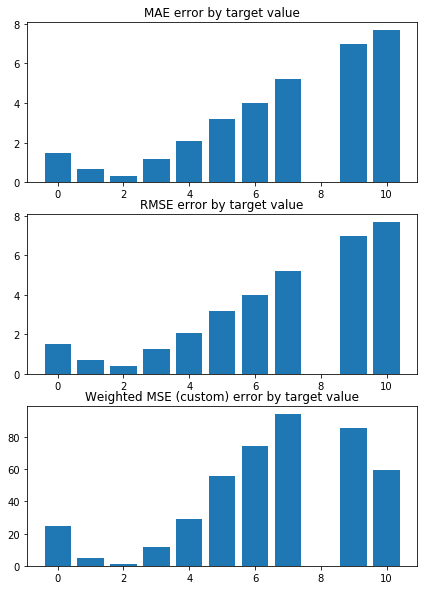

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2536660215661166 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3147598316352032 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


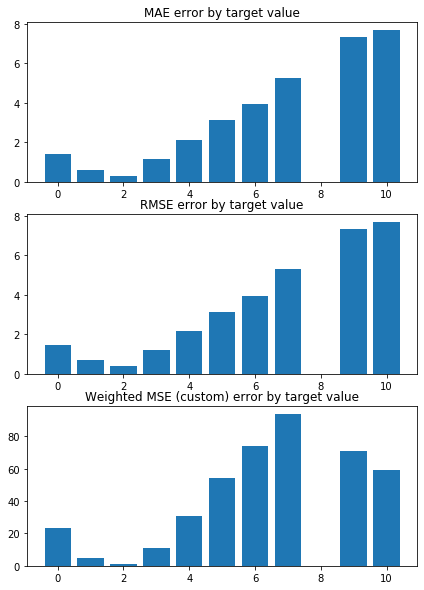

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3929667129026557 


 TRAIN PREDICTION Error
weighted_mse_train: 1.302209843115349 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


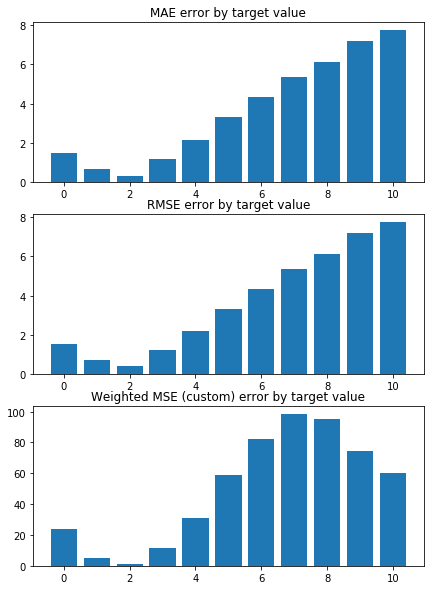

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4096904253898452 


 TRAIN PREDICTION Error
weighted_mse_train: 1.28644595787229 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


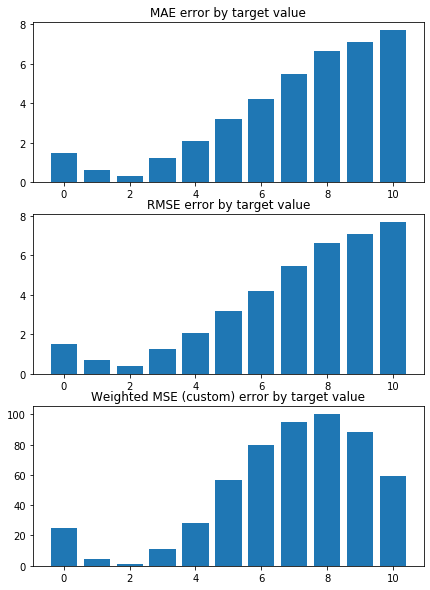

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2496568305330387 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3142764801557587 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


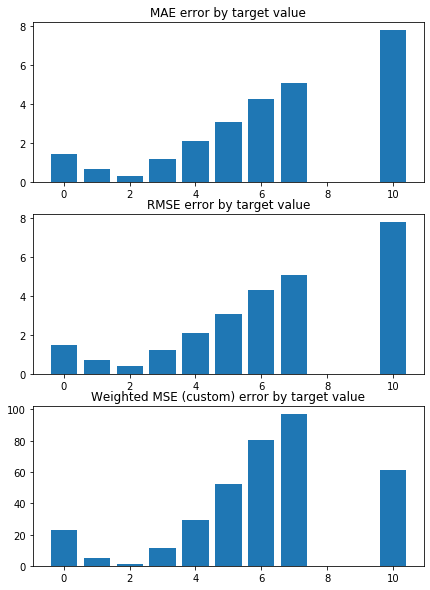

Weighted Mean squared error on Train: 1.31 
 MSE mean train: 2.651660901346319 

Mean squared error on Test: 1.31 
 MSE mean test:  2.6529001330837305 

Root of MSE on Test: 1.14 
 1.628772584826909 

Variance score on Test: 0.06 
 r2_test: 0.10305076553161738 

wMSE_train 1.31
wMSE_test 1.31
MSE_train 2.65
MSE_test 2.65
MAE_train 1.17
MAE_test 1.15
r2_test 0.1
    H3K4me2  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.202878   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
1 -0.211449   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
2 -0.216030   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
3 -0.224406   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
4 -0.211490   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
5 -0.217716   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
6 -0.217105   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


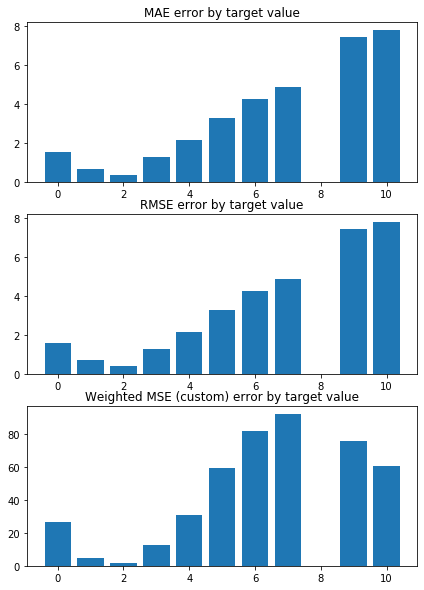

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4198412727136485 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4104511122762557 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


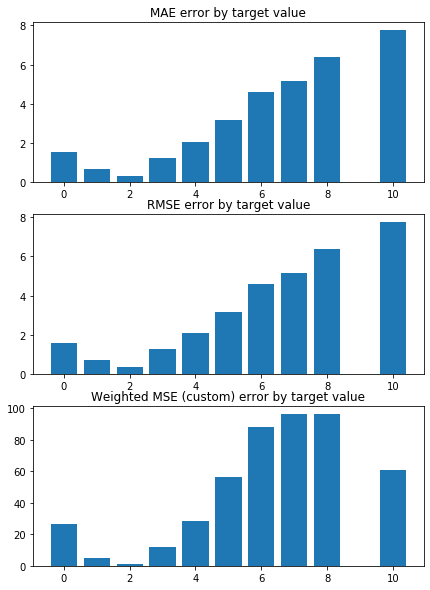

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3201957017813122 


 TRAIN PREDICTION Error
weighted_mse_train: 1.409407820973259 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


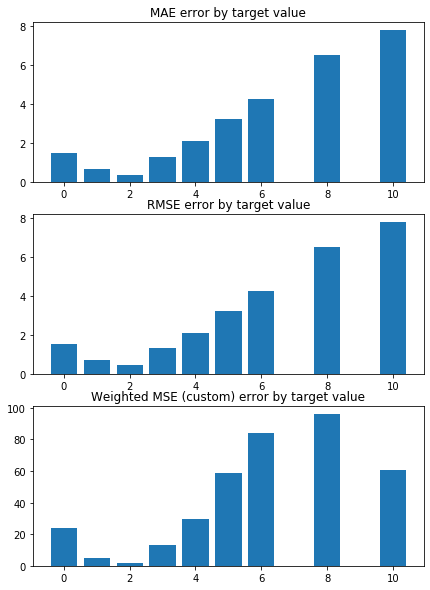

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3658658129535277 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3890441974205083 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


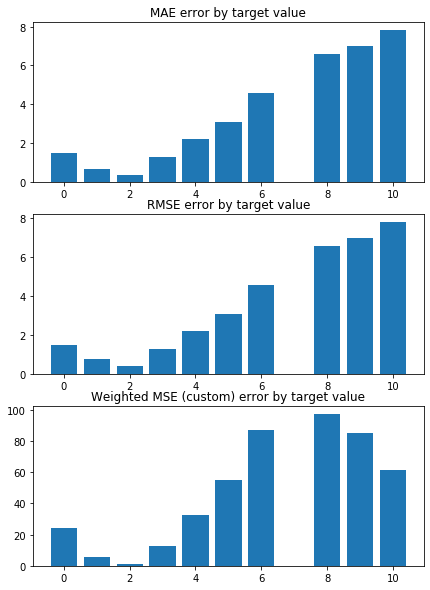

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.435140945147394 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4016593863944051 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


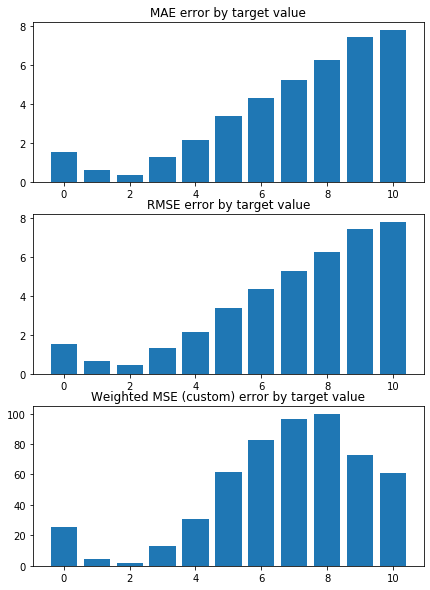

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3623258140353396 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4000794364934024 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


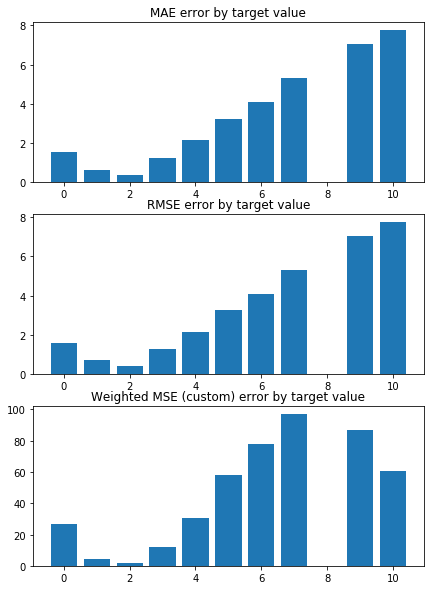

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.342825170736304 


 TRAIN PREDICTION Error
weighted_mse_train: 1.408588664255212 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


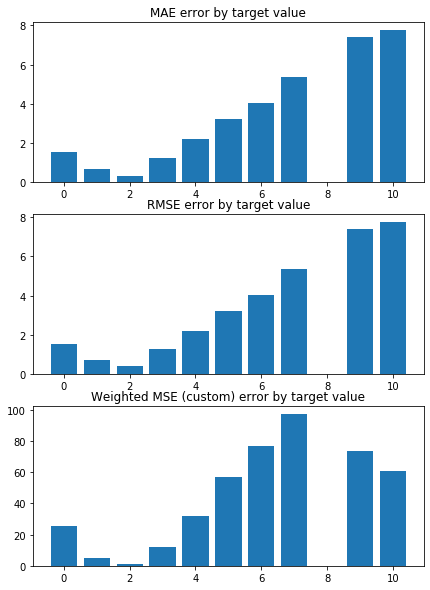

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.4916056497083992 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3955860031644034 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


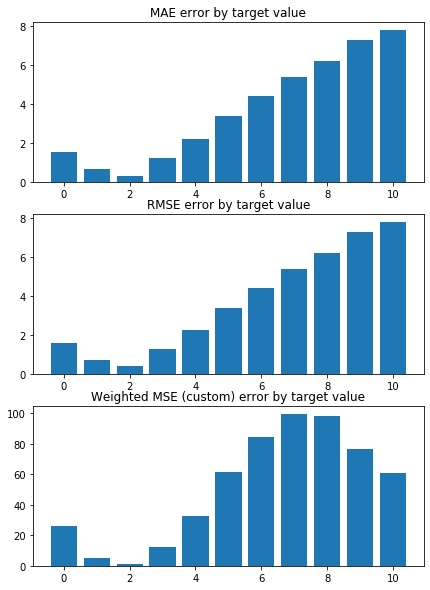

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4846756261127565 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3772224198353553 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


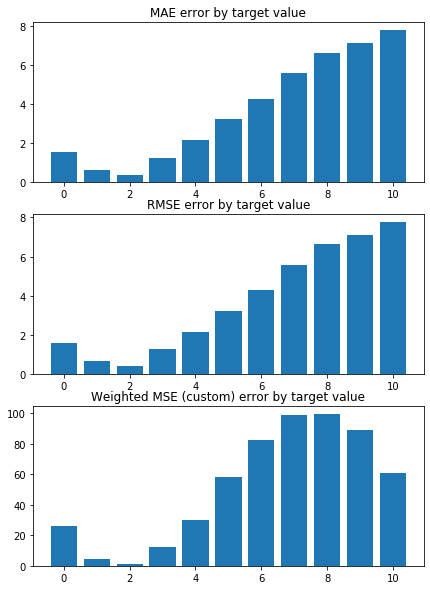

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3541850048495585 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4062898337504892 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


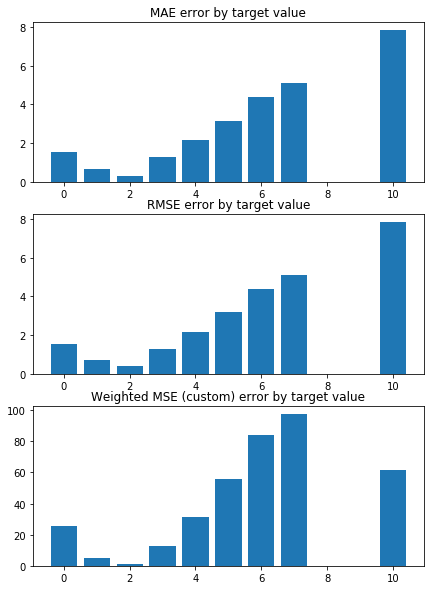

Weighted Mean squared error on Train: 1.40 
 MSE mean train: 2.7816898169406508 

Mean squared error on Test: 1.40 
 MSE mean test:  2.783116723399908 

Root of MSE on Test: 1.18 
 1.668267581474839 

Variance score on Test: 0.06 
 r2_test: 0.05851133605081996 

wMSE_train 1.4
wMSE_test 1.4
MSE_train 2.78
MSE_test 2.78
MAE_train 1.21
MAE_test 1.2
r2_test 0.06
    H3K4me2  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.102439   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
1 -0.110797   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
2 -0.115280   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
3 -0.125075   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
4 -0.111396   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
5 -0.118802   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
6 -0.117206   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


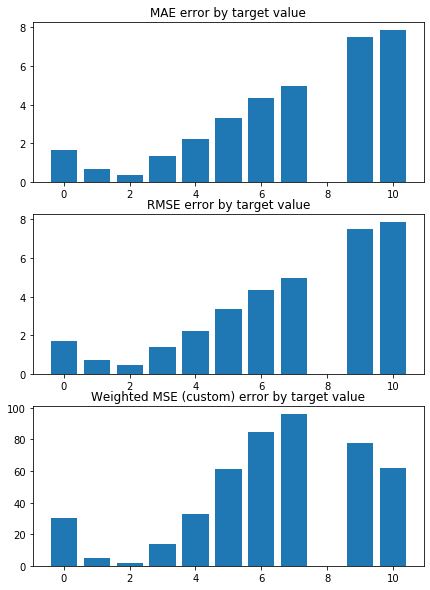

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5422317873347806 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5211177120331172 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


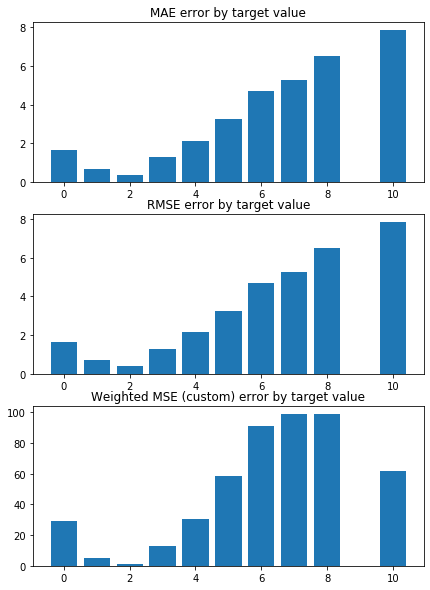

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4309392292266612 


 TRAIN PREDICTION Error
weighted_mse_train: 1.520222413001534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


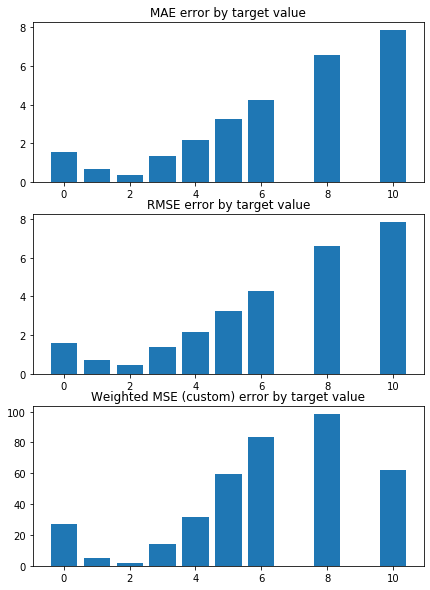

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4601077864036158 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4976821453513964 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


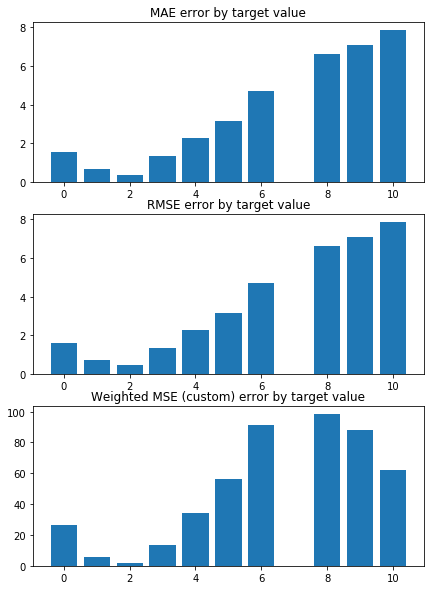

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5545984096138492 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5111649588503873 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


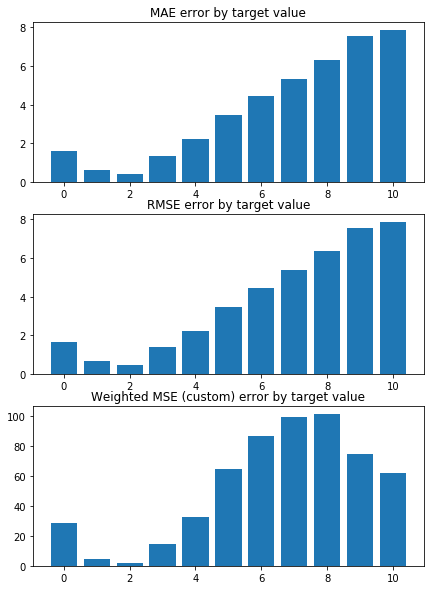

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4521363786900752 


 TRAIN PREDICTION Error
weighted_mse_train: 1.509801416788388 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


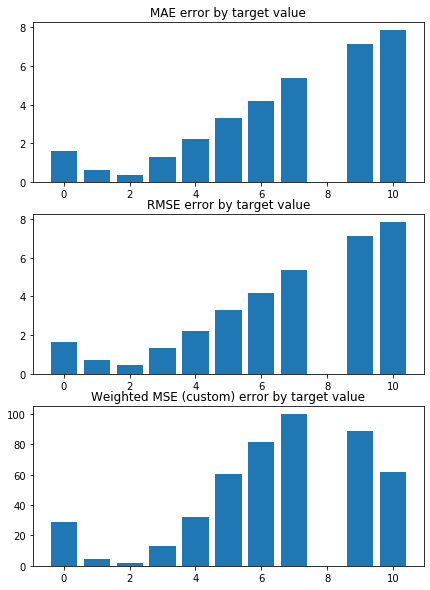

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.450308832265951 


 TRAIN PREDICTION Error
weighted_mse_train: 1.519574080699116 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


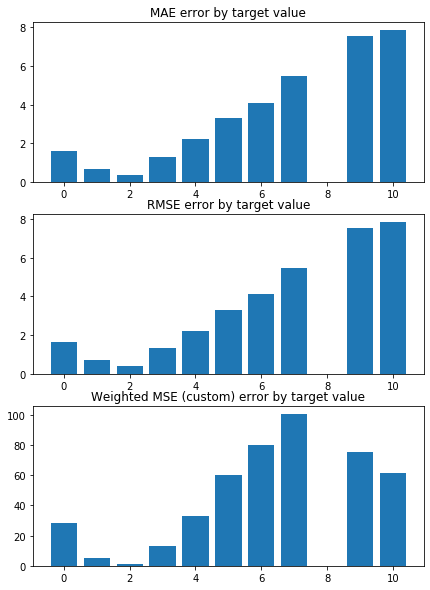

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6089792224561263 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5062382360970474 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


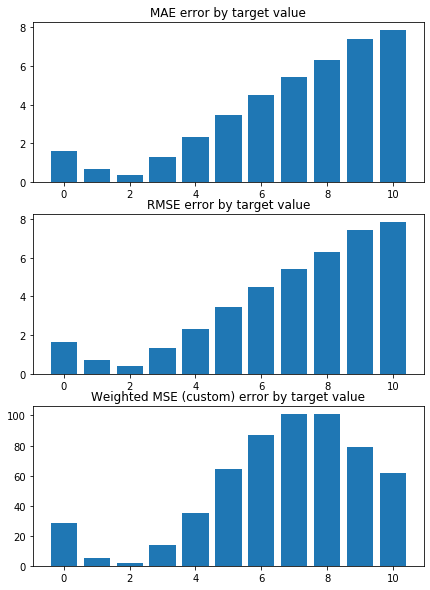

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5730747030163654 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4848776888579225 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


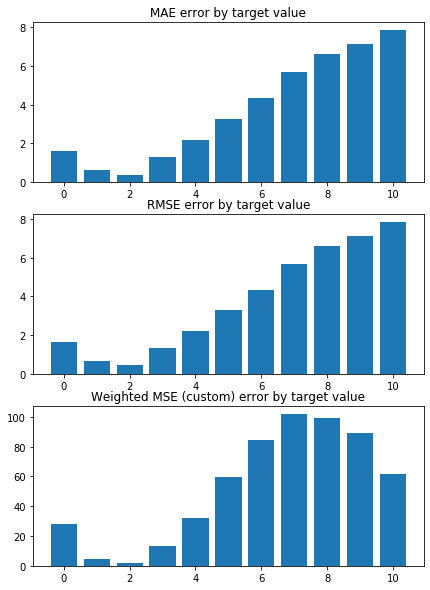

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4765403380045783 


 TRAIN PREDICTION Error
weighted_mse_train: 1.515531005220547 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


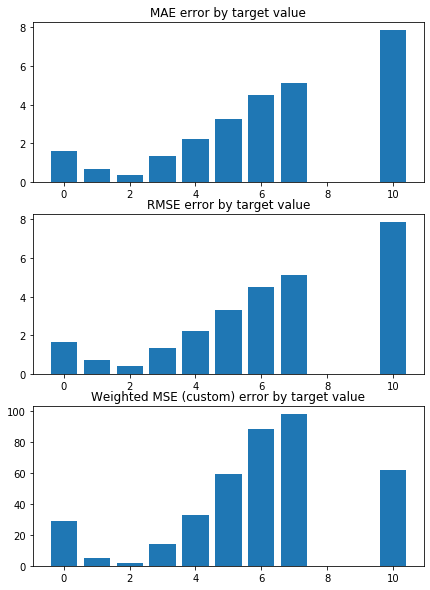

Weighted Mean squared error on Train: 1.51 
 MSE mean train: 2.9317024167899755 

Mean squared error on Test: 1.51 
 MSE mean test:  2.933357924146677 

Root of MSE on Test: 1.23 
 1.7127048561111389 

Variance score on Test: 0.06 
 r2_test: 0.007115246823823607 

wMSE_train 1.51
wMSE_test 1.51
MSE_train 2.93
MSE_test 2.93
MAE_train 1.26
MAE_test 1.25
r2_test 0.01
    H3K4me2  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.001999   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
1 -0.010144   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
2 -0.014530   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
3 -0.025744   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
4 -0.011302   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
5 -0.019889   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0   
6 -0.016637   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


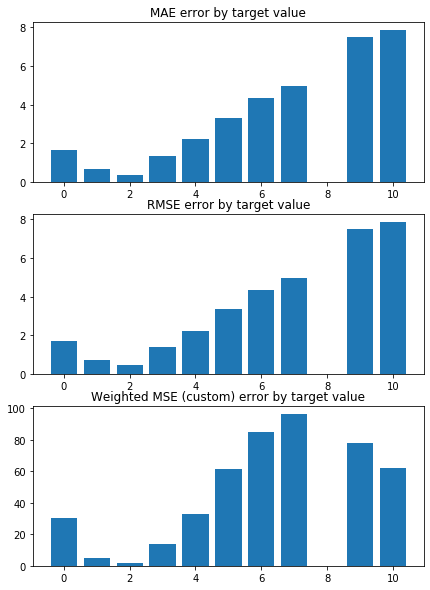

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.555598172469537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332283816329182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.555598172469537
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


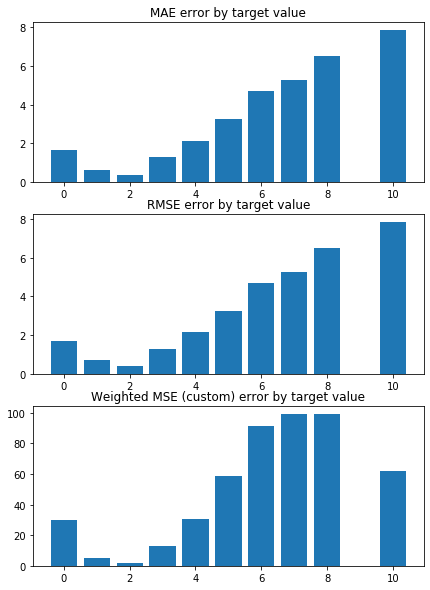

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4484520826241511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5376290480141426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4484520826241511
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


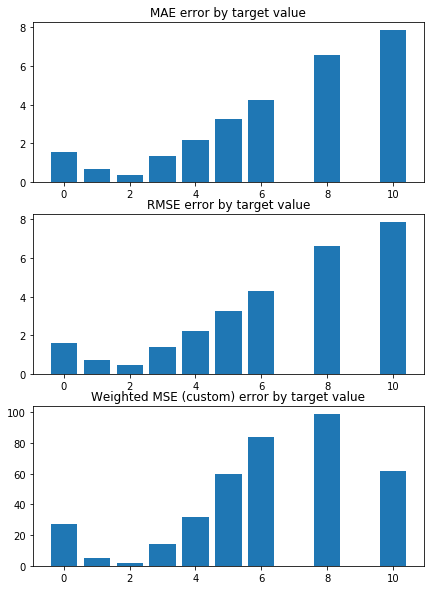

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4871218475178962 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5286165420930318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4871218475178962
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


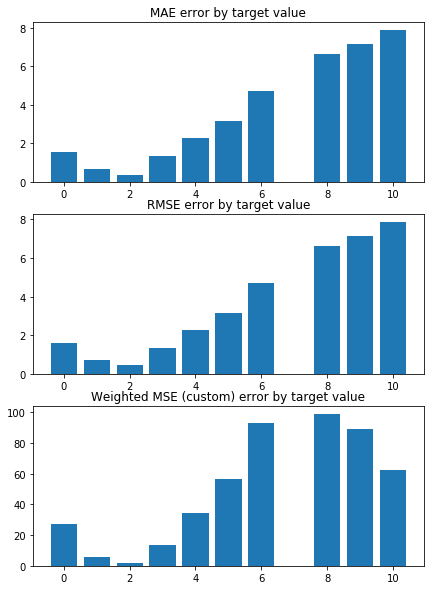

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5691848499209409 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5246067463854969 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5691848499209409
test sizes =  595 595 595


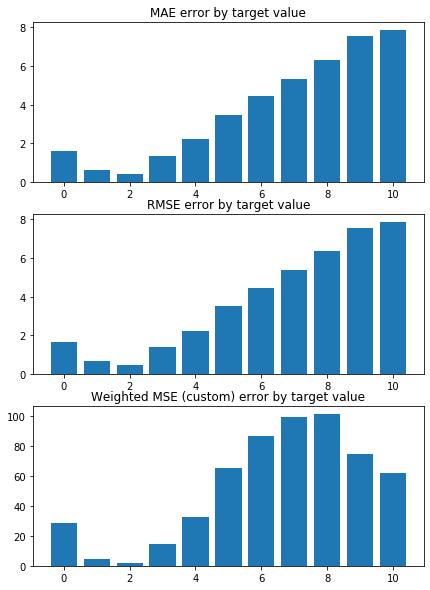

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.47198290491892 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5339147139949958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.47198290491892
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


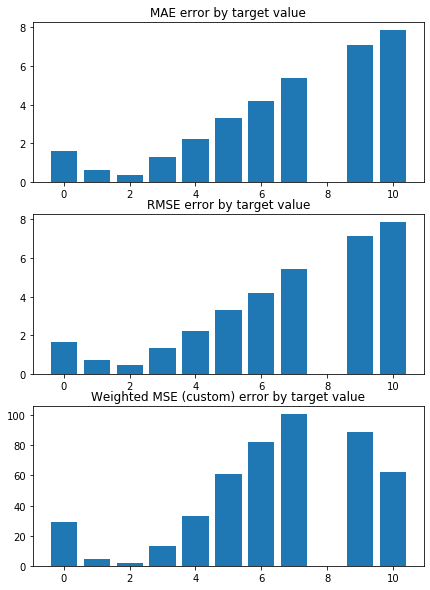

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4698577154229036 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5395979470373908 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4698577154229036
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


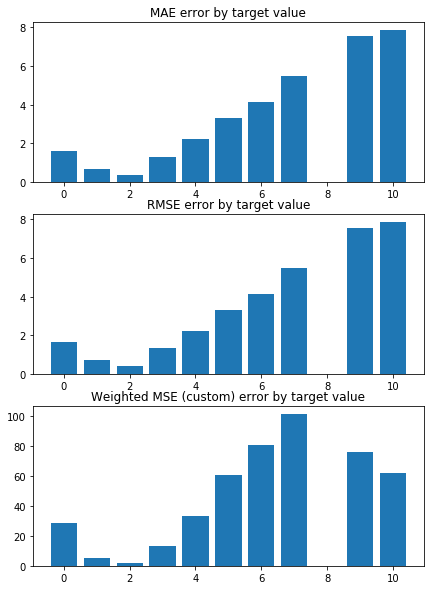

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.6258094685412205 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5220760059014686 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6258094685412205
test sizes =  595 595 595


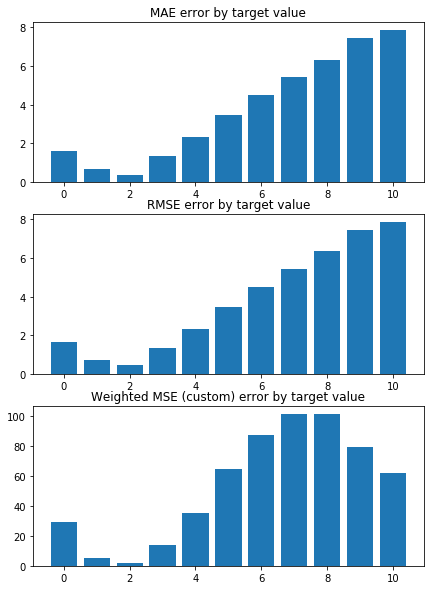

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6007348104053327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5186625316836926 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6007348104053327
test sizes =  595 595 595


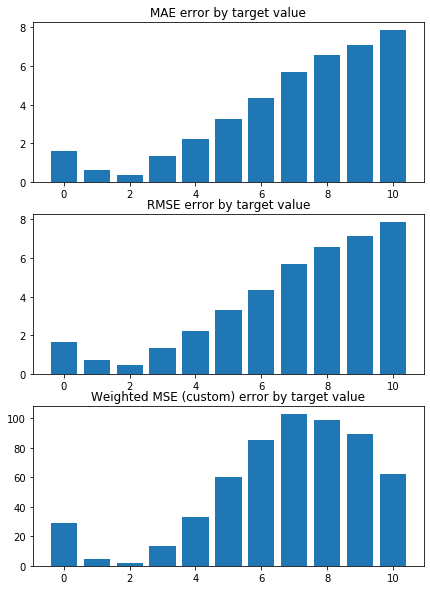

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.496247603284074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5332379669573635 


 CONSTANT pred Error:
weighted_mse_test_const:  1.496247603284074
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


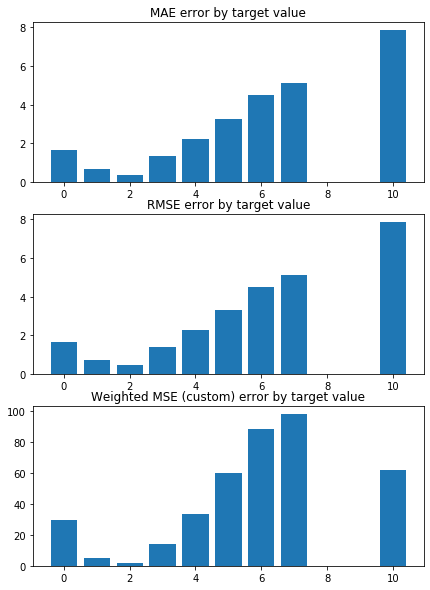

Weighted Mean squared error on Train: 1.53 
 MSE mean train: 2.9570267893782347 

Mean squared error on Test: 1.53 
 MSE mean test:  2.957656949359613 

Root of MSE on Test: 1.24 
 1.7197839833419817 

Variance score on Test: 0.06 
 r2_test: -0.0010673110719145785 

wMSE_train 1.53
wMSE_test 1.53
MSE_train 2.96
MSE_test 2.96
MAE_train 1.27
MAE_test 1.25
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0      0.0     -0.0     -0.0   

In [80]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 1, 0.1)
# Create linear regression object

model_name = 'LR+L1_grid0.1-1'
n_splits = 10
random_state = 16 
shuffle = True


wmse_test = []
wmse_train = []

for alpha in alpha_grid:
    model = linear_model.Lasso(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                        weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                        rmse_test, rmse_train, rmse_test_const, \
                        mae_test,    mae_train,  mae_test_const, \
                        _ = train_test_KFold(X, y, model, model_name, results_pd,
                                             n_splits=n_splits, random_state=random_state, shuffle=shuffle)


    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))


In [81]:
wmse_test

[1.0054820749179934,
 1.0193690439338146,
 1.0414118615316628,
 1.0844233291564203,
 1.1481996688014329,
 1.2280950615920614,
 1.308926022605893,
 1.4018261209360954,
 1.5119086901491363,
 1.5297902635376162]

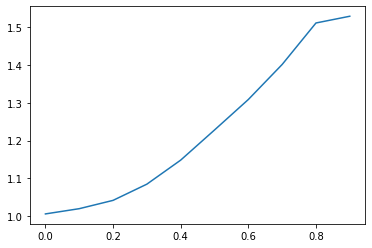

In [82]:
plt.plot(alpha_grid, wmse_test)

In [83]:
# Best alpha = 0.2

# L1 - best  score

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0074751901515142 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0431542605959534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5729131802711864
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


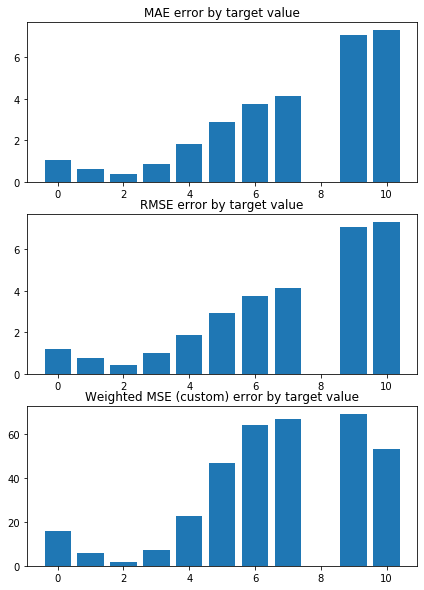

In [ ]:
# L1 - best 
model = linear_model.Lasso(alpha=0.2)


model_name = 'LR+L1_alf=0.2_spt=10'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

# wmse_test.append(np.mean(weighted_mse_test_all))
# wmse_train.append(np.mean(weighted_mse_train_all))
results_pd

In [ ]:
coefs_argsort, coefs

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
coefs_argsort[:]

In [ ]:

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]], coefs

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS + L 1

Получили наиболее влияющие признаки

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Linear Regression with L2 regularization -  Ridge

In [ ]:
X, y = data_scaled_clean, target_clean.gamma
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=10)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l2 = linear_model.Ridge()

# Train the model using the training sets
lin_reg_l2.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l2.predict(X_test)

Коэффициенты

In [ ]:
plt.scatter( np.arange(len(lin_reg_l2.coef_)) , lin_reg_l2.coef_)
plt.show()

In [ ]:
plt.hist(lin_reg_l2.coef_, bins=50)
plt.show()

In [ ]:
# Make predictions using the testing set
y_pred_train = lin_reg_l2.predict(X_train)
# The mean squared error
print("Mean squared error on Train: %.2f"
      % mean_squared_error(y_train, y_pred_train))

# The mean squared error
print("Mean squared error on Test: %.2f"
      % mean_squared_error(y_test, y_pred))


# The mean squared error
print("Root of Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train), bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L2


## Fined parametrs for L2

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 10, 1)
# Create linear regression object



model_name = 'LR+L2_grid10'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

results_pd_gr = pd.DataFrame()

for alpha in alpha_grid:
    model = linear_model.Ridge(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    results_pd_gr = train_test_KFold(X, y, 
                                                  model, model_name, results_pd_gr,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))

results_pd_gr

In [ ]:
plt.plot(alpha_grid, wmse_test)

In [ ]:
wmse_test

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(1000, 10000, 1000)
# Create linear regression object



model_name = 'LR+L2_grid10000'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

results_pd_gr = pd.DataFrame()

for alpha in alpha_grid:
    model = linear_model.Ridge(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    results_pd_gr = train_test_KFold(X, y, 
                                                  model, model_name, results_pd_gr,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))

results_pd_gr

In [ ]:
results_pd_gr

In [ ]:
plt.plot(alpha_grid, wmse_test)

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# alpha_grid = np.arange(3000, 10000, 100)
# Create linear regression object


wmse_test = []
wmse_train = []

# for alpha in alpha_grid:
model = linear_model.Ridge(alpha=3000)


model_name = 'LR+L2_alf=3000'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)



wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
coefs_argsort, np.sort(coefs)

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS  + L2

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
%%time
n_splits=10
random_state=16

X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# alpha_grid = np.arange(3000, 10000, 100)
# Create linear regression object


wmse_test = []
wmse_train = []

# for alpha in alpha_grid:
model = linear_model.Ridge(alpha=2000)

model_name = 'LR+L2_alf=2000'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_test.append(np.mean(weighted_mse_test_all))
wmse_train.append(np.mean(weighted_mse_train_all))


wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
results_pd

In [ ]:
wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
su_drsc.columns[2:], coefs

In [ ]:
coefs_argsort

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
coefs

In [ ]:
coefs_argsort, su_drsc.columns[2:][coefs_argsort[0]], np.sort(coefs)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L1  + L2/1 

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.ElasticNet()

model_name = 'LR+L1+L2'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
results_pd

In [ ]:
weighted_mse_train_all, weighted_mse_test_all

In [ ]:
print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object

alpha =  0.2 # 3000 + 0.2
l1_ratio = 0.5 # 0.000066 # 0.2 / (3000 + 0.2)

model = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, 
                                copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')


model_name = 'LR+L2_alf=.2_rat=.5'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)


wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
results_pd

In [ ]:
print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

In [ ]:
coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:][coefs_argsort][0])
coefs_pd.round(2)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS 

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2


$$ \frac{1}{(2  n_{samples})} ||y - Xw||^2_2
+ alpha * l1_{ratio}  ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) ||w||^2_2 $$



$$ \frac{1}{ n\_samples} ||y - Xw||^2_2
+ \alpha ||w||_1
+ \beta ||w||^2_2 $$

$$ \frac{1}{ n\_samples} ||y - Xw||^2_2 + \alpha ||w||_1 + \beta ||w||^2_2 $$

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression()

model_name = 'LR'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)



In [ ]:
results_pd

In [ ]:
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

In [ ]:
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]].iloc[0]

In [ ]:
plt.plot(coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]].iloc[0])

# !! одинаковая приоритизация 

In [ ]:
np.sort(coefs[0])

In [ ]:
pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
coefs_df = pd.DataFrame(coefs, columns=su_drsc.columns[2:])[su_drsc.columns[2:][coefs_argsort[0]]]

coefs_df

In [ ]:
coefs_df.round(2)

In [ ]:
# !! одинаковая приоритизация 

np.sort(coefs[0])

coefs

coefs_argsort[0]

pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

su_drsc.columns[2:], su_drsc.columns[2:][coefs_argsort[0]]

coefs_df = pd.DataFrame(coefs, columns=su_drsc.columns[2:])[su_drsc.columns[2:][coefs_argsort[0]]]

coefs_df

coefs_df.round(2)

In [ ]:
coefs_df

In [ ]:
coefs_df_2 = coefs_df.round(2)
coefs_df_2

In [ ]:
coefs_means = pd.DataFrame ( coefs_df.mean() )
coefs_means.round(2)# .values, coefs_means.values

In [ ]:
coefs_std = pd.DataFrame (coefs_df.std())

coefs_std.round(4)

In [ ]:
order_df = np.argsort(np.abs(coefs_means))
priority_order = order_df.index.values

priority_order


In [ ]:
coefs_df_2[priority_order]

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS + L 

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2


$$ \frac{1}{(2  n_{samples})} ||y - Xw||^2_2
+ alpha * l1_{ratio}  ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) ||w||^2_2 $$



$$ \frac{1}{ n\_samples} ||y - Xw||^2_2
+ \alpha ||w||_1
+ \beta ||w||^2_2 $$

$$ \frac{1}{ n\_samples} ||y - Xw||^2_2 + \alpha ||w||_1 + \beta ||w||^2_2 $$

In [ ]:
def getConfIdxFrequencies(coefs_argsort, feature_names, row_lim, min_lim = 5, max_lim = 5):
    ''' 
    Get Frequencies of feature indexes in the sorted array of indexes bu the coefficient of the feature in different itterstions.
    The smallest and the biggest elements are valueable - as they give the biggest impact.
    min_lim, max_lim - limitations of the number of smallest and biggest coefficients to consider for the frequency.
    '''
    merged_coefs = np.concatenate(np.hstack([coefs_argsort[:row_lim,:min_lim], coefs_argsort[:row_lim,-max_lim:]]))

    merged_coefs = list(merged_coefs)

    featur_freq_dict =  dict((i, merged_coefs.count(i)) for i in merged_coefs)
    for key, value in  sorted(featur_freq_dict.items(), key=lambda item: (-item[1], item[0])):
        print("{}: {}".format(feature_names[key], value)) # (feature_names[key], value))
        
    return featur_freq_dict

In [ ]:
feature_names = su_drsc.columns[2:]
feature_names

In [ ]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort,feature_names=feature_names, row_lim=len(coefs_argsort), min_lim = 3, max_lim = 0)

In [ ]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort,feature_names=feature_names, row_lim=len(coefs_argsort), min_lim = 5, max_lim = 0)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# CONST pred

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# CONSTANT pred Error:

In [ ]:

print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





In [ ]:

def train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True):


    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []


    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#         # Train the model using the training sets
#         model.fit(X_train, y_train)

#         # Make predictions using the train set
#         y_pred_train = model.predict(X_train)

#         # Make predictions using the testing set
#         y_pred = model.predict(X_test)
        

        print(" CONSTANT pred Error:" )

        const_pred = np.mean(y_train)
        const_pred_test = np.array([const_pred] * len(y_test) )


        const_pred_train = np.array([const_pred] * len(y_train) )


        # rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
        weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

        weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

        # mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

        print("weighted_mse_train_const: ", weighted_mse_train_const )

        print("weighted_mse_test_const: ", weighted_mse_test_const )


#         MSE_train.append(mean_squared_error(y_train, y_pred_train))

#         MSE_test.append(mean_squared_error(y_test, y_pred))

#         r2_test.append(r2_score(y_test, y_pred))

#         coefs.append(model.coef_)
#         coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        
#         weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  X_test,y_train, y_test, model )
            
        weighted_mse_test_all.append(weighted_mse_test_const)
        weighted_mse_train_all.append(weighted_mse_train_const)

    
    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)



#     coefs = np.array(coefs)
#     coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
          weighted_mse_train_all, "\n")

    # The mean squared error
    print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
          weighted_mse_test_all, "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")
    
    return weighted_mse_test_all, weighted_mse_train_all, 
    
    
    
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





In [ ]:
#  weighted_mse_test_all, weighted_mse_train_all = train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True)

In [ ]:
# weighted_mse_test_all, weighted_mse_train_all

In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")
# # Explained variance score: 1 is perfect prediction
# print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")


In [ ]:
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )

In [ ]:
def train_test_KFold_const(X, y, n_splits=5, random_state=16, shuffle=True):


    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []


    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#         # Train the model using the training sets
#         model.fit(X_train, y_train)

#         # Make predictions using the train set
#         y_pred_train = model.predict(X_train)

#         # Make predictions using the testing set
#         y_pred = model.predict(X_test)
        

        print(" CONSTANT pred Error:" )

        const_pred = np.mean(y_train)
        const_pred_test = np.array([const_pred] * len(y_test) )
        const_pred_train = np.array([const_pred] * len(y_train) )


        # rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
        weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

        weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

        # mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

        print("weighted_mse_train_const: ", weighted_mse_train_const )

        print("weighted_mse_test_const: ", weighted_mse_test_const )


#         MSE_train.append(mean_squared_error(y_train, y_pred_train))

#         MSE_test.append(mean_squared_error(y_test, y_pred))

#         r2_test.append(r2_score(y_test, y_pred))

#         coefs.append(model.coef_)
#         coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        
#         weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  X_test,y_train, y_test, model )
            
        weighted_mse_test_all.append(weighted_mse_test_const)
        weighted_mse_train_all.append(weighted_mse_train_const)

    
    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)



#     coefs = np.array(coefs)
#     coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
          weighted_mse_train_all, "\n")

    # The mean squared error
    print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
          weighted_mse_test_all, "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")
    
    return weighted_mse_test_all, weighted_mse_train_all, 
    
    
    
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





In [ ]:
weighted_mse_test_all, \
weighted_mse_train_all  =  train_test_KFold_const(X, 
                                                 y,
                                                 n_splits=5, 
                                                 random_state=16,
                                                 shuffle=True)


In [ ]:
 weighted_mse_test_all, weighted_mse_train_all = train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True)

In [ ]:
# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      weighted_mse_train_all, "\n")

# The mean squared error
print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      weighted_mse_test_all, "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")


In [ ]:
%%time

for train_index, test_index in kf.split(X):
    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #         # Train the model using the training sets
    #         model.fit(X_train, y_train)

    #         # Make predictions using the train set
    #         y_pred_train = model.predict(X_train)

    #         # Make predictions using the testing set
    #         y_pred = model.predict(X_test)


    print(" CONSTANT pred Error:" )

    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test) )
    const_pred_train = np.array([const_pred] * len(y_train) )


    y_pred_train = const_pred_train
    y_pred = const_pred_test
    
    
    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    print("Mean squared error on Train: %.2f"
          % mean_squared_error(y_train, y_pred_train))

    # The mean squared error
    print("Mean squared error on Test: %.2f"
          % mean_squared_error(y_test, y_pred))

    # The mean squared error
    print("Root of Mean squared error: %.2f"
          % np.sqrt(mean_squared_error(y_test, y_pred)))

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))


    print("MAE on Train: %.2f"
          % mae_cout(y_train, y_pred_train))

    # The mean squared error
    print("MAE on Test: %.2f"
          %  mae_cout(y_test, y_pred))


In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

# L1 Lasso regulization

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso(alpha=0.2)

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

In [ ]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [ ]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

In [ ]:
lin_reg_l1.coef_

In [ ]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso(alpha=0.8)

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

In [ ]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [ ]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

In [ ]:
lin_reg_l1.coef_

In [ ]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

# Gradient Boosting Regressor

In [ ]:
%%time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import ensemble

params = {'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)


kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
kf.get_n_splits(X)

MSE_train = []
MSE_test = []
MAE_train = []
MAE_test = []
r2_test = []

coefs = []
coefs_argsort = []

weighted_mse_test_all = []
weighted_mse_train_all = []

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_boost_300 = ensemble.GradientBoostingRegressor(**params)

    # Train the model using the training sets
    gr_boost_300.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = gr_boost_300.predict(X_test)

    # Make predictions using the testing set
    y_pred_train = gr_boost_300.predict(X_train)

    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred))

    MAE_train.append(mae_cout(y_true = y_train, y_pred = y_pred_train))
    MAE_test.append(mae_cout(y_true = y_test, y_pred = y_pred))

    r2_test.append(r2_score(y_test, y_pred))

    coefs.append(model.coef_)
    coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
    
    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    weighted_mse_test_all.append(weighted_mse_cout(y_test, y_pred))
    weighted_mse_train_all.append(weighted_mse_cout(y_train, y_pred_train))
    

weighted_mse_test_all = np.array(weighted_mse_test_all)
weighted_mse_train_all =  np.array(weighted_mse_train_all)

coefs = np.array(coefs)
coefs_argsort = np.array(coefs_argsort)

# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      MSE_train,  "\n")

# The mean squared error
print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      MSE_test, "\n")

# The mean squared error
print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
       np.sqrt(MSE_test), "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , r2_test, "\n")

model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
            weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
            rmse_test, rmse_train, rmse_test_const, \
            MAE_test,    MAE_train,  mae_test_const
print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")


In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")


# GB 250 TRAIN 0.9+0.01
# GB 250 TEST   1.07+0.06

In [ ]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)


kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
kf.get_n_splits(X)

MSE_train = []
MSE_test = []
MAE_train = []
MAE_test = []
r2_test = []

coefs = []
coefs_argsort = []

weighted_mse_test_all = []
weighted_mse_train_all = []

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_boost_300 = ensemble.GradientBoostingRegressor(**params)

    # Train the model using the training sets
    gr_boost_300.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = gr_boost_300.predict(X_test)

    # Make predictions using the testing set
    y_pred_train = gr_boost_300.predict(X_train)

    
#     y_pred_train = const_pred_train
#     y_pred = const_pred_test

    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred))

    MAE_train.append(mae_cout(y_true = y_train, y_pred = y_pred_train))
    MAE_test.append(mae_cout(y_true = y_test, y_pred = y_pred))

    r2_test.append(r2_score(y_test, y_pred))

    coefs.append(model.coef_)
    coefs_argsort.append(np.argsort(-np.abs(model.coef_)))

    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    weighted_mse_test_all.append(weighted_mse_cout(y_test, y_pred))
    weighted_mse_train_all.append(weighted_mse_cout(y_train, y_pred_train))

    
    

weighted_mse_test_all = np.array(weighted_mse_test_all)
weighted_mse_train_all =  np.array(weighted_mse_train_all)

coefs = np.array(coefs)
coefs_argsort = np.array(coefs_argsort)

# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      MSE_train,  "\n")

# The mean squared error
print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      MSE_test, "\n")

# The mean squared error
print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
       np.sqrt(MSE_test), "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , r2_test, "\n")

model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
            weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
            rmse_test, rmse_train, rmse_test_const, \
            MAE_test,    MAE_train,  mae_test_const
print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

# Results

In [ ]:
results_pd